In [1]:
'''vanilla toy environment for testing the policy gradient'''

'in this version we always use the same batch of images'

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent
from rl_networks import create_actor_network_test_v1

from test_envs import SimpleMountainCarContinuous 

import types
config = types.SimpleNamespace()
config.batch_size = 1
# config.margin = 20
# config.image_h = 224
# config.image_w = 224
# config.image_hm = config.image_h+2*config.margin
# config.image_wm = config.image_w+2*config.margin
# config.foveate = None
# config.do_grayscale = True
# config.history_length = 16
# config.t_ignore = 16
# config.t_max =50
# config.motion_mode = 'velocity'
# config.use_dones = False

# config.gym_mode = False
# t_vec = np.linspace(0,150,16)

# balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
# config.filter = balanced_filter.reshape([1,1,-1,1])
# config.min_freq = 1
# config.max_freq = 13
# config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

# dataset = get_dataset(dataset_dir,
#                                      'validation',
#                                      config.batch_size,
#                                      image_h = config.image_hm,
#                                      image_w = config.image_wm,
#                                      preprocessing='identity',
#                                      rggb_mode=False,
#                                      central_squeeze_and_pad_factor=-1)

# # env = RetinaEnv(config, image_generator=dataset)
# env = RetinaEnv(config) #freezing on first batch
# for images,_ in dataset:
#     break
    
env =  SimpleMountainCarContinuous()




# actor_model = create_actor_model(env.image_h, env.image_w,
#                                  env.spectral_density_size, env.location_history_size,
#                                  env.timestep_size, env.action_size)
actor_model = create_actor_network_test_v1((2,), 15.0)

actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=10.,model=actor_model,action_dim=1)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset()
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs = agent.get_action(prev_state[np.newaxis,...],
                                               return_stats=True)
        action = deterministic_action #hook in order to add noise if neccessary
#         state, reward, done, info = env.step(np.reshape(action,[1]))
        state, reward, done, info = env.step(action[0][0])
        
#         if env.warmup_done:
        states.append([prev_state])
        actions.append(action)
        rewards.append(reward)

        episodic_reward += reward

        action_mean_records.append(deterministic_action.mean(axis=0))
        action_var_records.append(deterministic_action.var(axis=0))
        action_statmean_records.append(means)
        action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards))
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {np.mean([episodic_reward])}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Episode * 0 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-4.65218827] [0.]
action means and variances at step -5: [20.9233931] [0.]
action statmeans and variances at step -10: [-3.1641445] [10.]
action statmeans and variances at step -5: [-3.1594684] [10.]
Episode * 1 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-17.65206963] [0.]
action means and variances at step -5: [-20.44520698] [0.]
action statmeans and variances at step -10: [-3.1808457] [10.]
action statmeans and variances at step -5: [-3.2027159] [10.]
Episode * 2 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-7.85657871] [0.]
action means and variances at step -5: [14.80365588] [0.]
action statmeans and variances at step -10: [-0.17932859] [10.]
action statmeans and variances at step -5: [-0.14959586] [10.]
Episode * 3 * Episodic Reward is ==> -300.0
action means and variances at step -10: [8.50494818] [0.]
action means and variances at step -5

Episode * 29 * Episodic Reward is ==> -300.0
action means and variances at step -10: [3.73108144] [0.]
action means and variances at step -5: [21.50981559] [0.]
action statmeans and variances at step -10: [-3.1559172] [10.]
action statmeans and variances at step -5: [-3.1053674] [10.]
Episode * 30 * Episodic Reward is ==> -176.0
action means and variances at step -10: [-0.65511562] [0.]
action means and variances at step -5: [5.16554456] [0.]
action statmeans and variances at step -10: [-0.07393228] [10.]
action statmeans and variances at step -5: [-0.15515584] [10.]
Episode * 31 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-2.92145964] [0.]
action means and variances at step -5: [20.18257079] [0.]
action statmeans and variances at step -10: [-3.3262272] [10.]
action statmeans and variances at step -5: [-3.3222969] [10.]
Episode * 32 * Episodic Reward is ==> -300.0
action means and variances at step -10: [0.81449626] [0.]
action means and variances at step -

Episode * 58 * Episodic Reward is ==> 77.0
action means and variances at step -10: [-6.04523844] [0.]
action means and variances at step -5: [5.08563649] [0.]
action statmeans and variances at step -10: [0.06350292] [10.]
action statmeans and variances at step -5: [0.24232918] [10.]
Episode * 59 * Episodic Reward is ==> -177.0
action means and variances at step -10: [7.7457499] [0.]
action means and variances at step -5: [-8.6798628] [0.]
action statmeans and variances at step -10: [0.04446569] [10.]
action statmeans and variances at step -5: [0.11594095] [10.]
Episode * 60 * Episodic Reward is ==> -300.0
action means and variances at step -10: [5.3583514] [0.]
action means and variances at step -5: [-4.22536198] [0.]
action statmeans and variances at step -10: [-3.2735758] [10.]
action statmeans and variances at step -5: [-3.1564853] [10.]
Episode * 61 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-12.96517904] [0.]
action means and variances at step -5: [-1

Episode * 87 * Episodic Reward is ==> 64.0
action means and variances at step -10: [-3.60265114] [0.]
action means and variances at step -5: [3.7169464] [0.]
action statmeans and variances at step -10: [0.10836332] [10.]
action statmeans and variances at step -5: [0.28888506] [10.]
Episode * 88 * Episodic Reward is ==> -127.0
action means and variances at step -10: [3.89060113] [0.]
action means and variances at step -5: [-0.80180886] [0.]
action statmeans and variances at step -10: [0.164459] [10.]
action statmeans and variances at step -5: [0.1935616] [10.]
Episode * 89 * Episodic Reward is ==> -300.0
action means and variances at step -10: [3.71138398] [0.]
action means and variances at step -5: [2.54497731] [0.]
action statmeans and variances at step -10: [-3.0916536] [10.]
action statmeans and variances at step -5: [-3.0610957] [10.]
Episode * 90 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-17.05061927] [0.]
action means and variances at step -5: [-5.7

Episode * 116 * Episodic Reward is ==> -300.0
action means and variances at step -10: [5.41615826] [0.]
action means and variances at step -5: [9.32784324] [0.]
action statmeans and variances at step -10: [-2.5215595] [10.]
action statmeans and variances at step -5: [-2.4469848] [10.]
Episode * 117 * Episodic Reward is ==> -300.0
action means and variances at step -10: [16.35026711] [0.]
action means and variances at step -5: [-16.45025352] [0.]
action statmeans and variances at step -10: [-0.24072228] [10.]
action statmeans and variances at step -5: [0.26330647] [10.]
Episode * 118 * Episodic Reward is ==> -37.0
action means and variances at step -10: [-3.27611486] [0.]
action means and variances at step -5: [-12.39289438] [0.]
action statmeans and variances at step -10: [0.29778218] [10.]
action statmeans and variances at step -5: [0.63091356] [10.]
Episode * 119 * Episodic Reward is ==> -48.0
action means and variances at step -10: [2.16380841] [0.]
action means and variances at ste

Episode * 145 * Episodic Reward is ==> -155.0
action means and variances at step -10: [-9.54043264] [0.]
action means and variances at step -5: [14.93509652] [0.]
action statmeans and variances at step -10: [1.2640347] [10.]
action statmeans and variances at step -5: [1.4767226] [10.]
Episode * 146 * Episodic Reward is ==> -300.0
action means and variances at step -10: [7.00878702] [0.]
action means and variances at step -5: [-19.18649077] [0.]
action statmeans and variances at step -10: [-2.2217774] [10.]
action statmeans and variances at step -5: [-2.2651143] [10.]
Episode * 147 * Episodic Reward is ==> -165.0
action means and variances at step -10: [-15.86970554] [0.]
action means and variances at step -5: [-2.81895113] [0.]
action statmeans and variances at step -10: [0.679259] [10.]
action statmeans and variances at step -5: [1.2547007] [10.]
Episode * 148 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-3.69304947] [0.]
action means and variances at step 

Episode * 174 * Episodic Reward is ==> 43.0
action means and variances at step -10: [25.10958469] [0.]
action means and variances at step -5: [-0.17016261] [0.]
action statmeans and variances at step -10: [0.50116056] [10.]
action statmeans and variances at step -5: [1.2026988] [10.]
Episode * 175 * Episodic Reward is ==> -300.0
action means and variances at step -10: [3.87328372] [0.]
action means and variances at step -5: [3.76828936] [0.]
action statmeans and variances at step -10: [-1.7686307] [10.]
action statmeans and variances at step -5: [-1.902874] [10.]
Episode * 176 * Episodic Reward is ==> 30.0
action means and variances at step -10: [-13.89919406] [0.]
action means and variances at step -5: [-12.00423916] [0.]
action statmeans and variances at step -10: [1.1886693] [10.]
action statmeans and variances at step -5: [1.5381773] [10.]
Episode * 177 * Episodic Reward is ==> 78.0
action means and variances at step -10: [8.36678162] [0.]
action means and variances at step -5: [-2

Episode * 203 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-2.86853996] [0.]
action means and variances at step -5: [1.791135] [0.]
action statmeans and variances at step -10: [-1.463711] [10.]
action statmeans and variances at step -5: [-1.5171157] [10.]
Episode * 204 * Episodic Reward is ==> 54.0
action means and variances at step -10: [1.49387339] [0.]
action means and variances at step -5: [11.50567079] [0.]
action statmeans and variances at step -10: [0.585198] [10.]
action statmeans and variances at step -5: [1.1807636] [10.]
Episode * 205 * Episodic Reward is ==> -300.0
action means and variances at step -10: [1.54076428] [0.]
action means and variances at step -5: [-1.93813583] [0.]
action statmeans and variances at step -10: [-1.1370208] [10.]
action statmeans and variances at step -5: [-1.5150805] [10.]
Episode * 206 * Episodic Reward is ==> -4.0
action means and variances at step -10: [-1.24359624] [0.]
action means and variances at step -5: [7.19

Episode * 232 * Episodic Reward is ==> 39.0
action means and variances at step -10: [-8.69326606] [0.]
action means and variances at step -5: [-18.04969538] [0.]
action statmeans and variances at step -10: [1.1319447] [10.]
action statmeans and variances at step -5: [1.6478528] [10.]
Episode * 233 * Episodic Reward is ==> -71.0
action means and variances at step -10: [11.56064858] [0.]
action means and variances at step -5: [-13.79865574] [0.]
action statmeans and variances at step -10: [1.5908073] [10.]
action statmeans and variances at step -5: [1.9324131] [10.]
Episode * 234 * Episodic Reward is ==> -41.0
action means and variances at step -10: [3.22545091] [0.]
action means and variances at step -5: [-9.31340181] [0.]
action statmeans and variances at step -10: [0.7777841] [10.]
action statmeans and variances at step -5: [1.6612823] [10.]
Episode * 235 * Episodic Reward is ==> -17.0
action means and variances at step -10: [-7.33604588] [0.]
action means and variances at step -5: [1

Episode * 261 * Episodic Reward is ==> 58.0
action means and variances at step -10: [-8.26766058] [0.]
action means and variances at step -5: [2.17483323] [0.]
action statmeans and variances at step -10: [0.8974174] [10.]
action statmeans and variances at step -5: [1.7601154] [10.]
Episode * 262 * Episodic Reward is ==> 11.0
action means and variances at step -10: [-3.55705936] [0.]
action means and variances at step -5: [6.59015174] [0.]
action statmeans and variances at step -10: [2.2633507] [10.]
action statmeans and variances at step -5: [2.543389] [10.]
Episode * 263 * Episodic Reward is ==> 57.0
action means and variances at step -10: [14.39119187] [0.]
action means and variances at step -5: [1.80300474] [0.]
action statmeans and variances at step -10: [1.2008407] [10.]
action statmeans and variances at step -5: [2.1463544] [10.]
Episode * 264 * Episodic Reward is ==> -159.0
action means and variances at step -10: [2.22623124] [0.]
action means and variances at step -5: [8.571094

Episode * 290 * Episodic Reward is ==> 69.0
action means and variances at step -10: [4.75567406] [0.]
action means and variances at step -5: [-12.79916234] [0.]
action statmeans and variances at step -10: [1.1787212] [10.]
action statmeans and variances at step -5: [2.1182957] [10.]
Episode * 291 * Episodic Reward is ==> -149.0
action means and variances at step -10: [10.91874228] [0.]
action means and variances at step -5: [-3.26287745] [0.]
action statmeans and variances at step -10: [1.039219] [10.]
action statmeans and variances at step -5: [1.8911136] [10.]
Episode * 292 * Episodic Reward is ==> 74.0
action means and variances at step -10: [-2.88042358] [0.]
action means and variances at step -5: [14.03129596] [0.]
action statmeans and variances at step -10: [1.0054704] [10.]
action statmeans and variances at step -5: [1.8912573] [10.]
Episode * 293 * Episodic Reward is ==> 61.0
action means and variances at step -10: [6.27663566] [0.]
action means and variances at step -5: [-3.20

Episode * 319 * Episodic Reward is ==> -17.0
action means and variances at step -10: [4.66413589] [0.]
action means and variances at step -5: [-8.74544566] [0.]
action statmeans and variances at step -10: [2.3483324] [10.]
action statmeans and variances at step -5: [2.9694672] [10.]
Episode * 320 * Episodic Reward is ==> -300.0
action means and variances at step -10: [-3.46976753] [0.]
action means and variances at step -5: [-3.81464916] [0.]
action statmeans and variances at step -10: [-0.62951696] [10.]
action statmeans and variances at step -5: [-0.6426391] [10.]
Episode * 321 * Episodic Reward is ==> -35.0
action means and variances at step -10: [-0.22903009] [0.]
action means and variances at step -5: [-0.06762735] [0.]
action statmeans and variances at step -10: [1.1889286] [10.]
action statmeans and variances at step -5: [2.282111] [10.]
Episode * 322 * Episodic Reward is ==> -18.0
action means and variances at step -10: [9.49766421] [0.]
action means and variances at step -5: [

Episode * 348 * Episodic Reward is ==> 35.0
action means and variances at step -10: [-8.83605321] [0.]
action means and variances at step -5: [16.0577704] [0.]
action statmeans and variances at step -10: [2.6745553] [10.]
action statmeans and variances at step -5: [2.9695666] [10.]
Episode * 349 * Episodic Reward is ==> 43.0
action means and variances at step -10: [-7.51743528] [0.]
action means and variances at step -5: [-11.0829107] [0.]
action statmeans and variances at step -10: [1.3319091] [10.]
action statmeans and variances at step -5: [2.2349772] [10.]
Episode * 350 * Episodic Reward is ==> 6.0
action means and variances at step -10: [1.95405943] [0.]
action means and variances at step -5: [-5.37707298] [0.]
action statmeans and variances at step -10: [1.3281963] [10.]
action statmeans and variances at step -5: [2.5842235] [10.]
Episode * 351 * Episodic Reward is ==> 72.0
action means and variances at step -10: [14.13643858] [0.]
action means and variances at step -5: [-3.02936

Episode * 377 * Episodic Reward is ==> 42.0
action means and variances at step -10: [6.60398044] [0.]
action means and variances at step -5: [11.71620685] [0.]
action statmeans and variances at step -10: [2.4882565] [10.]
action statmeans and variances at step -5: [2.7510815] [10.]
Episode * 378 * Episodic Reward is ==> 51.0
action means and variances at step -10: [2.03263571] [0.]
action means and variances at step -5: [15.24385259] [0.]
action statmeans and variances at step -10: [1.4652076] [10.]
action statmeans and variances at step -5: [2.6242464] [10.]
Episode * 379 * Episodic Reward is ==> -46.0
action means and variances at step -10: [4.08444897] [0.]
action means and variances at step -5: [4.2880149] [0.]
action statmeans and variances at step -10: [1.7685577] [10.]
action statmeans and variances at step -5: [2.9022722] [10.]
Episode * 380 * Episodic Reward is ==> 17.0
action means and variances at step -10: [13.41214158] [0.]
action means and variances at step -5: [6.6089181

Episode * 406 * Episodic Reward is ==> 67.0
action means and variances at step -10: [21.01610275] [0.]
action means and variances at step -5: [15.3579289] [0.]
action statmeans and variances at step -10: [1.624666] [10.]
action statmeans and variances at step -5: [2.7424462] [10.]
Episode * 407 * Episodic Reward is ==> 65.0
action means and variances at step -10: [3.81819248] [0.]
action means and variances at step -5: [9.05802943] [0.]
action statmeans and variances at step -10: [1.630637] [10.]
action statmeans and variances at step -5: [2.7700336] [10.]
Episode * 408 * Episodic Reward is ==> 58.0
action means and variances at step -10: [20.13234243] [0.]
action means and variances at step -5: [17.71490906] [0.]
action statmeans and variances at step -10: [1.7200469] [10.]
action statmeans and variances at step -5: [3.0559583] [10.]
Episode * 409 * Episodic Reward is ==> -73.0
action means and variances at step -10: [-15.64832088] [0.]
action means and variances at step -5: [10.80040

Episode * 435 * Episodic Reward is ==> -79.0
action means and variances at step -10: [5.64778815] [0.]
action means and variances at step -5: [4.71575391] [0.]
action statmeans and variances at step -10: [2.5175493] [10.]
action statmeans and variances at step -5: [3.5439022] [10.]
Episode * 436 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-0.15100748] [0.]
action means and variances at step -5: [13.39372234] [0.]
action statmeans and variances at step -10: [1.7680702] [10.]
action statmeans and variances at step -5: [3.005392] [10.]
Episode * 437 * Episodic Reward is ==> 29.0
action means and variances at step -10: [1.12574208] [0.]
action means and variances at step -5: [17.02865679] [0.]
action statmeans and variances at step -10: [2.2024326] [10.]
action statmeans and variances at step -5: [3.3655713] [10.]
Episode * 438 * Episodic Reward is ==> 38.0
action means and variances at step -10: [4.44851545] [0.]
action means and variances at step -5: [16.280016

Episode * 464 * Episodic Reward is ==> 23.0
action means and variances at step -10: [6.51879364] [0.]
action means and variances at step -5: [6.08946385] [0.]
action statmeans and variances at step -10: [3.4932523] [10.]
action statmeans and variances at step -5: [3.9855857] [10.]
Episode * 465 * Episodic Reward is ==> 75.0
action means and variances at step -10: [-10.44671922] [0.]
action means and variances at step -5: [-6.9947061] [0.]
action statmeans and variances at step -10: [2.2691445] [10.]
action statmeans and variances at step -5: [3.5445924] [10.]
Episode * 466 * Episodic Reward is ==> -27.0
action means and variances at step -10: [7.63683108] [0.]
action means and variances at step -5: [14.39067652] [0.]
action statmeans and variances at step -10: [2.6628208] [10.]
action statmeans and variances at step -5: [3.4020169] [10.]
Episode * 467 * Episodic Reward is ==> 75.0
action means and variances at step -10: [8.68710339] [0.]
action means and variances at step -5: [5.317640

Episode * 493 * Episodic Reward is ==> 50.0
action means and variances at step -10: [20.96468576] [0.]
action means and variances at step -5: [3.43965185] [0.]
action statmeans and variances at step -10: [2.5602474] [10.]
action statmeans and variances at step -5: [3.7151668] [10.]
Episode * 494 * Episodic Reward is ==> 65.0
action means and variances at step -10: [26.21578478] [0.]
action means and variances at step -5: [1.93684559] [0.]
action statmeans and variances at step -10: [2.1033542] [10.]
action statmeans and variances at step -5: [3.6755848] [10.]
Episode * 495 * Episodic Reward is ==> 70.0
action means and variances at step -10: [-3.22585308] [0.]
action means and variances at step -5: [11.48629684] [0.]
action statmeans and variances at step -10: [2.559421] [10.]
action statmeans and variances at step -5: [3.6124322] [10.]
Episode * 496 * Episodic Reward is ==> 82.0
action means and variances at step -10: [6.89379921] [0.]
action means and variances at step -5: [13.760443

Episode * 522 * Episodic Reward is ==> 62.0
action means and variances at step -10: [5.46350354] [0.]
action means and variances at step -5: [-0.08288662] [0.]
action statmeans and variances at step -10: [2.2657697] [10.]
action statmeans and variances at step -5: [3.3122563] [10.]
Episode * 523 * Episodic Reward is ==> 68.0
action means and variances at step -10: [-3.8966926] [0.]
action means and variances at step -5: [13.7309274] [0.]
action statmeans and variances at step -10: [3.5183387] [10.]
action statmeans and variances at step -5: [4.1209693] [10.]
Episode * 524 * Episodic Reward is ==> 73.0
action means and variances at step -10: [4.86278369] [0.]
action means and variances at step -5: [-4.24529417] [0.]
action statmeans and variances at step -10: [2.2432494] [10.]
action statmeans and variances at step -5: [3.5411518] [10.]
Episode * 525 * Episodic Reward is ==> 25.0
action means and variances at step -10: [-1.28226267] [0.]
action means and variances at step -5: [-4.151170

Episode * 551 * Episodic Reward is ==> 63.0
action means and variances at step -10: [14.89088444] [0.]
action means and variances at step -5: [5.72021554] [0.]
action statmeans and variances at step -10: [2.7855604] [10.]
action statmeans and variances at step -5: [4.192414] [10.]
Episode * 552 * Episodic Reward is ==> 71.0
action means and variances at step -10: [-1.07807724] [0.]
action means and variances at step -5: [2.54553094] [0.]
action statmeans and variances at step -10: [3.523312] [10.]
action statmeans and variances at step -5: [4.46714] [10.]
Episode * 553 * Episodic Reward is ==> 79.0
action means and variances at step -10: [22.46341321] [0.]
action means and variances at step -5: [-1.41123338] [0.]
action statmeans and variances at step -10: [2.3898745] [10.]
action statmeans and variances at step -5: [4.080797] [10.]
Episode * 554 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-0.87585357] [0.]
action means and variances at step -5: [13.49842252]

Episode * 581 * Episodic Reward is ==> 55.0
action means and variances at step -10: [23.04626037] [0.]
action means and variances at step -5: [15.09648933] [0.]
action statmeans and variances at step -10: [2.72687] [10.]
action statmeans and variances at step -5: [4.050602] [10.]
Episode * 582 * Episodic Reward is ==> 55.0
action means and variances at step -10: [-5.14778448] [0.]
action means and variances at step -5: [-12.23624837] [0.]
action statmeans and variances at step -10: [4.721816] [10.]
action statmeans and variances at step -5: [5.0228662] [10.]
Episode * 583 * Episodic Reward is ==> 78.0
action means and variances at step -10: [11.21324285] [0.]
action means and variances at step -5: [-1.02542153] [0.]
action statmeans and variances at step -10: [2.8949275] [10.]
action statmeans and variances at step -5: [4.4918633] [10.]
Episode * 584 * Episodic Reward is ==> 36.0
action means and variances at step -10: [-9.19618994] [0.]
action means and variances at step -5: [6.611646

Episode * 611 * Episodic Reward is ==> 81.0
action means and variances at step -10: [13.42302937] [0.]
action means and variances at step -5: [3.73727704] [0.]
action statmeans and variances at step -10: [2.6153393] [10.]
action statmeans and variances at step -5: [3.9963028] [10.]
Episode * 612 * Episodic Reward is ==> 46.0
action means and variances at step -10: [-2.24440817] [0.]
action means and variances at step -5: [19.61131918] [0.]
action statmeans and variances at step -10: [2.7597198] [10.]
action statmeans and variances at step -5: [3.948513] [10.]
Episode * 613 * Episodic Reward is ==> 39.0
action means and variances at step -10: [11.54330599] [0.]
action means and variances at step -5: [-13.43462114] [0.]
action statmeans and variances at step -10: [3.1548676] [10.]
action statmeans and variances at step -5: [4.4420776] [10.]
Episode * 614 * Episodic Reward is ==> 57.0
action means and variances at step -10: [3.78810942] [0.]
action means and variances at step -5: [-9.5692

Episode * 641 * Episodic Reward is ==> 51.0
action means and variances at step -10: [-6.30950435] [0.]
action means and variances at step -5: [-7.16126206] [0.]
action statmeans and variances at step -10: [4.7193265] [10.]
action statmeans and variances at step -5: [5.5219364] [10.]
Episode * 642 * Episodic Reward is ==> 27.0
action means and variances at step -10: [-5.85280308] [0.]
action means and variances at step -5: [5.90702226] [0.]
action statmeans and variances at step -10: [2.8087914] [10.]
action statmeans and variances at step -5: [3.8615053] [10.]
Episode * 643 * Episodic Reward is ==> 78.0
action means and variances at step -10: [22.97495427] [0.]
action means and variances at step -5: [8.39526669] [0.]
action statmeans and variances at step -10: [2.9462883] [10.]
action statmeans and variances at step -5: [4.734491] [10.]
Episode * 644 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-28.6479289] [0.]
action means and variances at step -5: [38.37444

Episode * 670 * Episodic Reward is ==> 81.0
action means and variances at step -10: [15.12584233] [0.]
action means and variances at step -5: [0.91200411] [0.]
action statmeans and variances at step -10: [2.8587847] [10.]
action statmeans and variances at step -5: [4.482208] [10.]
Episode * 671 * Episodic Reward is ==> 1.0
action means and variances at step -10: [11.40274773] [0.]
action means and variances at step -5: [1.84809517] [0.]
action statmeans and variances at step -10: [5.414256] [10.]
action statmeans and variances at step -5: [5.261827] [10.]
Episode * 672 * Episodic Reward is ==> 75.0
action means and variances at step -10: [-9.23046486] [0.]
action means and variances at step -5: [-11.47967799] [0.]
action statmeans and variances at step -10: [4.3008432] [10.]
action statmeans and variances at step -5: [5.169079] [10.]
Episode * 673 * Episodic Reward is ==> 45.0
action means and variances at step -10: [-3.15654505] [0.]
action means and variances at step -5: [-10.8421662

Episode * 700 * Episodic Reward is ==> 60.0
action means and variances at step -10: [11.22353723] [0.]
action means and variances at step -5: [16.51416023] [0.]
action statmeans and variances at step -10: [3.0287414] [10.]
action statmeans and variances at step -5: [4.4244804] [10.]
Episode * 701 * Episodic Reward is ==> 71.0
action means and variances at step -10: [3.59501257] [0.]
action means and variances at step -5: [19.09869681] [0.]
action statmeans and variances at step -10: [3.0710793] [10.]
action statmeans and variances at step -5: [4.141025] [10.]
Episode * 702 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-12.65870395] [0.]
action means and variances at step -5: [12.29957258] [0.]
action statmeans and variances at step -10: [3.0201845] [10.]
action statmeans and variances at step -5: [4.379276] [10.]
Episode * 703 * Episodic Reward is ==> 49.0
action means and variances at step -10: [7.08584259] [0.]
action means and variances at step -5: [11.88353

Episode * 729 * Episodic Reward is ==> 46.0
action means and variances at step -10: [8.93678621] [0.]
action means and variances at step -5: [3.0612929] [0.]
action statmeans and variances at step -10: [3.3801532] [10.]
action statmeans and variances at step -5: [4.5831547] [10.]
Episode * 730 * Episodic Reward is ==> 76.0
action means and variances at step -10: [13.352044] [0.]
action means and variances at step -5: [1.86013735] [0.]
action statmeans and variances at step -10: [3.3154595] [10.]
action statmeans and variances at step -5: [4.6202717] [10.]
Episode * 731 * Episodic Reward is ==> 50.0
action means and variances at step -10: [-10.79524708] [0.]
action means and variances at step -5: [10.31415715] [0.]
action statmeans and variances at step -10: [3.9102798] [10.]
action statmeans and variances at step -5: [4.9087043] [10.]
Episode * 732 * Episodic Reward is ==> 74.0
action means and variances at step -10: [-17.71568549] [0.]
action means and variances at step -5: [7.0048434

Episode * 759 * Episodic Reward is ==> 67.0
action means and variances at step -10: [-11.10793894] [0.]
action means and variances at step -5: [19.48381544] [0.]
action statmeans and variances at step -10: [4.258373] [10.]
action statmeans and variances at step -5: [4.893132] [10.]
Episode * 760 * Episodic Reward is ==> 64.0
action means and variances at step -10: [11.54191934] [0.]
action means and variances at step -5: [9.62981538] [0.]
action statmeans and variances at step -10: [3.2826493] [10.]
action statmeans and variances at step -5: [4.3696246] [10.]
Episode * 761 * Episodic Reward is ==> 73.0
action means and variances at step -10: [7.98295969] [0.]
action means and variances at step -5: [4.51558551] [0.]
action statmeans and variances at step -10: [3.281153] [10.]
action statmeans and variances at step -5: [4.3607574] [10.]
Episode * 762 * Episodic Reward is ==> 77.0
action means and variances at step -10: [-13.5447632] [0.]
action means and variances at step -5: [15.0637582

Episode * 789 * Episodic Reward is ==> 45.0
action means and variances at step -10: [8.69087923] [0.]
action means and variances at step -5: [-1.14074306] [0.]
action statmeans and variances at step -10: [4.3186913] [10.]
action statmeans and variances at step -5: [5.0485716] [10.]
Episode * 790 * Episodic Reward is ==> 73.0
action means and variances at step -10: [4.77320596] [0.]
action means and variances at step -5: [6.15844176] [0.]
action statmeans and variances at step -10: [3.6512413] [10.]
action statmeans and variances at step -5: [4.818594] [10.]
Episode * 791 * Episodic Reward is ==> 64.0
action means and variances at step -10: [4.00079773] [0.]
action means and variances at step -5: [-0.99740437] [0.]
action statmeans and variances at step -10: [3.4102824] [10.]
action statmeans and variances at step -5: [4.3365865] [10.]
Episode * 792 * Episodic Reward is ==> 60.0
action means and variances at step -10: [2.50609327] [0.]
action means and variances at step -5: [7.12580209]

Episode * 819 * Episodic Reward is ==> 55.0
action means and variances at step -10: [-0.80919058] [0.]
action means and variances at step -5: [11.60755849] [0.]
action statmeans and variances at step -10: [3.510282] [10.]
action statmeans and variances at step -5: [4.8885093] [10.]
Episode * 820 * Episodic Reward is ==> 31.0
action means and variances at step -10: [-5.1572096] [0.]
action means and variances at step -5: [-2.20804698] [0.]
action statmeans and variances at step -10: [3.4864833] [10.]
action statmeans and variances at step -5: [4.488364] [10.]
Episode * 821 * Episodic Reward is ==> 76.0
action means and variances at step -10: [7.35553169] [0.]
action means and variances at step -5: [11.00532983] [0.]
action statmeans and variances at step -10: [3.4629228] [10.]
action statmeans and variances at step -5: [4.7399955] [10.]
Episode * 822 * Episodic Reward is ==> 41.0
action means and variances at step -10: [11.66090223] [0.]
action means and variances at step -5: [4.9719843

Episode * 848 * Episodic Reward is ==> 71.0
action means and variances at step -10: [-11.25055579] [0.]
action means and variances at step -5: [7.4566762] [0.]
action statmeans and variances at step -10: [4.444628] [10.]
action statmeans and variances at step -5: [5.256569] [10.]
Episode * 849 * Episodic Reward is ==> 76.0
action means and variances at step -10: [1.75803353] [0.]
action means and variances at step -5: [12.94261721] [0.]
action statmeans and variances at step -10: [3.7047231] [10.]
action statmeans and variances at step -5: [4.851281] [10.]
Episode * 850 * Episodic Reward is ==> 41.0
action means and variances at step -10: [-5.784259] [0.]
action means and variances at step -5: [12.02844952] [0.]
action statmeans and variances at step -10: [4.016672] [10.]
action statmeans and variances at step -5: [5.1192513] [10.]
Episode * 851 * Episodic Reward is ==> 54.0
action means and variances at step -10: [2.81108031] [0.]
action means and variances at step -5: [8.08087061] [0

Episode * 878 * Episodic Reward is ==> 81.0
action means and variances at step -10: [1.20491471] [0.]
action means and variances at step -5: [24.91156567] [0.]
action statmeans and variances at step -10: [3.762896] [10.]
action statmeans and variances at step -5: [5.025348] [10.]
Episode * 879 * Episodic Reward is ==> 45.0
action means and variances at step -10: [4.51900896] [0.]
action means and variances at step -5: [10.89556651] [0.]
action statmeans and variances at step -10: [3.82313] [10.]
action statmeans and variances at step -5: [4.8162007] [10.]
Episode * 880 * Episodic Reward is ==> 67.0
action means and variances at step -10: [-1.47929916] [0.]
action means and variances at step -5: [5.73937063] [0.]
action statmeans and variances at step -10: [6.03559] [10.]
action statmeans and variances at step -5: [6.090882] [10.]
Episode * 881 * Episodic Reward is ==> 63.0
action means and variances at step -10: [-8.19598929] [0.]
action means and variances at step -5: [18.58799633] [0

Episode * 908 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-5.43362638] [0.]
action means and variances at step -5: [14.07832567] [0.]
action statmeans and variances at step -10: [3.998825] [10.]
action statmeans and variances at step -5: [5.304992] [10.]
Episode * 909 * Episodic Reward is ==> 64.0
action means and variances at step -10: [3.27425359] [0.]
action means and variances at step -5: [10.26306229] [0.]
action statmeans and variances at step -10: [4.9475584] [10.]
action statmeans and variances at step -5: [5.786691] [10.]
Episode * 910 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-4.940384] [0.]
action means and variances at step -5: [-0.64939564] [0.]
action statmeans and variances at step -10: [3.9176774] [10.]
action statmeans and variances at step -5: [5.3196325] [10.]
Episode * 911 * Episodic Reward is ==> 72.0
action means and variances at step -10: [-6.14153479] [0.]
action means and variances at step -5: [22.14330763

Episode * 938 * Episodic Reward is ==> 61.0
action means and variances at step -10: [8.08955201] [0.]
action means and variances at step -5: [-13.46432909] [0.]
action statmeans and variances at step -10: [4.9610176] [10.]
action statmeans and variances at step -5: [5.683153] [10.]
Episode * 939 * Episodic Reward is ==> 69.0
action means and variances at step -10: [6.01007292] [0.]
action means and variances at step -5: [17.24888522] [0.]
action statmeans and variances at step -10: [4.091366] [10.]
action statmeans and variances at step -5: [5.2756896] [10.]
Episode * 940 * Episodic Reward is ==> 80.0
action means and variances at step -10: [9.90480506] [0.]
action means and variances at step -5: [5.40671611] [0.]
action statmeans and variances at step -10: [4.108641] [10.]
action statmeans and variances at step -5: [5.329449] [10.]
Episode * 941 * Episodic Reward is ==> 78.0
action means and variances at step -10: [16.39381342] [0.]
action means and variances at step -5: [-3.88322448]

Episode * 968 * Episodic Reward is ==> 77.0
action means and variances at step -10: [13.61691052] [0.]
action means and variances at step -5: [19.24044557] [0.]
action statmeans and variances at step -10: [4.223345] [10.]
action statmeans and variances at step -5: [5.532782] [10.]
Episode * 969 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-15.70652721] [0.]
action means and variances at step -5: [10.04034132] [0.]
action statmeans and variances at step -10: [4.194688] [10.]
action statmeans and variances at step -5: [5.3648458] [10.]
Episode * 970 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-1.08011763] [0.]
action means and variances at step -5: [17.93424833] [0.]
action statmeans and variances at step -10: [4.198892] [10.]
action statmeans and variances at step -5: [5.417486] [10.]
Episode * 971 * Episodic Reward is ==> 80.0
action means and variances at step -10: [1.95302718] [0.]
action means and variances at step -5: [7.8065831]

Episode * 998 * Episodic Reward is ==> 81.0
action means and variances at step -10: [19.85772641] [0.]
action means and variances at step -5: [8.9310463] [0.]
action statmeans and variances at step -10: [4.2322235] [10.]
action statmeans and variances at step -5: [5.5852127] [10.]
Episode * 999 * Episodic Reward is ==> 78.0
action means and variances at step -10: [4.28338487] [0.]
action means and variances at step -5: [8.15942522] [0.]
action statmeans and variances at step -10: [4.289972] [10.]
action statmeans and variances at step -5: [5.4464808] [10.]
Episode * 1000 * Episodic Reward is ==> 71.0
action means and variances at step -10: [15.65262586] [0.]
action means and variances at step -5: [-7.19685508] [0.]
action statmeans and variances at step -10: [4.3869] [10.]
action statmeans and variances at step -5: [5.5555687] [10.]
Episode * 1001 * Episodic Reward is ==> 68.0
action means and variances at step -10: [-4.59745275] [0.]
action means and variances at step -5: [-3.98036285

Episode * 1027 * Episodic Reward is ==> 62.0
action means and variances at step -10: [14.78100822] [0.]
action means and variances at step -5: [-5.90281657] [0.]
action statmeans and variances at step -10: [4.7195773] [10.]
action statmeans and variances at step -5: [5.8402085] [10.]
Episode * 1028 * Episodic Reward is ==> 74.0
action means and variances at step -10: [2.78221339] [0.]
action means and variances at step -5: [-4.123838] [0.]
action statmeans and variances at step -10: [4.8037524] [10.]
action statmeans and variances at step -5: [5.889463] [10.]
Episode * 1029 * Episodic Reward is ==> 72.0
action means and variances at step -10: [-0.31009955] [0.]
action means and variances at step -5: [11.696314] [0.]
action statmeans and variances at step -10: [4.444027] [10.]
action statmeans and variances at step -5: [5.6144876] [10.]
Episode * 1030 * Episodic Reward is ==> 70.0
action means and variances at step -10: [-8.84024209] [0.]
action means and variances at step -5: [14.30340

Episode * 1056 * Episodic Reward is ==> 54.0
action means and variances at step -10: [-0.03062371] [0.]
action means and variances at step -5: [1.26874134] [0.]
action statmeans and variances at step -10: [4.7905517] [10.]
action statmeans and variances at step -5: [6.4232326] [10.]
Episode * 1057 * Episodic Reward is ==> 77.0
action means and variances at step -10: [8.8206162] [0.]
action means and variances at step -5: [-4.77161159] [0.]
action statmeans and variances at step -10: [4.497372] [10.]
action statmeans and variances at step -5: [5.8642726] [10.]
Episode * 1058 * Episodic Reward is ==> 75.0
action means and variances at step -10: [18.39533138] [0.]
action means and variances at step -5: [-2.8728611] [0.]
action statmeans and variances at step -10: [4.5247145] [10.]
action statmeans and variances at step -5: [5.7105756] [10.]
Episode * 1059 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-3.60157422] [0.]
action means and variances at step -5: [-2.539

Episode * 1085 * Episodic Reward is ==> 74.0
action means and variances at step -10: [-23.52563468] [0.]
action means and variances at step -5: [9.1211213] [0.]
action statmeans and variances at step -10: [4.8689566] [10.]
action statmeans and variances at step -5: [6.0653267] [10.]
Episode * 1086 * Episodic Reward is ==> 73.0
action means and variances at step -10: [9.31571127] [0.]
action means and variances at step -5: [23.80931819] [0.]
action statmeans and variances at step -10: [4.593033] [10.]
action statmeans and variances at step -5: [5.886139] [10.]
Episode * 1087 * Episodic Reward is ==> 78.0
action means and variances at step -10: [18.30546254] [0.]
action means and variances at step -5: [6.98100919] [0.]
action statmeans and variances at step -10: [4.580259] [10.]
action statmeans and variances at step -5: [6.073243] [10.]
Episode * 1088 * Episodic Reward is ==> 68.0
action means and variances at step -10: [10.2372403] [0.]
action means and variances at step -5: [12.434103

Episode * 1114 * Episodic Reward is ==> 76.0
action means and variances at step -10: [5.33750652] [0.]
action means and variances at step -5: [2.57493777] [0.]
action statmeans and variances at step -10: [4.9414973] [10.]
action statmeans and variances at step -5: [6.1005645] [10.]
Episode * 1115 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.55324562] [0.]
action means and variances at step -5: [0.00770531] [0.]
action statmeans and variances at step -10: [4.724871] [10.]
action statmeans and variances at step -5: [5.8704467] [10.]
Episode * 1116 * Episodic Reward is ==> 71.0
action means and variances at step -10: [0.40645074] [0.]
action means and variances at step -5: [11.60021058] [0.]
action statmeans and variances at step -10: [6.0301642] [10.]
action statmeans and variances at step -5: [6.6167016] [10.]
Episode * 1117 * Episodic Reward is ==> 81.0
action means and variances at step -10: [10.2978482] [0.]
action means and variances at step -5: [6.01773

Episode * 1143 * Episodic Reward is ==> 60.0
action means and variances at step -10: [6.44360291] [0.]
action means and variances at step -5: [5.15026941] [0.]
action statmeans and variances at step -10: [6.1647453] [10.]
action statmeans and variances at step -5: [6.8787236] [10.]
Episode * 1144 * Episodic Reward is ==> 58.0
action means and variances at step -10: [19.18532959] [0.]
action means and variances at step -5: [8.87004537] [0.]
action statmeans and variances at step -10: [4.823565] [10.]
action statmeans and variances at step -5: [6.1430135] [10.]
Episode * 1145 * Episodic Reward is ==> 74.0
action means and variances at step -10: [4.27625873] [0.]
action means and variances at step -5: [13.40393546] [0.]
action statmeans and variances at step -10: [5.1736794] [10.]
action statmeans and variances at step -5: [6.460921] [10.]
Episode * 1146 * Episodic Reward is ==> 73.0
action means and variances at step -10: [11.11047559] [0.]
action means and variances at step -5: [8.35240

Episode * 1172 * Episodic Reward is ==> 75.0
action means and variances at step -10: [7.42543856] [0.]
action means and variances at step -5: [-21.72506079] [0.]
action statmeans and variances at step -10: [5.076699] [10.]
action statmeans and variances at step -5: [6.7631917] [10.]
Episode * 1173 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.69003599] [0.]
action means and variances at step -5: [-1.08866462] [0.]
action statmeans and variances at step -10: [5.0076265] [10.]
action statmeans and variances at step -5: [6.3097453] [10.]
Episode * 1174 * Episodic Reward is ==> 81.0
action means and variances at step -10: [9.21695627] [0.]
action means and variances at step -5: [3.02395545] [0.]
action statmeans and variances at step -10: [4.976062] [10.]
action statmeans and variances at step -5: [6.5320067] [10.]
Episode * 1175 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.4286015] [0.]
action means and variances at step -5: [0.4277

Episode * 1201 * Episodic Reward is ==> 67.0
action means and variances at step -10: [7.78009124] [0.]
action means and variances at step -5: [5.63242133] [0.]
action statmeans and variances at step -10: [5.324875] [10.]
action statmeans and variances at step -5: [6.8996744] [10.]
Episode * 1202 * Episodic Reward is ==> 73.0
action means and variances at step -10: [0.51962497] [0.]
action means and variances at step -5: [3.36662523] [0.]
action statmeans and variances at step -10: [5.089432] [10.]
action statmeans and variances at step -5: [6.4570694] [10.]
Episode * 1203 * Episodic Reward is ==> 72.0
action means and variances at step -10: [13.75529456] [0.]
action means and variances at step -5: [-3.54178748] [0.]
action statmeans and variances at step -10: [5.0942883] [10.]
action statmeans and variances at step -5: [6.7549715] [10.]
Episode * 1204 * Episodic Reward is ==> 72.0
action means and variances at step -10: [19.32840302] [0.]
action means and variances at step -5: [16.5578

Episode * 1230 * Episodic Reward is ==> 74.0
action means and variances at step -10: [6.29978919] [0.]
action means and variances at step -5: [12.53753998] [0.]
action statmeans and variances at step -10: [5.2609377] [10.]
action statmeans and variances at step -5: [6.540019] [10.]
Episode * 1231 * Episodic Reward is ==> 72.0
action means and variances at step -10: [11.69346163] [0.]
action means and variances at step -5: [1.88024586] [0.]
action statmeans and variances at step -10: [5.2438917] [10.]
action statmeans and variances at step -5: [6.4193387] [10.]
Episode * 1232 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-9.08003577] [0.]
action means and variances at step -5: [20.61635846] [0.]
action statmeans and variances at step -10: [5.613021] [10.]
action statmeans and variances at step -5: [6.556272] [10.]
Episode * 1233 * Episodic Reward is ==> 64.0
action means and variances at step -10: [2.85017277] [0.]
action means and variances at step -5: [3.86885

Episode * 1259 * Episodic Reward is ==> 77.0
action means and variances at step -10: [1.54798363] [0.]
action means and variances at step -5: [5.0927831] [0.]
action statmeans and variances at step -10: [5.3318624] [10.]
action statmeans and variances at step -5: [6.7009096] [10.]
Episode * 1260 * Episodic Reward is ==> 77.0
action means and variances at step -10: [-4.76360519] [0.]
action means and variances at step -5: [-9.67979973] [0.]
action statmeans and variances at step -10: [5.4411983] [10.]
action statmeans and variances at step -5: [6.850652] [10.]
Episode * 1261 * Episodic Reward is ==> 56.0
action means and variances at step -10: [7.48228184] [0.]
action means and variances at step -5: [22.75001399] [0.]
action statmeans and variances at step -10: [5.274513] [10.]
action statmeans and variances at step -5: [6.534075] [10.]
Episode * 1262 * Episodic Reward is ==> 83.0
action means and variances at step -10: [11.82690295] [0.]
action means and variances at step -5: [2.917795

Episode * 1288 * Episodic Reward is ==> 81.0
action means and variances at step -10: [5.86494391] [0.]
action means and variances at step -5: [8.69231474] [0.]
action statmeans and variances at step -10: [5.2784305] [10.]
action statmeans and variances at step -5: [6.5816646] [10.]
Episode * 1289 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.59635875] [0.]
action means and variances at step -5: [21.56832319] [0.]
action statmeans and variances at step -10: [5.319438] [10.]
action statmeans and variances at step -5: [6.497072] [10.]
Episode * 1290 * Episodic Reward is ==> 81.0
action means and variances at step -10: [12.47529713] [0.]
action means and variances at step -5: [11.37580731] [0.]
action statmeans and variances at step -10: [5.316694] [10.]
action statmeans and variances at step -5: [6.4900165] [10.]
Episode * 1291 * Episodic Reward is ==> 78.0
action means and variances at step -10: [1.02650386] [0.]
action means and variances at step -5: [-9.0480

Episode * 1317 * Episodic Reward is ==> 77.0
action means and variances at step -10: [8.96017762] [0.]
action means and variances at step -5: [9.51093424] [0.]
action statmeans and variances at step -10: [5.3094482] [10.]
action statmeans and variances at step -5: [6.58278] [10.]
Episode * 1318 * Episodic Reward is ==> 74.0
action means and variances at step -10: [4.81216035] [0.]
action means and variances at step -5: [24.86202346] [0.]
action statmeans and variances at step -10: [5.387025] [10.]
action statmeans and variances at step -5: [6.7427354] [10.]
Episode * 1319 * Episodic Reward is ==> 76.0
action means and variances at step -10: [-1.04569968] [0.]
action means and variances at step -5: [5.04177186] [0.]
action statmeans and variances at step -10: [5.7984514] [10.]
action statmeans and variances at step -5: [6.9726195] [10.]
Episode * 1320 * Episodic Reward is ==> 76.0
action means and variances at step -10: [10.19885861] [0.]
action means and variances at step -5: [22.40568

Episode * 1346 * Episodic Reward is ==> 78.0
action means and variances at step -10: [18.77248618] [0.]
action means and variances at step -5: [16.20824125] [0.]
action statmeans and variances at step -10: [5.4154406] [10.]
action statmeans and variances at step -5: [6.9022737] [10.]
Episode * 1347 * Episodic Reward is ==> 65.0
action means and variances at step -10: [-2.65067573] [0.]
action means and variances at step -5: [10.2604778] [0.]
action statmeans and variances at step -10: [5.7296906] [10.]
action statmeans and variances at step -5: [6.9028873] [10.]
Episode * 1348 * Episodic Reward is ==> 75.0
action means and variances at step -10: [16.15256786] [0.]
action means and variances at step -5: [20.17169912] [0.]
action statmeans and variances at step -10: [5.4323997] [10.]
action statmeans and variances at step -5: [6.6582923] [10.]
Episode * 1349 * Episodic Reward is ==> 73.0
action means and variances at step -10: [-1.75967569] [0.]
action means and variances at step -5: [20

Episode * 1375 * Episodic Reward is ==> 77.0
action means and variances at step -10: [0.35230857] [0.]
action means and variances at step -5: [5.97762632] [0.]
action statmeans and variances at step -10: [6.3543797] [10.]
action statmeans and variances at step -5: [7.6620903] [10.]
Episode * 1376 * Episodic Reward is ==> 74.0
action means and variances at step -10: [7.81752099] [0.]
action means and variances at step -5: [-4.10051416] [0.]
action statmeans and variances at step -10: [5.5436463] [10.]
action statmeans and variances at step -5: [7.0392017] [10.]
Episode * 1377 * Episodic Reward is ==> 78.0
action means and variances at step -10: [5.15930099] [0.]
action means and variances at step -5: [-5.24530103] [0.]
action statmeans and variances at step -10: [5.9873466] [10.]
action statmeans and variances at step -5: [7.2242947] [10.]
Episode * 1378 * Episodic Reward is ==> 73.0
action means and variances at step -10: [17.63310511] [0.]
action means and variances at step -5: [1.810

Episode * 1404 * Episodic Reward is ==> 76.0
action means and variances at step -10: [18.90747235] [0.]
action means and variances at step -5: [5.06014177] [0.]
action statmeans and variances at step -10: [5.628406] [10.]
action statmeans and variances at step -5: [6.7560806] [10.]
Episode * 1405 * Episodic Reward is ==> 80.0
action means and variances at step -10: [13.53984841] [0.]
action means and variances at step -5: [-12.65649043] [0.]
action statmeans and variances at step -10: [5.607123] [10.]
action statmeans and variances at step -5: [7.0838127] [10.]
Episode * 1406 * Episodic Reward is ==> 64.0
action means and variances at step -10: [-2.55185107] [0.]
action means and variances at step -5: [12.92532118] [0.]
action statmeans and variances at step -10: [6.138765] [10.]
action statmeans and variances at step -5: [7.1409664] [10.]
Episode * 1407 * Episodic Reward is ==> 68.0
action means and variances at step -10: [-0.87203452] [0.]
action means and variances at step -5: [11.0

Episode * 1433 * Episodic Reward is ==> 75.0
action means and variances at step -10: [5.21972296] [0.]
action means and variances at step -5: [10.83419296] [0.]
action statmeans and variances at step -10: [5.677456] [10.]
action statmeans and variances at step -5: [7.0319147] [10.]
Episode * 1434 * Episodic Reward is ==> 75.0
action means and variances at step -10: [1.35593051] [0.]
action means and variances at step -5: [5.50222831] [0.]
action statmeans and variances at step -10: [5.855127] [10.]
action statmeans and variances at step -5: [7.34298] [10.]
Episode * 1435 * Episodic Reward is ==> 81.0
action means and variances at step -10: [14.6837887] [0.]
action means and variances at step -5: [1.06614563] [0.]
action statmeans and variances at step -10: [5.6548443] [10.]
action statmeans and variances at step -5: [6.960293] [10.]
Episode * 1436 * Episodic Reward is ==> 79.0
action means and variances at step -10: [3.37416131] [0.]
action means and variances at step -5: [18.03034096]

Episode * 1462 * Episodic Reward is ==> 81.0
action means and variances at step -10: [1.59915248] [0.]
action means and variances at step -5: [20.33658757] [0.]
action statmeans and variances at step -10: [5.7452493] [10.]
action statmeans and variances at step -5: [7.2461424] [10.]
Episode * 1463 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-5.2197116] [0.]
action means and variances at step -5: [8.1668816] [0.]
action statmeans and variances at step -10: [5.727962] [10.]
action statmeans and variances at step -5: [7.1674423] [10.]
Episode * 1464 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.11496777] [0.]
action means and variances at step -5: [27.04541161] [0.]
action statmeans and variances at step -10: [5.737856] [10.]
action statmeans and variances at step -5: [7.157533] [10.]
Episode * 1465 * Episodic Reward is ==> 63.0
action means and variances at step -10: [9.40854601] [0.]
action means and variances at step -5: [16.949603

Episode * 1491 * Episodic Reward is ==> 65.0
action means and variances at step -10: [9.12026039] [0.]
action means and variances at step -5: [1.90005762] [0.]
action statmeans and variances at step -10: [5.7716913] [10.]
action statmeans and variances at step -5: [7.249285] [10.]
Episode * 1492 * Episodic Reward is ==> 80.0
action means and variances at step -10: [26.34630559] [0.]
action means and variances at step -5: [15.74971202] [0.]
action statmeans and variances at step -10: [5.788322] [10.]
action statmeans and variances at step -5: [7.086428] [10.]
Episode * 1493 * Episodic Reward is ==> 67.0
action means and variances at step -10: [20.41360533] [0.]
action means and variances at step -5: [21.66167871] [0.]
action statmeans and variances at step -10: [5.8164387] [10.]
action statmeans and variances at step -5: [7.010767] [10.]
Episode * 1494 * Episodic Reward is ==> 76.0
action means and variances at step -10: [0.78870829] [0.]
action means and variances at step -5: [16.06989

Episode * 1520 * Episodic Reward is ==> 83.0
action means and variances at step -10: [16.0268624] [0.]
action means and variances at step -5: [2.50044171] [0.]
action statmeans and variances at step -10: [5.8695455] [10.]
action statmeans and variances at step -5: [7.042696] [10.]
Episode * 1521 * Episodic Reward is ==> 69.0
action means and variances at step -10: [16.20499758] [0.]
action means and variances at step -5: [24.03655045] [0.]
action statmeans and variances at step -10: [5.80831] [10.]
action statmeans and variances at step -5: [7.1720195] [10.]
Episode * 1522 * Episodic Reward is ==> 82.0
action means and variances at step -10: [15.17493327] [0.]
action means and variances at step -5: [-3.43398287] [0.]
action statmeans and variances at step -10: [5.856878] [10.]
action statmeans and variances at step -5: [7.0441785] [10.]
Episode * 1523 * Episodic Reward is ==> 74.0
action means and variances at step -10: [-15.00501291] [0.]
action means and variances at step -5: [4.2244

Episode * 1549 * Episodic Reward is ==> 78.0
action means and variances at step -10: [3.34722563] [0.]
action means and variances at step -5: [17.21479733] [0.]
action statmeans and variances at step -10: [5.8597136] [10.]
action statmeans and variances at step -5: [7.227911] [10.]
Episode * 1550 * Episodic Reward is ==> 58.0
action means and variances at step -10: [4.74228295] [0.]
action means and variances at step -5: [10.92413866] [0.]
action statmeans and variances at step -10: [7.1523533] [10.]
action statmeans and variances at step -5: [7.689601] [10.]
Episode * 1551 * Episodic Reward is ==> 81.0
action means and variances at step -10: [11.42014003] [0.]
action means and variances at step -5: [10.02861717] [0.]
action statmeans and variances at step -10: [5.8254704] [10.]
action statmeans and variances at step -5: [7.053451] [10.]
Episode * 1552 * Episodic Reward is ==> 79.0
action means and variances at step -10: [21.27465616] [0.]
action means and variances at step -5: [21.577

Episode * 1578 * Episodic Reward is ==> 75.0
action means and variances at step -10: [-0.38855937] [0.]
action means and variances at step -5: [13.20977796] [0.]
action statmeans and variances at step -10: [5.9121504] [10.]
action statmeans and variances at step -5: [7.311107] [10.]
Episode * 1579 * Episodic Reward is ==> 83.0
action means and variances at step -10: [27.52605868] [0.]
action means and variances at step -5: [24.60579254] [0.]
action statmeans and variances at step -10: [5.9155025] [10.]
action statmeans and variances at step -5: [7.4601254] [10.]
Episode * 1580 * Episodic Reward is ==> 78.0
action means and variances at step -10: [3.09624965] [0.]
action means and variances at step -5: [2.39458017] [0.]
action statmeans and variances at step -10: [5.903909] [10.]
action statmeans and variances at step -5: [7.1732244] [10.]
Episode * 1581 * Episodic Reward is ==> 81.0
action means and variances at step -10: [16.14235588] [0.]
action means and variances at step -5: [3.192

Episode * 1607 * Episodic Reward is ==> 82.0
action means and variances at step -10: [3.17998381] [0.]
action means and variances at step -5: [-5.21074254] [0.]
action statmeans and variances at step -10: [5.9606514] [10.]
action statmeans and variances at step -5: [7.551864] [10.]
Episode * 1608 * Episodic Reward is ==> 77.0
action means and variances at step -10: [-2.88764425] [0.]
action means and variances at step -5: [7.57905226] [0.]
action statmeans and variances at step -10: [6.193599] [10.]
action statmeans and variances at step -5: [7.3942714] [10.]
Episode * 1609 * Episodic Reward is ==> 78.0
action means and variances at step -10: [17.81186623] [0.]
action means and variances at step -5: [17.10436674] [0.]
action statmeans and variances at step -10: [5.9472604] [10.]
action statmeans and variances at step -5: [7.289163] [10.]
Episode * 1610 * Episodic Reward is ==> 71.0
action means and variances at step -10: [-1.84518264] [0.]
action means and variances at step -5: [-2.032

Episode * 1636 * Episodic Reward is ==> 70.0
action means and variances at step -10: [17.67498188] [0.]
action means and variances at step -5: [7.60652789] [0.]
action statmeans and variances at step -10: [6.5756335] [10.]
action statmeans and variances at step -5: [7.7339664] [10.]
Episode * 1637 * Episodic Reward is ==> 80.0
action means and variances at step -10: [6.47771398] [0.]
action means and variances at step -5: [6.82737929] [0.]
action statmeans and variances at step -10: [6.02551] [10.]
action statmeans and variances at step -5: [7.220132] [10.]
Episode * 1638 * Episodic Reward is ==> 74.0
action means and variances at step -10: [5.86273206] [0.]
action means and variances at step -5: [14.00954842] [0.]
action statmeans and variances at step -10: [6.0099454] [10.]
action statmeans and variances at step -5: [7.241086] [10.]
Episode * 1639 * Episodic Reward is ==> 81.0
action means and variances at step -10: [5.52955265] [0.]
action means and variances at step -5: [-0.6511599

Episode * 1665 * Episodic Reward is ==> 80.0
action means and variances at step -10: [16.81282211] [0.]
action means and variances at step -5: [5.14277767] [0.]
action statmeans and variances at step -10: [6.0647626] [10.]
action statmeans and variances at step -5: [7.3413653] [10.]
Episode * 1666 * Episodic Reward is ==> 80.0
action means and variances at step -10: [16.32064142] [0.]
action means and variances at step -5: [20.78134159] [0.]
action statmeans and variances at step -10: [6.028893] [10.]
action statmeans and variances at step -5: [7.5303025] [10.]
Episode * 1667 * Episodic Reward is ==> 82.0
action means and variances at step -10: [6.22325548] [0.]
action means and variances at step -5: [6.64749334] [0.]
action statmeans and variances at step -10: [6.574305] [10.]
action statmeans and variances at step -5: [7.97432] [10.]
Episode * 1668 * Episodic Reward is ==> 80.0
action means and variances at step -10: [3.96082252] [0.]
action means and variances at step -5: [4.4605227

Episode * 1694 * Episodic Reward is ==> 70.0
action means and variances at step -10: [3.70667174] [0.]
action means and variances at step -5: [-24.78968544] [0.]
action statmeans and variances at step -10: [6.675613] [10.]
action statmeans and variances at step -5: [7.652479] [10.]
Episode * 1695 * Episodic Reward is ==> 76.0
action means and variances at step -10: [8.51571221] [0.]
action means and variances at step -5: [18.879467] [0.]
action statmeans and variances at step -10: [6.054671] [10.]
action statmeans and variances at step -5: [7.6114388] [10.]
Episode * 1696 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.19790362] [0.]
action means and variances at step -5: [1.44831156] [0.]
action statmeans and variances at step -10: [6.042261] [10.]
action statmeans and variances at step -5: [7.625707] [10.]
Episode * 1697 * Episodic Reward is ==> 78.0
action means and variances at step -10: [12.33773539] [0.]
action means and variances at step -5: [12.9292325

Episode * 1723 * Episodic Reward is ==> 77.0
action means and variances at step -10: [-6.72425271] [0.]
action means and variances at step -5: [7.69840484] [0.]
action statmeans and variances at step -10: [6.7752748] [10.]
action statmeans and variances at step -5: [7.900764] [10.]
Episode * 1724 * Episodic Reward is ==> 75.0
action means and variances at step -10: [6.92224304] [0.]
action means and variances at step -5: [10.72669044] [0.]
action statmeans and variances at step -10: [6.1700745] [10.]
action statmeans and variances at step -5: [7.525235] [10.]
Episode * 1725 * Episodic Reward is ==> 79.0
action means and variances at step -10: [15.20577697] [0.]
action means and variances at step -5: [0.75019763] [0.]
action statmeans and variances at step -10: [6.1793747] [10.]
action statmeans and variances at step -5: [7.7748075] [10.]
Episode * 1726 * Episodic Reward is ==> 73.0
action means and variances at step -10: [-13.35606592] [0.]
action means and variances at step -5: [34.12

Episode * 1752 * Episodic Reward is ==> 76.0
action means and variances at step -10: [10.95774135] [0.]
action means and variances at step -5: [10.58628701] [0.]
action statmeans and variances at step -10: [6.291633] [10.]
action statmeans and variances at step -5: [7.7441635] [10.]
Episode * 1753 * Episodic Reward is ==> 80.0
action means and variances at step -10: [12.55588399] [0.]
action means and variances at step -5: [12.08726994] [0.]
action statmeans and variances at step -10: [6.3101525] [10.]
action statmeans and variances at step -5: [7.9374413] [10.]
Episode * 1754 * Episodic Reward is ==> 80.0
action means and variances at step -10: [9.13355652] [0.]
action means and variances at step -5: [20.779001] [0.]
action statmeans and variances at step -10: [6.286088] [10.]
action statmeans and variances at step -5: [7.7734747] [10.]
Episode * 1755 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-5.20177207] [0.]
action means and variances at step -5: [14.736

Episode * 1781 * Episodic Reward is ==> 76.0
action means and variances at step -10: [-3.92190443] [0.]
action means and variances at step -5: [-2.64646923] [0.]
action statmeans and variances at step -10: [6.5228896] [10.]
action statmeans and variances at step -5: [8.097932] [10.]
Episode * 1782 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.88229971] [0.]
action means and variances at step -5: [12.81721325] [0.]
action statmeans and variances at step -10: [6.4391875] [10.]
action statmeans and variances at step -5: [7.902131] [10.]
Episode * 1783 * Episodic Reward is ==> 80.0
action means and variances at step -10: [0.25917515] [0.]
action means and variances at step -5: [-13.84477971] [0.]
action statmeans and variances at step -10: [6.4187346] [10.]
action statmeans and variances at step -5: [7.9302077] [10.]
Episode * 1784 * Episodic Reward is ==> 75.0
action means and variances at step -10: [13.60675676] [0.]
action means and variances at step -5: [4.5

Episode * 1810 * Episodic Reward is ==> 79.0
action means and variances at step -10: [18.34938259] [0.]
action means and variances at step -5: [-3.22524315] [0.]
action statmeans and variances at step -10: [6.512537] [10.]
action statmeans and variances at step -5: [8.163149] [10.]
Episode * 1811 * Episodic Reward is ==> 77.0
action means and variances at step -10: [18.48457711] [0.]
action means and variances at step -5: [7.36807195] [0.]
action statmeans and variances at step -10: [6.497439] [10.]
action statmeans and variances at step -5: [7.9939895] [10.]
Episode * 1812 * Episodic Reward is ==> 84.0
action means and variances at step -10: [0.84463764] [0.]
action means and variances at step -5: [25.00714294] [0.]
action statmeans and variances at step -10: [6.500634] [10.]
action statmeans and variances at step -5: [7.9839063] [10.]
Episode * 1813 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.16734299] [0.]
action means and variances at step -5: [7.38468

Episode * 1839 * Episodic Reward is ==> 64.0
action means and variances at step -10: [16.67759815] [0.]
action means and variances at step -5: [-1.02455343] [0.]
action statmeans and variances at step -10: [6.4976926] [10.]
action statmeans and variances at step -5: [7.9360843] [10.]
Episode * 1840 * Episodic Reward is ==> 82.0
action means and variances at step -10: [22.19703745] [0.]
action means and variances at step -5: [15.25622667] [0.]
action statmeans and variances at step -10: [6.5158234] [10.]
action statmeans and variances at step -5: [7.9951653] [10.]
Episode * 1841 * Episodic Reward is ==> 82.0
action means and variances at step -10: [4.09173253] [0.]
action means and variances at step -5: [16.82101757] [0.]
action statmeans and variances at step -10: [6.5106373] [10.]
action statmeans and variances at step -5: [8.057955] [10.]
Episode * 1842 * Episodic Reward is ==> 79.0
action means and variances at step -10: [10.72057896] [0.]
action means and variances at step -5: [21.

Episode * 1868 * Episodic Reward is ==> 81.0
action means and variances at step -10: [12.13065014] [0.]
action means and variances at step -5: [27.34292662] [0.]
action statmeans and variances at step -10: [6.66363] [10.]
action statmeans and variances at step -5: [8.058437] [10.]
Episode * 1869 * Episodic Reward is ==> 76.0
action means and variances at step -10: [16.25781967] [0.]
action means and variances at step -5: [3.43066101] [0.]
action statmeans and variances at step -10: [7.711216] [10.]
action statmeans and variances at step -5: [8.69004] [10.]
Episode * 1870 * Episodic Reward is ==> 76.0
action means and variances at step -10: [8.26669529] [0.]
action means and variances at step -5: [-0.53712774] [0.]
action statmeans and variances at step -10: [7.2192817] [10.]
action statmeans and variances at step -5: [8.347546] [10.]
Episode * 1871 * Episodic Reward is ==> 79.0
action means and variances at step -10: [18.63982863] [0.]
action means and variances at step -5: [15.1813070

Episode * 1898 * Episodic Reward is ==> 79.0
action means and variances at step -10: [17.92656035] [0.]
action means and variances at step -5: [13.77085577] [0.]
action statmeans and variances at step -10: [7.029895] [10.]
action statmeans and variances at step -5: [8.570585] [10.]
Episode * 1899 * Episodic Reward is ==> 79.0
action means and variances at step -10: [15.49490316] [0.]
action means and variances at step -5: [2.8519228] [0.]
action statmeans and variances at step -10: [6.788096] [10.]
action statmeans and variances at step -5: [8.385445] [10.]
Episode * 1900 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-5.05922317] [0.]
action means and variances at step -5: [-2.92841967] [0.]
action statmeans and variances at step -10: [6.7117124] [10.]
action statmeans and variances at step -5: [8.107992] [10.]
Episode * 1901 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-11.35701786] [0.]
action means and variances at step -5: [13.1554

Episode * 1927 * Episodic Reward is ==> 80.0
action means and variances at step -10: [15.27749403] [0.]
action means and variances at step -5: [2.71936852] [0.]
action statmeans and variances at step -10: [6.745015] [10.]
action statmeans and variances at step -5: [8.125343] [10.]
Episode * 1928 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-17.57793333] [0.]
action means and variances at step -5: [20.64562751] [0.]
action statmeans and variances at step -10: [6.7624965] [10.]
action statmeans and variances at step -5: [8.328674] [10.]
Episode * 1929 * Episodic Reward is ==> 75.0
action means and variances at step -10: [15.84675534] [0.]
action means and variances at step -5: [4.11968238] [0.]
action statmeans and variances at step -10: [6.7703085] [10.]
action statmeans and variances at step -5: [8.031314] [10.]
Episode * 1930 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.89837768] [0.]
action means and variances at step -5: [-8.4043

Episode * 1956 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.52050883] [0.]
action means and variances at step -5: [5.00641388] [0.]
action statmeans and variances at step -10: [6.720153] [10.]
action statmeans and variances at step -5: [8.25863] [10.]
Episode * 1957 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-16.78212654] [0.]
action means and variances at step -5: [8.68995432] [0.]
action statmeans and variances at step -10: [6.996951] [10.]
action statmeans and variances at step -5: [8.336195] [10.]
Episode * 1958 * Episodic Reward is ==> 74.0
action means and variances at step -10: [-0.49051248] [0.]
action means and variances at step -5: [13.7358429] [0.]
action statmeans and variances at step -10: [6.9708495] [10.]
action statmeans and variances at step -5: [8.153682] [10.]
Episode * 1959 * Episodic Reward is ==> 83.0
action means and variances at step -10: [6.50493183] [0.]
action means and variances at step -5: [17.3408784

Episode * 1986 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-3.42414272] [0.]
action means and variances at step -5: [7.46207039] [0.]
action statmeans and variances at step -10: [6.6788354] [10.]
action statmeans and variances at step -5: [8.146269] [10.]
Episode * 1987 * Episodic Reward is ==> 51.0
action means and variances at step -10: [15.2886918] [0.]
action means and variances at step -5: [8.27068204] [0.]
action statmeans and variances at step -10: [7.1178737] [10.]
action statmeans and variances at step -5: [8.284852] [10.]
Episode * 1988 * Episodic Reward is ==> 85.0
action means and variances at step -10: [21.49156419] [0.]
action means and variances at step -5: [22.00561757] [0.]
action statmeans and variances at step -10: [6.7150974] [10.]
action statmeans and variances at step -5: [8.063505] [10.]
Episode * 1989 * Episodic Reward is ==> 77.0
action means and variances at step -10: [7.08843751] [0.]
action means and variances at step -5: [6.906628

Episode * 2015 * Episodic Reward is ==> 77.0
action means and variances at step -10: [0.1519176] [0.]
action means and variances at step -5: [20.01795816] [0.]
action statmeans and variances at step -10: [6.732706] [10.]
action statmeans and variances at step -5: [8.302107] [10.]
Episode * 2016 * Episodic Reward is ==> 80.0
action means and variances at step -10: [5.76251417] [0.]
action means and variances at step -5: [13.64104113] [0.]
action statmeans and variances at step -10: [6.7271767] [10.]
action statmeans and variances at step -5: [8.103374] [10.]
Episode * 2017 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-1.121351] [0.]
action means and variances at step -5: [-5.04736899] [0.]
action statmeans and variances at step -10: [6.739973] [10.]
action statmeans and variances at step -5: [8.256921] [10.]
Episode * 2018 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.86253169] [0.]
action means and variances at step -5: [-3.234639] 

Episode * 2044 * Episodic Reward is ==> 81.0
action means and variances at step -10: [11.88074963] [0.]
action means and variances at step -5: [13.11935334] [0.]
action statmeans and variances at step -10: [6.7837224] [10.]
action statmeans and variances at step -5: [8.3734] [10.]
Episode * 2045 * Episodic Reward is ==> 83.0
action means and variances at step -10: [6.11810547] [0.]
action means and variances at step -5: [12.02709796] [0.]
action statmeans and variances at step -10: [6.8136864] [10.]
action statmeans and variances at step -5: [8.138405] [10.]
Episode * 2046 * Episodic Reward is ==> 77.0
action means and variances at step -10: [11.50374595] [0.]
action means and variances at step -5: [15.95503511] [0.]
action statmeans and variances at step -10: [6.826343] [10.]
action statmeans and variances at step -5: [8.035103] [10.]
Episode * 2047 * Episodic Reward is ==> 83.0
action means and variances at step -10: [11.50610806] [0.]
action means and variances at step -5: [-4.50179

Episode * 2073 * Episodic Reward is ==> 78.0
action means and variances at step -10: [31.84109691] [0.]
action means and variances at step -5: [11.72089348] [0.]
action statmeans and variances at step -10: [6.8361273] [10.]
action statmeans and variances at step -5: [8.068413] [10.]
Episode * 2074 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.88914284] [0.]
action means and variances at step -5: [0.0949988] [0.]
action statmeans and variances at step -10: [6.8583937] [10.]
action statmeans and variances at step -5: [8.038483] [10.]
Episode * 2075 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-10.37295327] [0.]
action means and variances at step -5: [10.76291451] [0.]
action statmeans and variances at step -10: [6.967789] [10.]
action statmeans and variances at step -5: [8.373203] [10.]
Episode * 2076 * Episodic Reward is ==> 80.0
action means and variances at step -10: [21.76465181] [0.]
action means and variances at step -5: [20.3309

Episode * 2102 * Episodic Reward is ==> 77.0
action means and variances at step -10: [14.33966771] [0.]
action means and variances at step -5: [22.57188047] [0.]
action statmeans and variances at step -10: [6.877697] [10.]
action statmeans and variances at step -5: [8.477509] [10.]
Episode * 2103 * Episodic Reward is ==> 73.0
action means and variances at step -10: [2.46722395] [0.]
action means and variances at step -5: [8.79191898] [0.]
action statmeans and variances at step -10: [7.168511] [10.]
action statmeans and variances at step -5: [8.539637] [10.]
Episode * 2104 * Episodic Reward is ==> 74.0
action means and variances at step -10: [2.30575902] [0.]
action means and variances at step -5: [21.25884548] [0.]
action statmeans and variances at step -10: [7.2103915] [10.]
action statmeans and variances at step -5: [8.457295] [10.]
Episode * 2105 * Episodic Reward is ==> 68.0
action means and variances at step -10: [-1.40155299] [0.]
action means and variances at step -5: [-2.665274

Episode * 2131 * Episodic Reward is ==> 79.0
action means and variances at step -10: [16.46986926] [0.]
action means and variances at step -5: [11.0120996] [0.]
action statmeans and variances at step -10: [7.030067] [10.]
action statmeans and variances at step -5: [8.5107] [10.]
Episode * 2132 * Episodic Reward is ==> 83.0
action means and variances at step -10: [16.16636039] [0.]
action means and variances at step -5: [26.70714068] [0.]
action statmeans and variances at step -10: [7.0391803] [10.]
action statmeans and variances at step -5: [8.508965] [10.]
Episode * 2133 * Episodic Reward is ==> 82.0
action means and variances at step -10: [20.12462398] [0.]
action means and variances at step -5: [15.76250364] [0.]
action statmeans and variances at step -10: [7.1010504] [10.]
action statmeans and variances at step -5: [8.239733] [10.]
Episode * 2134 * Episodic Reward is ==> 80.0
action means and variances at step -10: [29.38039258] [0.]
action means and variances at step -5: [-0.65022

Episode * 2161 * Episodic Reward is ==> 82.0
action means and variances at step -10: [19.58969283] [0.]
action means and variances at step -5: [12.70709484] [0.]
action statmeans and variances at step -10: [7.0810227] [10.]
action statmeans and variances at step -5: [8.308454] [10.]
Episode * 2162 * Episodic Reward is ==> 79.0
action means and variances at step -10: [17.75973636] [0.]
action means and variances at step -5: [-4.95330897] [0.]
action statmeans and variances at step -10: [7.062201] [10.]
action statmeans and variances at step -5: [8.634731] [10.]
Episode * 2163 * Episodic Reward is ==> 76.0
action means and variances at step -10: [0.47009762] [0.]
action means and variances at step -5: [10.99423903] [0.]
action statmeans and variances at step -10: [7.117806] [10.]
action statmeans and variances at step -5: [8.611124] [10.]
Episode * 2164 * Episodic Reward is ==> 82.0
action means and variances at step -10: [1.9312309] [0.]
action means and variances at step -5: [20.900703

Episode * 2190 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.51898484] [0.]
action means and variances at step -5: [22.06956099] [0.]
action statmeans and variances at step -10: [7.153387] [10.]
action statmeans and variances at step -5: [8.55785] [10.]
Episode * 2191 * Episodic Reward is ==> 79.0
action means and variances at step -10: [8.15723277] [0.]
action means and variances at step -5: [15.53446944] [0.]
action statmeans and variances at step -10: [7.1385803] [10.]
action statmeans and variances at step -5: [8.616264] [10.]
Episode * 2192 * Episodic Reward is ==> 84.0
action means and variances at step -10: [8.15639423] [0.]
action means and variances at step -5: [4.56784228] [0.]
action statmeans and variances at step -10: [7.155135] [10.]
action statmeans and variances at step -5: [8.707687] [10.]
Episode * 2193 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.68219703] [0.]
action means and variances at step -5: [20.76296938

Episode * 2220 * Episodic Reward is ==> 76.0
action means and variances at step -10: [6.43253589] [0.]
action means and variances at step -5: [18.33510383] [0.]
action statmeans and variances at step -10: [7.1307125] [10.]
action statmeans and variances at step -5: [8.5506] [10.]
Episode * 2221 * Episodic Reward is ==> 83.0
action means and variances at step -10: [8.40668061] [0.]
action means and variances at step -5: [6.95550579] [0.]
action statmeans and variances at step -10: [7.183108] [10.]
action statmeans and variances at step -5: [8.464753] [10.]
Episode * 2222 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.45434778] [0.]
action means and variances at step -5: [29.45850575] [0.]
action statmeans and variances at step -10: [7.1431537] [10.]
action statmeans and variances at step -5: [8.363407] [10.]
Episode * 2223 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-13.88450903] [0.]
action means and variances at step -5: [5.0849498

Episode * 2250 * Episodic Reward is ==> 78.0
action means and variances at step -10: [16.16829195] [0.]
action means and variances at step -5: [15.84680372] [0.]
action statmeans and variances at step -10: [7.2617583] [10.]
action statmeans and variances at step -5: [8.789067] [10.]
Episode * 2251 * Episodic Reward is ==> 83.0
action means and variances at step -10: [23.60112403] [0.]
action means and variances at step -5: [9.71112659] [0.]
action statmeans and variances at step -10: [7.2007246] [10.]
action statmeans and variances at step -5: [8.58873] [10.]
Episode * 2252 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-8.38685648] [0.]
action means and variances at step -5: [7.46291293] [0.]
action statmeans and variances at step -10: [7.234642] [10.]
action statmeans and variances at step -5: [8.579329] [10.]
Episode * 2253 * Episodic Reward is ==> 79.0
action means and variances at step -10: [7.10596108] [0.]
action means and variances at step -5: [7.2893467

Episode * 2279 * Episodic Reward is ==> 81.0
action means and variances at step -10: [14.32462383] [0.]
action means and variances at step -5: [20.11045449] [0.]
action statmeans and variances at step -10: [7.208214] [10.]
action statmeans and variances at step -5: [8.478548] [10.]
Episode * 2280 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.92608225] [0.]
action means and variances at step -5: [10.50136273] [0.]
action statmeans and variances at step -10: [7.214625] [10.]
action statmeans and variances at step -5: [8.495972] [10.]
Episode * 2281 * Episodic Reward is ==> 83.0
action means and variances at step -10: [1.18186012] [0.]
action means and variances at step -5: [2.73827506] [0.]
action statmeans and variances at step -10: [7.1950784] [10.]
action statmeans and variances at step -5: [8.581644] [10.]
Episode * 2282 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.07537259] [0.]
action means and variances at step -5: [4.1441357

Episode * 2308 * Episodic Reward is ==> 73.0
action means and variances at step -10: [18.30024672] [0.]
action means and variances at step -5: [1.21217774] [0.]
action statmeans and variances at step -10: [7.2013474] [10.]
action statmeans and variances at step -5: [8.586842] [10.]
Episode * 2309 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-4.31368761] [0.]
action means and variances at step -5: [-2.00692596] [0.]
action statmeans and variances at step -10: [7.188186] [10.]
action statmeans and variances at step -5: [8.485317] [10.]
Episode * 2310 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-6.42967129] [0.]
action means and variances at step -5: [15.9222399] [0.]
action statmeans and variances at step -10: [7.368486] [10.]
action statmeans and variances at step -5: [8.606872] [10.]
Episode * 2311 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.95098198] [0.]
action means and variances at step -5: [-2.29334

Episode * 2337 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.51352755] [0.]
action means and variances at step -5: [-4.47673768] [0.]
action statmeans and variances at step -10: [7.2537923] [10.]
action statmeans and variances at step -5: [8.514621] [10.]
Episode * 2338 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.5696326] [0.]
action means and variances at step -5: [23.43936253] [0.]
action statmeans and variances at step -10: [7.2685084] [10.]
action statmeans and variances at step -5: [8.542624] [10.]
Episode * 2339 * Episodic Reward is ==> 82.0
action means and variances at step -10: [5.52430909] [0.]
action means and variances at step -5: [3.1050857] [0.]
action statmeans and variances at step -10: [7.2677393] [10.]
action statmeans and variances at step -5: [8.464534] [10.]
Episode * 2340 * Episodic Reward is ==> 78.0
action means and variances at step -10: [9.56108854] [0.]
action means and variances at step -5: [-2.0171196

Episode * 2366 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-3.31237367] [0.]
action means and variances at step -5: [25.55542719] [0.]
action statmeans and variances at step -10: [7.312994] [10.]
action statmeans and variances at step -5: [8.679951] [10.]
Episode * 2367 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.60018972] [0.]
action means and variances at step -5: [16.35664873] [0.]
action statmeans and variances at step -10: [7.332865] [10.]
action statmeans and variances at step -5: [8.654677] [10.]
Episode * 2368 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-1.86915433] [0.]
action means and variances at step -5: [25.51733177] [0.]
action statmeans and variances at step -10: [7.3156185] [10.]
action statmeans and variances at step -5: [8.810147] [10.]
Episode * 2369 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-1.77305808] [0.]
action means and variances at step -5: [-5.523

Episode * 2395 * Episodic Reward is ==> 74.0
action means and variances at step -10: [1.5783653] [0.]
action means and variances at step -5: [11.48065912] [0.]
action statmeans and variances at step -10: [7.8961115] [10.]
action statmeans and variances at step -5: [8.916067] [10.]
Episode * 2396 * Episodic Reward is ==> 80.0
action means and variances at step -10: [5.43928177] [0.]
action means and variances at step -5: [8.67498229] [0.]
action statmeans and variances at step -10: [7.481543] [10.]
action statmeans and variances at step -5: [9.113045] [10.]
Episode * 2397 * Episodic Reward is ==> 77.0
action means and variances at step -10: [5.04573036] [0.]
action means and variances at step -5: [8.63986137] [0.]
action statmeans and variances at step -10: [7.4536896] [10.]
action statmeans and variances at step -5: [8.976977] [10.]
Episode * 2398 * Episodic Reward is ==> 73.0
action means and variances at step -10: [-8.32572725] [0.]
action means and variances at step -5: [14.0420532]

Episode * 2424 * Episodic Reward is ==> 84.0
action means and variances at step -10: [4.44693813] [0.]
action means and variances at step -5: [19.61957371] [0.]
action statmeans and variances at step -10: [7.4019136] [10.]
action statmeans and variances at step -5: [8.789752] [10.]
Episode * 2425 * Episodic Reward is ==> 82.0
action means and variances at step -10: [18.09547079] [0.]
action means and variances at step -5: [19.13641029] [0.]
action statmeans and variances at step -10: [7.3999333] [10.]
action statmeans and variances at step -5: [8.736029] [10.]
Episode * 2426 * Episodic Reward is ==> 81.0
action means and variances at step -10: [1.94308311] [0.]
action means and variances at step -5: [8.34007868] [0.]
action statmeans and variances at step -10: [7.4467583] [10.]
action statmeans and variances at step -5: [8.657003] [10.]
Episode * 2427 * Episodic Reward is ==> 79.0
action means and variances at step -10: [10.39648499] [0.]
action means and variances at step -5: [-8.9905

Episode * 2453 * Episodic Reward is ==> 83.0
action means and variances at step -10: [23.61405552] [0.]
action means and variances at step -5: [-2.98979431] [0.]
action statmeans and variances at step -10: [7.4997554] [10.]
action statmeans and variances at step -5: [8.956546] [10.]
Episode * 2454 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-9.23567628] [0.]
action means and variances at step -5: [0.08548974] [0.]
action statmeans and variances at step -10: [7.523505] [10.]
action statmeans and variances at step -5: [8.964547] [10.]
Episode * 2455 * Episodic Reward is ==> 77.0
action means and variances at step -10: [10.53138276] [0.]
action means and variances at step -5: [5.73327198] [0.]
action statmeans and variances at step -10: [7.513413] [10.]
action statmeans and variances at step -5: [8.808853] [10.]
Episode * 2456 * Episodic Reward is ==> 64.0
action means and variances at step -10: [32.30838693] [0.]
action means and variances at step -5: [-7.23535

Episode * 2483 * Episodic Reward is ==> 65.0
action means and variances at step -10: [0.77113158] [0.]
action means and variances at step -5: [9.25808408] [0.]
action statmeans and variances at step -10: [7.5664] [10.]
action statmeans and variances at step -5: [8.840694] [10.]
Episode * 2484 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-3.40858056] [0.]
action means and variances at step -5: [16.0727103] [0.]
action statmeans and variances at step -10: [7.5521154] [10.]
action statmeans and variances at step -5: [8.752598] [10.]
Episode * 2485 * Episodic Reward is ==> 80.0
action means and variances at step -10: [9.35371906] [0.]
action means and variances at step -5: [1.9202722] [0.]
action statmeans and variances at step -10: [7.5416474] [10.]
action statmeans and variances at step -5: [8.79442] [10.]
Episode * 2486 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-7.15937897] [0.]
action means and variances at step -5: [13.6332302] [0

Episode * 2512 * Episodic Reward is ==> 75.0
action means and variances at step -10: [5.74757817] [0.]
action means and variances at step -5: [-1.46944664] [0.]
action statmeans and variances at step -10: [7.4616942] [10.]
action statmeans and variances at step -5: [8.550746] [10.]
Episode * 2513 * Episodic Reward is ==> 85.0
action means and variances at step -10: [22.00939114] [0.]
action means and variances at step -5: [-3.52494165] [0.]
action statmeans and variances at step -10: [7.522932] [10.]
action statmeans and variances at step -5: [8.5204935] [10.]
Episode * 2514 * Episodic Reward is ==> 82.0
action means and variances at step -10: [16.87667484] [0.]
action means and variances at step -5: [2.71491479] [0.]
action statmeans and variances at step -10: [7.492161] [10.]
action statmeans and variances at step -5: [8.553909] [10.]
Episode * 2515 * Episodic Reward is ==> 85.0
action means and variances at step -10: [10.80670532] [0.]
action means and variances at step -5: [15.2267

Episode * 2541 * Episodic Reward is ==> 82.0
action means and variances at step -10: [4.69995832] [0.]
action means and variances at step -5: [-2.95209825] [0.]
action statmeans and variances at step -10: [7.503087] [10.]
action statmeans and variances at step -5: [8.654689] [10.]
Episode * 2542 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-0.26461108] [0.]
action means and variances at step -5: [-7.57224313] [0.]
action statmeans and variances at step -10: [7.509652] [10.]
action statmeans and variances at step -5: [8.752569] [10.]
Episode * 2543 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.20870996] [0.]
action means and variances at step -5: [23.0967978] [0.]
action statmeans and variances at step -10: [7.511809] [10.]
action statmeans and variances at step -5: [8.6459] [10.]
Episode * 2544 * Episodic Reward is ==> 77.0
action means and variances at step -10: [15.68549862] [0.]
action means and variances at step -5: [10.82459772

Episode * 2570 * Episodic Reward is ==> 75.0
action means and variances at step -10: [2.9646703] [0.]
action means and variances at step -5: [22.21199118] [0.]
action statmeans and variances at step -10: [7.564646] [10.]
action statmeans and variances at step -5: [8.622748] [10.]
Episode * 2571 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-5.88079795] [0.]
action means and variances at step -5: [14.78093623] [0.]
action statmeans and variances at step -10: [7.580227] [10.]
action statmeans and variances at step -5: [8.676546] [10.]
Episode * 2572 * Episodic Reward is ==> 72.0
action means and variances at step -10: [18.09145201] [0.]
action means and variances at step -5: [11.57016983] [0.]
action statmeans and variances at step -10: [7.599491] [10.]
action statmeans and variances at step -5: [8.664546] [10.]
Episode * 2573 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.79590444] [0.]
action means and variances at step -5: [8.0960235

Episode * 2599 * Episodic Reward is ==> 75.0
action means and variances at step -10: [14.25809691] [0.]
action means and variances at step -5: [3.89134141] [0.]
action statmeans and variances at step -10: [7.5557594] [10.]
action statmeans and variances at step -5: [8.797095] [10.]
Episode * 2600 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-1.17528135] [0.]
action means and variances at step -5: [10.40748925] [0.]
action statmeans and variances at step -10: [7.568364] [10.]
action statmeans and variances at step -5: [8.763249] [10.]
Episode * 2601 * Episodic Reward is ==> 81.0
action means and variances at step -10: [13.54064418] [0.]
action means and variances at step -5: [30.66931104] [0.]
action statmeans and variances at step -10: [7.568374] [10.]
action statmeans and variances at step -5: [8.687956] [10.]
Episode * 2602 * Episodic Reward is ==> 82.0
action means and variances at step -10: [4.18735383] [0.]
action means and variances at step -5: [9.690759

Episode * 2628 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-1.1661815] [0.]
action means and variances at step -5: [-3.39991473] [0.]
action statmeans and variances at step -10: [7.5371046] [10.]
action statmeans and variances at step -5: [8.631295] [10.]
Episode * 2629 * Episodic Reward is ==> 82.0
action means and variances at step -10: [19.69207749] [0.]
action means and variances at step -5: [10.49544917] [0.]
action statmeans and variances at step -10: [7.5442753] [10.]
action statmeans and variances at step -5: [8.621316] [10.]
Episode * 2630 * Episodic Reward is ==> 76.0
action means and variances at step -10: [8.22424508] [0.]
action means and variances at step -5: [21.52682521] [0.]
action statmeans and variances at step -10: [7.5159287] [10.]
action statmeans and variances at step -5: [8.537681] [10.]
Episode * 2631 * Episodic Reward is ==> 85.0
action means and variances at step -10: [2.48390102] [0.]
action means and variances at step -5: [8.52185

Episode * 2657 * Episodic Reward is ==> 82.0
action means and variances at step -10: [21.33228921] [0.]
action means and variances at step -5: [-8.40264877] [0.]
action statmeans and variances at step -10: [7.571318] [10.]
action statmeans and variances at step -5: [8.7507715] [10.]
Episode * 2658 * Episodic Reward is ==> 77.0
action means and variances at step -10: [3.42440648] [0.]
action means and variances at step -5: [19.83828205] [0.]
action statmeans and variances at step -10: [7.6583576] [10.]
action statmeans and variances at step -5: [8.54026] [10.]
Episode * 2659 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-4.11649791] [0.]
action means and variances at step -5: [9.59274134] [0.]
action statmeans and variances at step -10: [7.5999184] [10.]
action statmeans and variances at step -5: [8.823355] [10.]
Episode * 2660 * Episodic Reward is ==> 82.0
action means and variances at step -10: [28.99160958] [0.]
action means and variances at step -5: [9.41950

Episode * 2686 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-3.32407871] [0.]
action means and variances at step -5: [6.04409375] [0.]
action statmeans and variances at step -10: [7.6469646] [10.]
action statmeans and variances at step -5: [8.516863] [10.]
Episode * 2687 * Episodic Reward is ==> 69.0
action means and variances at step -10: [-12.33733911] [0.]
action means and variances at step -5: [7.85448178] [0.]
action statmeans and variances at step -10: [7.644582] [10.]
action statmeans and variances at step -5: [8.672539] [10.]
Episode * 2688 * Episodic Reward is ==> 85.0
action means and variances at step -10: [12.23886458] [0.]
action means and variances at step -5: [-8.14456372] [0.]
action statmeans and variances at step -10: [7.6381617] [10.]
action statmeans and variances at step -5: [8.582646] [10.]
Episode * 2689 * Episodic Reward is ==> 77.0
action means and variances at step -10: [1.3444347] [0.]
action means and variances at step -5: [13.51538

Episode * 2715 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.62803932] [0.]
action means and variances at step -5: [7.50756806] [0.]
action statmeans and variances at step -10: [7.760021] [10.]
action statmeans and variances at step -5: [8.502406] [10.]
Episode * 2716 * Episodic Reward is ==> 79.0
action means and variances at step -10: [14.05784994] [0.]
action means and variances at step -5: [19.27305123] [0.]
action statmeans and variances at step -10: [7.678449] [10.]
action statmeans and variances at step -5: [8.5427685] [10.]
Episode * 2717 * Episodic Reward is ==> 82.0
action means and variances at step -10: [12.22345768] [0.]
action means and variances at step -5: [15.45941445] [0.]
action statmeans and variances at step -10: [7.6535482] [10.]
action statmeans and variances at step -5: [8.570268] [10.]
Episode * 2718 * Episodic Reward is ==> 80.0
action means and variances at step -10: [3.76528483] [0.]
action means and variances at step -5: [-0.94131

Episode * 2744 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.95384401] [0.]
action means and variances at step -5: [11.60594133] [0.]
action statmeans and variances at step -10: [7.713645] [10.]
action statmeans and variances at step -5: [8.604654] [10.]
Episode * 2745 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-7.90404948] [0.]
action means and variances at step -5: [26.2627109] [0.]
action statmeans and variances at step -10: [7.671937] [10.]
action statmeans and variances at step -5: [8.587581] [10.]
Episode * 2746 * Episodic Reward is ==> 82.0
action means and variances at step -10: [4.98920261] [0.]
action means and variances at step -5: [2.82009217] [0.]
action statmeans and variances at step -10: [7.675304] [10.]
action statmeans and variances at step -5: [8.732434] [10.]
Episode * 2747 * Episodic Reward is ==> 79.0
action means and variances at step -10: [18.4549308] [0.]
action means and variances at step -5: [19.50000298

Episode * 2774 * Episodic Reward is ==> 73.0
action means and variances at step -10: [-7.16365402] [0.]
action means and variances at step -5: [2.54086582] [0.]
action statmeans and variances at step -10: [7.660431] [10.]
action statmeans and variances at step -5: [8.664315] [10.]
Episode * 2775 * Episodic Reward is ==> 80.0
action means and variances at step -10: [1.84856873] [0.]
action means and variances at step -5: [0.12723562] [0.]
action statmeans and variances at step -10: [7.663868] [10.]
action statmeans and variances at step -5: [8.653364] [10.]
Episode * 2776 * Episodic Reward is ==> 75.0
action means and variances at step -10: [8.39938081] [0.]
action means and variances at step -5: [16.60443261] [0.]
action statmeans and variances at step -10: [7.637896] [10.]
action statmeans and variances at step -5: [8.587693] [10.]
Episode * 2777 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.90606119] [0.]
action means and variances at step -5: [-4.89895996]

Episode * 2804 * Episodic Reward is ==> 81.0
action means and variances at step -10: [23.05954317] [0.]
action means and variances at step -5: [19.9949084] [0.]
action statmeans and variances at step -10: [7.7370725] [10.]
action statmeans and variances at step -5: [8.690531] [10.]
Episode * 2805 * Episodic Reward is ==> 79.0
action means and variances at step -10: [16.79837153] [0.]
action means and variances at step -5: [9.25556432] [0.]
action statmeans and variances at step -10: [7.7094374] [10.]
action statmeans and variances at step -5: [8.810215] [10.]
Episode * 2806 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.71934329] [0.]
action means and variances at step -5: [3.59536826] [0.]
action statmeans and variances at step -10: [7.795524] [10.]
action statmeans and variances at step -5: [8.545209] [10.]
Episode * 2807 * Episodic Reward is ==> 76.0
action means and variances at step -10: [17.95753237] [0.]
action means and variances at step -5: [10.60527

Episode * 2834 * Episodic Reward is ==> 78.0
action means and variances at step -10: [26.8351306] [0.]
action means and variances at step -5: [11.83262038] [0.]
action statmeans and variances at step -10: [7.712613] [10.]
action statmeans and variances at step -5: [8.649501] [10.]
Episode * 2835 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.16107723] [0.]
action means and variances at step -5: [29.20315457] [0.]
action statmeans and variances at step -10: [7.7393575] [10.]
action statmeans and variances at step -5: [8.656589] [10.]
Episode * 2836 * Episodic Reward is ==> 85.0
action means and variances at step -10: [6.09151995] [0.]
action means and variances at step -5: [4.30706157] [0.]
action statmeans and variances at step -10: [7.829529] [10.]
action statmeans and variances at step -5: [8.539126] [10.]
Episode * 2837 * Episodic Reward is ==> 80.0
action means and variances at step -10: [16.49740144] [0.]
action means and variances at step -5: [24.0177219

Episode * 2864 * Episodic Reward is ==> 83.0
action means and variances at step -10: [26.91789746] [0.]
action means and variances at step -5: [11.34142063] [0.]
action statmeans and variances at step -10: [7.830574] [10.]
action statmeans and variances at step -5: [8.877514] [10.]
Episode * 2865 * Episodic Reward is ==> 81.0
action means and variances at step -10: [9.83893248] [0.]
action means and variances at step -5: [17.60310623] [0.]
action statmeans and variances at step -10: [7.836643] [10.]
action statmeans and variances at step -5: [8.816599] [10.]
Episode * 2866 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-5.18803534] [0.]
action means and variances at step -5: [10.06648643] [0.]
action statmeans and variances at step -10: [7.8702135] [10.]
action statmeans and variances at step -5: [8.686791] [10.]
Episode * 2867 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-11.3641783] [0.]
action means and variances at step -5: [23.6699

Episode * 2894 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.08261817] [0.]
action means and variances at step -5: [7.89372671] [0.]
action statmeans and variances at step -10: [7.7694707] [10.]
action statmeans and variances at step -5: [8.729591] [10.]
Episode * 2895 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-7.08651793] [0.]
action means and variances at step -5: [28.07593099] [0.]
action statmeans and variances at step -10: [7.770711] [10.]
action statmeans and variances at step -5: [8.727519] [10.]
Episode * 2896 * Episodic Reward is ==> 81.0
action means and variances at step -10: [1.65351712] [0.]
action means and variances at step -5: [25.031245] [0.]
action statmeans and variances at step -10: [7.8025513] [10.]
action statmeans and variances at step -5: [8.891797] [10.]
Episode * 2897 * Episodic Reward is ==> 82.0
action means and variances at step -10: [21.63997355] [0.]
action means and variances at step -5: [30.749992

Episode * 2923 * Episodic Reward is ==> 81.0
action means and variances at step -10: [1.21945524] [0.]
action means and variances at step -5: [-1.98068268] [0.]
action statmeans and variances at step -10: [8.006861] [10.]
action statmeans and variances at step -5: [8.869089] [10.]
Episode * 2924 * Episodic Reward is ==> 81.0
action means and variances at step -10: [17.70385179] [0.]
action means and variances at step -5: [20.74244043] [0.]
action statmeans and variances at step -10: [7.8038263] [10.]
action statmeans and variances at step -5: [8.8714695] [10.]
Episode * 2925 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-2.09388921] [0.]
action means and variances at step -5: [8.40421538] [0.]
action statmeans and variances at step -10: [7.825089] [10.]
action statmeans and variances at step -5: [8.941858] [10.]
Episode * 2926 * Episodic Reward is ==> 82.0
action means and variances at step -10: [28.30802006] [0.]
action means and variances at step -5: [15.7674

Episode * 2952 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.67002213] [0.]
action means and variances at step -5: [29.94001076] [0.]
action statmeans and variances at step -10: [7.9098806] [10.]
action statmeans and variances at step -5: [8.960989] [10.]
Episode * 2953 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.6369225] [0.]
action means and variances at step -5: [12.71503914] [0.]
action statmeans and variances at step -10: [7.9316936] [10.]
action statmeans and variances at step -5: [8.882278] [10.]
Episode * 2954 * Episodic Reward is ==> 81.0
action means and variances at step -10: [0.75246285] [0.]
action means and variances at step -5: [-5.37425029] [0.]
action statmeans and variances at step -10: [7.92017] [10.]
action statmeans and variances at step -5: [8.973034] [10.]
Episode * 2955 * Episodic Reward is ==> 76.0
action means and variances at step -10: [10.88439602] [0.]
action means and variances at step -5: [11.80065

Episode * 2982 * Episodic Reward is ==> 83.0
action means and variances at step -10: [20.78925361] [0.]
action means and variances at step -5: [6.70566945] [0.]
action statmeans and variances at step -10: [7.972682] [10.]
action statmeans and variances at step -5: [9.083185] [10.]
Episode * 2983 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.78652015] [0.]
action means and variances at step -5: [6.43931182] [0.]
action statmeans and variances at step -10: [8.070583] [10.]
action statmeans and variances at step -5: [8.845943] [10.]
Episode * 2984 * Episodic Reward is ==> 75.0
action means and variances at step -10: [3.05560117] [0.]
action means and variances at step -5: [-17.50956944] [0.]
action statmeans and variances at step -10: [8.033197] [10.]
action statmeans and variances at step -5: [9.228471] [10.]
Episode * 2985 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-12.26047849] [0.]
action means and variances at step -5: [14.431065

Episode * 3012 * Episodic Reward is ==> 82.0
action means and variances at step -10: [4.64464127] [0.]
action means and variances at step -5: [18.17549609] [0.]
action statmeans and variances at step -10: [8.006701] [10.]
action statmeans and variances at step -5: [9.017457] [10.]
Episode * 3013 * Episodic Reward is ==> 78.0
action means and variances at step -10: [15.24545968] [0.]
action means and variances at step -5: [-0.36003681] [0.]
action statmeans and variances at step -10: [8.104515] [10.]
action statmeans and variances at step -5: [9.153589] [10.]
Episode * 3014 * Episodic Reward is ==> 85.0
action means and variances at step -10: [11.36499191] [0.]
action means and variances at step -5: [2.95396692] [0.]
action statmeans and variances at step -10: [8.00975] [10.]
action statmeans and variances at step -5: [8.9300585] [10.]
Episode * 3015 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.78735631] [0.]
action means and variances at step -5: [11.586112

Episode * 3042 * Episodic Reward is ==> 79.0
action means and variances at step -10: [18.63906577] [0.]
action means and variances at step -5: [-2.96983156] [0.]
action statmeans and variances at step -10: [7.958912] [10.]
action statmeans and variances at step -5: [9.013214] [10.]
Episode * 3043 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-2.26304738] [0.]
action means and variances at step -5: [11.91076198] [0.]
action statmeans and variances at step -10: [7.9657235] [10.]
action statmeans and variances at step -5: [8.909116] [10.]
Episode * 3044 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-1.40531725] [0.]
action means and variances at step -5: [6.54310208] [0.]
action statmeans and variances at step -10: [7.967096] [10.]
action statmeans and variances at step -5: [8.954457] [10.]
Episode * 3045 * Episodic Reward is ==> 81.0
action means and variances at step -10: [15.01696537] [0.]
action means and variances at step -5: [5.08861

Episode * 3071 * Episodic Reward is ==> 77.0
action means and variances at step -10: [-2.6656844] [0.]
action means and variances at step -5: [5.80091476] [0.]
action statmeans and variances at step -10: [8.797066] [10.]
action statmeans and variances at step -5: [9.333626] [10.]
Episode * 3072 * Episodic Reward is ==> 82.0
action means and variances at step -10: [15.22245618] [0.]
action means and variances at step -5: [23.83808084] [0.]
action statmeans and variances at step -10: [8.020415] [10.]
action statmeans and variances at step -5: [9.045207] [10.]
Episode * 3073 * Episodic Reward is ==> 84.0
action means and variances at step -10: [15.95692985] [0.]
action means and variances at step -5: [-0.42112053] [0.]
action statmeans and variances at step -10: [8.076259] [10.]
action statmeans and variances at step -5: [8.898823] [10.]
Episode * 3074 * Episodic Reward is ==> 78.0
action means and variances at step -10: [12.67066302] [0.]
action means and variances at step -5: [0.7485995

Episode * 3101 * Episodic Reward is ==> 81.0
action means and variances at step -10: [24.71599322] [0.]
action means and variances at step -5: [7.04313106] [0.]
action statmeans and variances at step -10: [8.090537] [10.]
action statmeans and variances at step -5: [9.201103] [10.]
Episode * 3102 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-3.4207597] [0.]
action means and variances at step -5: [28.4066972] [0.]
action statmeans and variances at step -10: [8.072022] [10.]
action statmeans and variances at step -5: [8.961119] [10.]
Episode * 3103 * Episodic Reward is ==> 83.0
action means and variances at step -10: [9.88910654] [0.]
action means and variances at step -5: [11.36005533] [0.]
action statmeans and variances at step -10: [8.076307] [10.]
action statmeans and variances at step -5: [9.0222435] [10.]
Episode * 3104 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-6.18334172] [0.]
action means and variances at step -5: [-7.0531045

Episode * 3131 * Episodic Reward is ==> 82.0
action means and variances at step -10: [10.11382786] [0.]
action means and variances at step -5: [21.97469501] [0.]
action statmeans and variances at step -10: [8.16287] [10.]
action statmeans and variances at step -5: [9.193574] [10.]
Episode * 3132 * Episodic Reward is ==> 74.0
action means and variances at step -10: [13.5216669] [0.]
action means and variances at step -5: [5.05917414] [0.]
action statmeans and variances at step -10: [8.142613] [10.]
action statmeans and variances at step -5: [9.13725] [10.]
Episode * 3133 * Episodic Reward is ==> 81.0
action means and variances at step -10: [3.65855037] [0.]
action means and variances at step -5: [-11.10928473] [0.]
action statmeans and variances at step -10: [8.167114] [10.]
action statmeans and variances at step -5: [9.220053] [10.]
Episode * 3134 * Episodic Reward is ==> 81.0
action means and variances at step -10: [1.96125208] [0.]
action means and variances at step -5: [7.03578372] 

Episode * 3161 * Episodic Reward is ==> 83.0
action means and variances at step -10: [4.45593237] [0.]
action means and variances at step -5: [5.36202909] [0.]
action statmeans and variances at step -10: [8.270374] [10.]
action statmeans and variances at step -5: [9.215184] [10.]
Episode * 3162 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-10.29756081] [0.]
action means and variances at step -5: [0.93727301] [0.]
action statmeans and variances at step -10: [8.228198] [10.]
action statmeans and variances at step -5: [9.169175] [10.]
Episode * 3163 * Episodic Reward is ==> 79.0
action means and variances at step -10: [4.05403081] [0.]
action means and variances at step -5: [10.80259152] [0.]
action statmeans and variances at step -10: [8.271551] [10.]
action statmeans and variances at step -5: [9.2670765] [10.]
Episode * 3164 * Episodic Reward is ==> 82.0
action means and variances at step -10: [15.73706841] [0.]
action means and variances at step -5: [10.549217

Episode * 3191 * Episodic Reward is ==> 78.0
action means and variances at step -10: [18.23388588] [0.]
action means and variances at step -5: [8.40056386] [0.]
action statmeans and variances at step -10: [8.310142] [10.]
action statmeans and variances at step -5: [9.385822] [10.]
Episode * 3192 * Episodic Reward is ==> 80.0
action means and variances at step -10: [4.58456021] [0.]
action means and variances at step -5: [23.1329297] [0.]
action statmeans and variances at step -10: [8.446935] [10.]
action statmeans and variances at step -5: [9.315376] [10.]
Episode * 3193 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.97451171] [0.]
action means and variances at step -5: [18.91776247] [0.]
action statmeans and variances at step -10: [8.318257] [10.]
action statmeans and variances at step -5: [9.479134] [10.]
Episode * 3194 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-7.42508409] [0.]
action means and variances at step -5: [16.27731589

Episode * 3221 * Episodic Reward is ==> 76.0
action means and variances at step -10: [17.33581622] [0.]
action means and variances at step -5: [7.46041864] [0.]
action statmeans and variances at step -10: [8.308407] [10.]
action statmeans and variances at step -5: [9.51112] [10.]
Episode * 3222 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-0.29090123] [0.]
action means and variances at step -5: [18.79675162] [0.]
action statmeans and variances at step -10: [8.33934] [10.]
action statmeans and variances at step -5: [9.2628145] [10.]
Episode * 3223 * Episodic Reward is ==> 81.0
action means and variances at step -10: [3.99962553] [0.]
action means and variances at step -5: [-0.94409012] [0.]
action statmeans and variances at step -10: [8.349021] [10.]
action statmeans and variances at step -5: [9.460789] [10.]
Episode * 3224 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-5.77301589] [0.]
action means and variances at step -5: [-6.4477642

Episode * 3251 * Episodic Reward is ==> 77.0
action means and variances at step -10: [1.89382471] [0.]
action means and variances at step -5: [3.14833279] [0.]
action statmeans and variances at step -10: [8.334282] [10.]
action statmeans and variances at step -5: [9.448271] [10.]
Episode * 3252 * Episodic Reward is ==> 80.0
action means and variances at step -10: [7.50079728] [0.]
action means and variances at step -5: [10.10871742] [0.]
action statmeans and variances at step -10: [8.393043] [10.]
action statmeans and variances at step -5: [9.708899] [10.]
Episode * 3253 * Episodic Reward is ==> 81.0
action means and variances at step -10: [1.06317174] [0.]
action means and variances at step -5: [22.04203801] [0.]
action statmeans and variances at step -10: [8.330671] [10.]
action statmeans and variances at step -5: [9.456093] [10.]
Episode * 3254 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.11013415] [0.]
action means and variances at step -5: [15.03717241

Episode * 3281 * Episodic Reward is ==> 83.0
action means and variances at step -10: [11.50974933] [0.]
action means and variances at step -5: [11.42404725] [0.]
action statmeans and variances at step -10: [8.414783] [10.]
action statmeans and variances at step -5: [9.445475] [10.]
Episode * 3282 * Episodic Reward is ==> 80.0
action means and variances at step -10: [10.28628769] [0.]
action means and variances at step -5: [7.55667731] [0.]
action statmeans and variances at step -10: [8.377819] [10.]
action statmeans and variances at step -5: [9.535984] [10.]
Episode * 3283 * Episodic Reward is ==> 76.0
action means and variances at step -10: [17.32395084] [0.]
action means and variances at step -5: [-0.8981103] [0.]
action statmeans and variances at step -10: [8.400301] [10.]
action statmeans and variances at step -5: [9.577085] [10.]
Episode * 3284 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-5.58095443] [0.]
action means and variances at step -5: [25.282347

Episode * 3311 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-2.92796883] [0.]
action means and variances at step -5: [-1.08960605] [0.]
action statmeans and variances at step -10: [8.460823] [10.]
action statmeans and variances at step -5: [9.679816] [10.]
Episode * 3312 * Episodic Reward is ==> 83.0
action means and variances at step -10: [7.45295597] [0.]
action means and variances at step -5: [17.13627124] [0.]
action statmeans and variances at step -10: [8.516149] [10.]
action statmeans and variances at step -5: [9.473466] [10.]
Episode * 3313 * Episodic Reward is ==> 82.0
action means and variances at step -10: [5.8108269] [0.]
action means and variances at step -5: [-4.20870119] [0.]
action statmeans and variances at step -10: [8.493919] [10.]
action statmeans and variances at step -5: [9.67203] [10.]
Episode * 3314 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-17.67326947] [0.]
action means and variances at step -5: [-19.571482

Episode * 3341 * Episodic Reward is ==> 81.0
action means and variances at step -10: [12.23492462] [0.]
action means and variances at step -5: [5.36637614] [0.]
action statmeans and variances at step -10: [8.474153] [10.]
action statmeans and variances at step -5: [9.70324] [10.]
Episode * 3342 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.08767909] [0.]
action means and variances at step -5: [12.5352967] [0.]
action statmeans and variances at step -10: [8.490351] [10.]
action statmeans and variances at step -5: [9.525877] [10.]
Episode * 3343 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.35939332] [0.]
action means and variances at step -5: [5.56561057] [0.]
action statmeans and variances at step -10: [8.550771] [10.]
action statmeans and variances at step -5: [9.4728985] [10.]
Episode * 3344 * Episodic Reward is ==> 82.0
action means and variances at step -10: [18.72258012] [0.]
action means and variances at step -5: [17.76971755

Episode * 3371 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.57763043] [0.]
action means and variances at step -5: [1.15263978] [0.]
action statmeans and variances at step -10: [8.485624] [10.]
action statmeans and variances at step -5: [9.6821375] [10.]
Episode * 3372 * Episodic Reward is ==> 81.0
action means and variances at step -10: [14.46059752] [0.]
action means and variances at step -5: [20.95059486] [0.]
action statmeans and variances at step -10: [8.482549] [10.]
action statmeans and variances at step -5: [9.685941] [10.]
Episode * 3373 * Episodic Reward is ==> 80.0
action means and variances at step -10: [19.28133562] [0.]
action means and variances at step -5: [1.70533326] [0.]
action statmeans and variances at step -10: [8.498644] [10.]
action statmeans and variances at step -5: [9.531362] [10.]
Episode * 3374 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.34176171] [0.]
action means and variances at step -5: [-8.00770

Episode * 3401 * Episodic Reward is ==> 82.0
action means and variances at step -10: [20.16072185] [0.]
action means and variances at step -5: [-0.79777816] [0.]
action statmeans and variances at step -10: [8.477276] [10.]
action statmeans and variances at step -5: [9.590713] [10.]
Episode * 3402 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-2.18868517] [0.]
action means and variances at step -5: [3.15731491] [0.]
action statmeans and variances at step -10: [8.537767] [10.]
action statmeans and variances at step -5: [9.757415] [10.]
Episode * 3403 * Episodic Reward is ==> 84.0
action means and variances at step -10: [8.8160736] [0.]
action means and variances at step -5: [15.27816081] [0.]
action statmeans and variances at step -10: [8.486725] [10.]
action statmeans and variances at step -5: [9.6141] [10.]
Episode * 3404 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-3.01009398] [0.]
action means and variances at step -5: [10.15949259]

Episode * 3431 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-16.038504] [0.]
action means and variances at step -5: [15.65194421] [0.]
action statmeans and variances at step -10: [8.493256] [10.]
action statmeans and variances at step -5: [9.619608] [10.]
Episode * 3432 * Episodic Reward is ==> 77.0
action means and variances at step -10: [-8.04093584] [0.]
action means and variances at step -5: [6.37231562] [0.]
action statmeans and variances at step -10: [8.475502] [10.]
action statmeans and variances at step -5: [9.575564] [10.]
Episode * 3433 * Episodic Reward is ==> 81.0
action means and variances at step -10: [12.42338984] [0.]
action means and variances at step -5: [21.73252506] [0.]
action statmeans and variances at step -10: [8.480623] [10.]
action statmeans and variances at step -5: [9.515791] [10.]
Episode * 3434 * Episodic Reward is ==> 79.0
action means and variances at step -10: [15.21248935] [0.]
action means and variances at step -5: [18.280562

Episode * 3461 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.18719841] [0.]
action means and variances at step -5: [21.98210632] [0.]
action statmeans and variances at step -10: [8.484866] [10.]
action statmeans and variances at step -5: [9.615536] [10.]
Episode * 3462 * Episodic Reward is ==> 77.0
action means and variances at step -10: [17.19841437] [0.]
action means and variances at step -5: [20.10091336] [0.]
action statmeans and variances at step -10: [8.488026] [10.]
action statmeans and variances at step -5: [9.608337] [10.]
Episode * 3463 * Episodic Reward is ==> 83.0
action means and variances at step -10: [4.19300495] [0.]
action means and variances at step -5: [8.97164134] [0.]
action statmeans and variances at step -10: [8.481149] [10.]
action statmeans and variances at step -5: [9.643332] [10.]
Episode * 3464 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.31681271] [0.]
action means and variances at step -5: [17.8716408

Episode * 3491 * Episodic Reward is ==> 80.0
action means and variances at step -10: [22.28443272] [0.]
action means and variances at step -5: [3.32893984] [0.]
action statmeans and variances at step -10: [8.51884] [10.]
action statmeans and variances at step -5: [9.766707] [10.]
Episode * 3492 * Episodic Reward is ==> 80.0
action means and variances at step -10: [11.23527802] [0.]
action means and variances at step -5: [-3.50446647] [0.]
action statmeans and variances at step -10: [8.52988] [10.]
action statmeans and variances at step -5: [9.784242] [10.]
Episode * 3493 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-6.29440609] [0.]
action means and variances at step -5: [3.54514985] [0.]
action statmeans and variances at step -10: [8.51264] [10.]
action statmeans and variances at step -5: [9.649437] [10.]
Episode * 3494 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-3.3756061] [0.]
action means and variances at step -5: [25.35251977] 

Episode * 3521 * Episodic Reward is ==> 85.0
action means and variances at step -10: [3.17628542] [0.]
action means and variances at step -5: [0.41477889] [0.]
action statmeans and variances at step -10: [8.601554] [10.]
action statmeans and variances at step -5: [9.537127] [10.]
Episode * 3522 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.53390884] [0.]
action means and variances at step -5: [13.74150336] [0.]
action statmeans and variances at step -10: [8.57826] [10.]
action statmeans and variances at step -5: [9.777854] [10.]
Episode * 3523 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-4.61462417] [0.]
action means and variances at step -5: [6.62359351] [0.]
action statmeans and variances at step -10: [8.551156] [10.]
action statmeans and variances at step -5: [9.630051] [10.]
Episode * 3524 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-6.51440216] [0.]
action means and variances at step -5: [14.88616828]

Episode * 3551 * Episodic Reward is ==> 81.0
action means and variances at step -10: [37.34282736] [0.]
action means and variances at step -5: [4.47386505] [0.]
action statmeans and variances at step -10: [8.58669] [10.]
action statmeans and variances at step -5: [9.808005] [10.]
Episode * 3552 * Episodic Reward is ==> 84.0
action means and variances at step -10: [11.60893515] [0.]
action means and variances at step -5: [14.55548409] [0.]
action statmeans and variances at step -10: [8.597004] [10.]
action statmeans and variances at step -5: [9.771267] [10.]
Episode * 3553 * Episodic Reward is ==> 80.0
action means and variances at step -10: [6.81372828] [0.]
action means and variances at step -5: [-11.9091494] [0.]
action statmeans and variances at step -10: [8.607241] [10.]
action statmeans and variances at step -5: [9.708865] [10.]
Episode * 3554 * Episodic Reward is ==> 83.0
action means and variances at step -10: [4.85705647] [0.]
action means and variances at step -5: [-5.11932253

Episode * 3581 * Episodic Reward is ==> 81.0
action means and variances at step -10: [10.0778241] [0.]
action means and variances at step -5: [5.49946388] [0.]
action statmeans and variances at step -10: [8.657842] [10.]
action statmeans and variances at step -5: [9.908222] [10.]
Episode * 3582 * Episodic Reward is ==> 80.0
action means and variances at step -10: [24.161537] [0.]
action means and variances at step -5: [-0.09715865] [0.]
action statmeans and variances at step -10: [8.64671] [10.]
action statmeans and variances at step -5: [9.9149275] [10.]
Episode * 3583 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-1.95805776] [0.]
action means and variances at step -5: [15.92035475] [0.]
action statmeans and variances at step -10: [8.663077] [10.]
action statmeans and variances at step -5: [9.784204] [10.]
Episode * 3584 * Episodic Reward is ==> 78.0
action means and variances at step -10: [2.10193273] [0.]
action means and variances at step -5: [5.63242307] 

Episode * 3611 * Episodic Reward is ==> 80.0
action means and variances at step -10: [7.35332176] [0.]
action means and variances at step -5: [11.83967685] [0.]
action statmeans and variances at step -10: [8.669806] [10.]
action statmeans and variances at step -5: [9.900921] [10.]
Episode * 3612 * Episodic Reward is ==> 81.0
action means and variances at step -10: [10.843002] [0.]
action means and variances at step -5: [18.10063806] [0.]
action statmeans and variances at step -10: [8.660795] [10.]
action statmeans and variances at step -5: [9.820242] [10.]
Episode * 3613 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.85104497] [0.]
action means and variances at step -5: [20.18129437] [0.]
action statmeans and variances at step -10: [8.671914] [10.]
action statmeans and variances at step -5: [9.857982] [10.]
Episode * 3614 * Episodic Reward is ==> 76.0
action means and variances at step -10: [-3.55772543] [0.]
action means and variances at step -5: [18.54519287

Episode * 3641 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-2.39322336] [0.]
action means and variances at step -5: [20.95548448] [0.]
action statmeans and variances at step -10: [8.719634] [10.]
action statmeans and variances at step -5: [9.831413] [10.]
Episode * 3642 * Episodic Reward is ==> 83.0
action means and variances at step -10: [11.04347774] [0.]
action means and variances at step -5: [23.55800679] [0.]
action statmeans and variances at step -10: [8.719793] [10.]
action statmeans and variances at step -5: [9.828814] [10.]
Episode * 3643 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-6.32409807] [0.]
action means and variances at step -5: [2.47416865] [0.]
action statmeans and variances at step -10: [8.712333] [10.]
action statmeans and variances at step -5: [9.811994] [10.]
Episode * 3644 * Episodic Reward is ==> 78.0
action means and variances at step -10: [2.4580539] [0.]
action means and variances at step -5: [5.47449483

Episode * 3671 * Episodic Reward is ==> 83.0
action means and variances at step -10: [17.88187695] [0.]
action means and variances at step -5: [17.17054436] [0.]
action statmeans and variances at step -10: [8.66078] [10.]
action statmeans and variances at step -5: [9.793157] [10.]
Episode * 3672 * Episodic Reward is ==> 82.0
action means and variances at step -10: [10.82849154] [0.]
action means and variances at step -5: [-3.73282623] [0.]
action statmeans and variances at step -10: [8.661158] [10.]
action statmeans and variances at step -5: [9.78188] [10.]
Episode * 3673 * Episodic Reward is ==> 76.0
action means and variances at step -10: [15.33070346] [0.]
action means and variances at step -5: [-4.90119389] [0.]
action statmeans and variances at step -10: [8.647612] [10.]
action statmeans and variances at step -5: [9.789723] [10.]
Episode * 3674 * Episodic Reward is ==> 74.0
action means and variances at step -10: [13.21140255] [0.]
action means and variances at step -5: [5.6050975

Episode * 3701 * Episodic Reward is ==> 77.0
action means and variances at step -10: [7.04936307] [0.]
action means and variances at step -5: [18.84460958] [0.]
action statmeans and variances at step -10: [8.664405] [10.]
action statmeans and variances at step -5: [9.832978] [10.]
Episode * 3702 * Episodic Reward is ==> 77.0
action means and variances at step -10: [17.13335747] [0.]
action means and variances at step -5: [-12.4652921] [0.]
action statmeans and variances at step -10: [8.668355] [10.]
action statmeans and variances at step -5: [9.731908] [10.]
Episode * 3703 * Episodic Reward is ==> 80.0
action means and variances at step -10: [1.03360126] [0.]
action means and variances at step -5: [0.99700002] [0.]
action statmeans and variances at step -10: [8.89218] [10.]
action statmeans and variances at step -5: [9.904421] [10.]
Episode * 3704 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-0.50357437] [0.]
action means and variances at step -5: [16.14875586

Episode * 3731 * Episodic Reward is ==> 85.0
action means and variances at step -10: [4.628258] [0.]
action means and variances at step -5: [7.79275865] [0.]
action statmeans and variances at step -10: [8.728287] [10.]
action statmeans and variances at step -5: [9.754721] [10.]
Episode * 3732 * Episodic Reward is ==> 83.0
action means and variances at step -10: [0.00934824] [0.]
action means and variances at step -5: [8.68560245] [0.]
action statmeans and variances at step -10: [8.803989] [10.]
action statmeans and variances at step -5: [9.895991] [10.]
Episode * 3733 * Episodic Reward is ==> 84.0
action means and variances at step -10: [0.79511556] [0.]
action means and variances at step -5: [3.42619433] [0.]
action statmeans and variances at step -10: [8.725485] [10.]
action statmeans and variances at step -5: [9.778128] [10.]
Episode * 3734 * Episodic Reward is ==> 84.0
action means and variances at step -10: [26.66460981] [0.]
action means and variances at step -5: [9.73062467] [0.

Episode * 3761 * Episodic Reward is ==> 78.0
action means and variances at step -10: [13.11880791] [0.]
action means and variances at step -5: [-0.89911141] [0.]
action statmeans and variances at step -10: [8.692974] [10.]
action statmeans and variances at step -5: [9.842246] [10.]
Episode * 3762 * Episodic Reward is ==> 68.0
action means and variances at step -10: [14.54769665] [0.]
action means and variances at step -5: [1.47601803] [0.]
action statmeans and variances at step -10: [8.869245] [10.]
action statmeans and variances at step -5: [9.793044] [10.]
Episode * 3763 * Episodic Reward is ==> 81.0
action means and variances at step -10: [9.23827955] [0.]
action means and variances at step -5: [19.55461724] [0.]
action statmeans and variances at step -10: [8.715801] [10.]
action statmeans and variances at step -5: [9.810615] [10.]
Episode * 3764 * Episodic Reward is ==> 82.0
action means and variances at step -10: [17.10466653] [0.]
action means and variances at step -5: [9.1890700

Episode * 3791 * Episodic Reward is ==> 85.0
action means and variances at step -10: [21.20421139] [0.]
action means and variances at step -5: [24.11052849] [0.]
action statmeans and variances at step -10: [8.69726] [10.]
action statmeans and variances at step -5: [9.678753] [10.]
Episode * 3792 * Episodic Reward is ==> 82.0
action means and variances at step -10: [9.14827119] [0.]
action means and variances at step -5: [10.76912554] [0.]
action statmeans and variances at step -10: [8.674515] [10.]
action statmeans and variances at step -5: [9.659844] [10.]
Episode * 3793 * Episodic Reward is ==> 82.0
action means and variances at step -10: [10.6631798] [0.]
action means and variances at step -5: [-1.68980014] [0.]
action statmeans and variances at step -10: [8.698227] [10.]
action statmeans and variances at step -5: [9.678208] [10.]
Episode * 3794 * Episodic Reward is ==> 82.0
action means and variances at step -10: [16.152147] [0.]
action means and variances at step -5: [12.29097035]

Episode * 3821 * Episodic Reward is ==> 83.0
action means and variances at step -10: [36.17246571] [0.]
action means and variances at step -5: [14.95270772] [0.]
action statmeans and variances at step -10: [8.717919] [10.]
action statmeans and variances at step -5: [9.837457] [10.]
Episode * 3822 * Episodic Reward is ==> 83.0
action means and variances at step -10: [27.7589583] [0.]
action means and variances at step -5: [1.44002569] [0.]
action statmeans and variances at step -10: [8.721174] [10.]
action statmeans and variances at step -5: [9.727513] [10.]
Episode * 3823 * Episodic Reward is ==> 83.0
action means and variances at step -10: [19.95315605] [0.]
action means and variances at step -5: [13.5935852] [0.]
action statmeans and variances at step -10: [8.748319] [10.]
action statmeans and variances at step -5: [9.674246] [10.]
Episode * 3824 * Episodic Reward is ==> 80.0
action means and variances at step -10: [2.75166283] [0.]
action means and variances at step -5: [6.34473911]

Episode * 3851 * Episodic Reward is ==> 83.0
action means and variances at step -10: [28.00741323] [0.]
action means and variances at step -5: [22.01171289] [0.]
action statmeans and variances at step -10: [8.623779] [10.]
action statmeans and variances at step -5: [9.543313] [10.]
Episode * 3852 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.2028895] [0.]
action means and variances at step -5: [0.28685793] [0.]
action statmeans and variances at step -10: [8.608556] [10.]
action statmeans and variances at step -5: [9.578364] [10.]
Episode * 3853 * Episodic Reward is ==> 81.0
action means and variances at step -10: [11.64326918] [0.]
action means and variances at step -5: [-2.66150169] [0.]
action statmeans and variances at step -10: [8.593561] [10.]
action statmeans and variances at step -5: [9.606667] [10.]
Episode * 3854 * Episodic Reward is ==> 85.0
action means and variances at step -10: [1.52409546] [0.]
action means and variances at step -5: [9.62644358

Episode * 3881 * Episodic Reward is ==> 81.0
action means and variances at step -10: [3.7367546] [0.]
action means and variances at step -5: [4.64222579] [0.]
action statmeans and variances at step -10: [8.597042] [10.]
action statmeans and variances at step -5: [9.691128] [10.]
Episode * 3882 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-5.45681242] [0.]
action means and variances at step -5: [5.26373843] [0.]
action statmeans and variances at step -10: [8.769224] [10.]
action statmeans and variances at step -5: [9.710735] [10.]
Episode * 3883 * Episodic Reward is ==> 81.0
action means and variances at step -10: [13.6347805] [0.]
action means and variances at step -5: [20.97108813] [0.]
action statmeans and variances at step -10: [8.602813] [10.]
action statmeans and variances at step -5: [9.80731] [10.]
Episode * 3884 * Episodic Reward is ==> 80.0
action means and variances at step -10: [10.67824905] [0.]
action means and variances at step -5: [-6.62521867] 

Episode * 3911 * Episodic Reward is ==> 83.0
action means and variances at step -10: [9.3227103] [0.]
action means and variances at step -5: [11.68941838] [0.]
action statmeans and variances at step -10: [8.69267] [10.]
action statmeans and variances at step -5: [9.829343] [10.]
Episode * 3912 * Episodic Reward is ==> 73.0
action means and variances at step -10: [33.00724654] [0.]
action means and variances at step -5: [29.90524101] [0.]
action statmeans and variances at step -10: [8.690879] [10.]
action statmeans and variances at step -5: [9.715937] [10.]
Episode * 3913 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.62285007] [0.]
action means and variances at step -5: [4.8948091] [0.]
action statmeans and variances at step -10: [8.693538] [10.]
action statmeans and variances at step -5: [9.766465] [10.]
Episode * 3914 * Episodic Reward is ==> 83.0
action means and variances at step -10: [16.5903209] [0.]
action means and variances at step -5: [3.79466806] [

Episode * 3941 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-11.76612933] [0.]
action means and variances at step -5: [10.31221172] [0.]
action statmeans and variances at step -10: [8.657803] [10.]
action statmeans and variances at step -5: [9.633712] [10.]
Episode * 3942 * Episodic Reward is ==> 82.0
action means and variances at step -10: [12.88311649] [0.]
action means and variances at step -5: [0.89723856] [0.]
action statmeans and variances at step -10: [8.664567] [10.]
action statmeans and variances at step -5: [9.820521] [10.]
Episode * 3943 * Episodic Reward is ==> 77.0
action means and variances at step -10: [14.31953018] [0.]
action means and variances at step -5: [-0.13162645] [0.]
action statmeans and variances at step -10: [8.670321] [10.]
action statmeans and variances at step -5: [9.749591] [10.]
Episode * 3944 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.88300696] [0.]
action means and variances at step -5: [5.22743

Episode * 3971 * Episodic Reward is ==> 80.0
action means and variances at step -10: [12.6675763] [0.]
action means and variances at step -5: [7.97614305] [0.]
action statmeans and variances at step -10: [8.677817] [10.]
action statmeans and variances at step -5: [9.734455] [10.]
Episode * 3972 * Episodic Reward is ==> 84.0
action means and variances at step -10: [1.91759107] [0.]
action means and variances at step -5: [7.28939271] [0.]
action statmeans and variances at step -10: [8.663029] [10.]
action statmeans and variances at step -5: [9.64457] [10.]
Episode * 3973 * Episodic Reward is ==> 76.0
action means and variances at step -10: [3.14929984] [0.]
action means and variances at step -5: [-3.6443877] [0.]
action statmeans and variances at step -10: [8.667305] [10.]
action statmeans and variances at step -5: [9.797175] [10.]
Episode * 3974 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-0.99734735] [0.]
action means and variances at step -5: [12.24013909] [

Episode * 4001 * Episodic Reward is ==> 73.0
action means and variances at step -10: [11.80153082] [0.]
action means and variances at step -5: [4.12220019] [0.]
action statmeans and variances at step -10: [9.324854] [10.]
action statmeans and variances at step -5: [10.106891] [10.]
Episode * 4002 * Episodic Reward is ==> 77.0
action means and variances at step -10: [23.78575614] [0.]
action means and variances at step -5: [16.76163412] [0.]
action statmeans and variances at step -10: [8.676439] [10.]
action statmeans and variances at step -5: [9.68871] [10.]
Episode * 4003 * Episodic Reward is ==> 82.0
action means and variances at step -10: [2.08286743] [0.]
action means and variances at step -5: [5.12250102] [0.]
action statmeans and variances at step -10: [8.676378] [10.]
action statmeans and variances at step -5: [9.737242] [10.]
Episode * 4004 * Episodic Reward is ==> 81.0
action means and variances at step -10: [14.25628148] [0.]
action means and variances at step -5: [19.9529790

Episode * 4031 * Episodic Reward is ==> 79.0
action means and variances at step -10: [4.43719947] [0.]
action means and variances at step -5: [14.90077184] [0.]
action statmeans and variances at step -10: [8.720416] [10.]
action statmeans and variances at step -5: [9.741901] [10.]
Episode * 4032 * Episodic Reward is ==> 80.0
action means and variances at step -10: [5.74673339] [0.]
action means and variances at step -5: [5.43405062] [0.]
action statmeans and variances at step -10: [8.747889] [10.]
action statmeans and variances at step -5: [9.633498] [10.]
Episode * 4033 * Episodic Reward is ==> 81.0
action means and variances at step -10: [15.47104046] [0.]
action means and variances at step -5: [10.95794527] [0.]
action statmeans and variances at step -10: [8.737127] [10.]
action statmeans and variances at step -5: [9.6534815] [10.]
Episode * 4034 * Episodic Reward is ==> 85.0
action means and variances at step -10: [1.93615753] [0.]
action means and variances at step -5: [4.75612678

Episode * 4061 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-10.6195928] [0.]
action means and variances at step -5: [2.8020561] [0.]
action statmeans and variances at step -10: [8.816961] [10.]
action statmeans and variances at step -5: [9.763687] [10.]
Episode * 4062 * Episodic Reward is ==> 82.0
action means and variances at step -10: [11.49405849] [0.]
action means and variances at step -5: [-10.04383582] [0.]
action statmeans and variances at step -10: [8.841561] [10.]
action statmeans and variances at step -5: [9.933896] [10.]
Episode * 4063 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-7.26768961] [0.]
action means and variances at step -5: [8.85890033] [0.]
action statmeans and variances at step -10: [8.846928] [10.]
action statmeans and variances at step -5: [9.706829] [10.]
Episode * 4064 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-3.76844405] [0.]
action means and variances at step -5: [18.128875

Episode * 4091 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-5.58851293] [0.]
action means and variances at step -5: [11.43659888] [0.]
action statmeans and variances at step -10: [8.810344] [10.]
action statmeans and variances at step -5: [9.891872] [10.]
Episode * 4092 * Episodic Reward is ==> 81.0
action means and variances at step -10: [5.07843188] [0.]
action means and variances at step -5: [6.72485132] [0.]
action statmeans and variances at step -10: [8.9125805] [10.]
action statmeans and variances at step -5: [9.926576] [10.]
Episode * 4093 * Episodic Reward is ==> 82.0
action means and variances at step -10: [22.78298809] [0.]
action means and variances at step -5: [16.51519687] [0.]
action statmeans and variances at step -10: [8.785764] [10.]
action statmeans and variances at step -5: [9.721654] [10.]
Episode * 4094 * Episodic Reward is ==> 83.0
action means and variances at step -10: [8.38787334] [0.]
action means and variances at step -5: [23.453532

Episode * 4121 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-0.59790814] [0.]
action means and variances at step -5: [18.65042964] [0.]
action statmeans and variances at step -10: [8.791098] [10.]
action statmeans and variances at step -5: [9.682083] [10.]
Episode * 4122 * Episodic Reward is ==> 80.0
action means and variances at step -10: [13.26103602] [0.]
action means and variances at step -5: [-12.33750773] [0.]
action statmeans and variances at step -10: [8.805731] [10.]
action statmeans and variances at step -5: [9.721719] [10.]
Episode * 4123 * Episodic Reward is ==> 82.0
action means and variances at step -10: [15.08197017] [0.]
action means and variances at step -5: [-5.68780389] [0.]
action statmeans and variances at step -10: [8.841199] [10.]
action statmeans and variances at step -5: [9.971072] [10.]
Episode * 4124 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.31013427] [0.]
action means and variances at step -5: [4.0881

Episode * 4151 * Episodic Reward is ==> 82.0
action means and variances at step -10: [11.49977039] [0.]
action means and variances at step -5: [23.83103383] [0.]
action statmeans and variances at step -10: [8.768316] [10.]
action statmeans and variances at step -5: [9.731553] [10.]
Episode * 4152 * Episodic Reward is ==> 78.0
action means and variances at step -10: [14.38283016] [0.]
action means and variances at step -5: [-9.46025835] [0.]
action statmeans and variances at step -10: [9.269064] [10.]
action statmeans and variances at step -5: [10.305356] [10.]
Episode * 4153 * Episodic Reward is ==> 83.0
action means and variances at step -10: [5.21945615] [0.]
action means and variances at step -5: [4.37658999] [0.]
action statmeans and variances at step -10: [8.783861] [10.]
action statmeans and variances at step -5: [9.810278] [10.]
Episode * 4154 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.02476815] [0.]
action means and variances at step -5: [21.63763

Episode * 4181 * Episodic Reward is ==> 81.0
action means and variances at step -10: [13.37957165] [0.]
action means and variances at step -5: [11.51038841] [0.]
action statmeans and variances at step -10: [8.748771] [10.]
action statmeans and variances at step -5: [9.745537] [10.]
Episode * 4182 * Episodic Reward is ==> 82.0
action means and variances at step -10: [10.49142848] [0.]
action means and variances at step -5: [25.19600931] [0.]
action statmeans and variances at step -10: [8.7951355] [10.]
action statmeans and variances at step -5: [9.746434] [10.]
Episode * 4183 * Episodic Reward is ==> 75.0
action means and variances at step -10: [9.15575367] [0.]
action means and variances at step -5: [9.71556146] [0.]
action statmeans and variances at step -10: [8.828185] [10.]
action statmeans and variances at step -5: [9.598179] [10.]
Episode * 4184 * Episodic Reward is ==> 80.0
action means and variances at step -10: [22.69965406] [0.]
action means and variances at step -5: [29.03770

Episode * 4211 * Episodic Reward is ==> 84.0
action means and variances at step -10: [27.63688347] [0.]
action means and variances at step -5: [6.87290133] [0.]
action statmeans and variances at step -10: [8.854] [10.]
action statmeans and variances at step -5: [9.659954] [10.]
Episode * 4212 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.97349243] [0.]
action means and variances at step -5: [27.32364451] [0.]
action statmeans and variances at step -10: [8.834903] [10.]
action statmeans and variances at step -5: [9.713973] [10.]
Episode * 4213 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.84198824] [0.]
action means and variances at step -5: [11.56154449] [0.]
action statmeans and variances at step -10: [8.877618] [10.]
action statmeans and variances at step -5: [9.649892] [10.]
Episode * 4214 * Episodic Reward is ==> 85.0
action means and variances at step -10: [14.65752864] [0.]
action means and variances at step -5: [16.53206192

Episode * 4241 * Episodic Reward is ==> 79.0
action means and variances at step -10: [15.82568105] [0.]
action means and variances at step -5: [40.24543275] [0.]
action statmeans and variances at step -10: [8.850874] [10.]
action statmeans and variances at step -5: [9.840118] [10.]
Episode * 4242 * Episodic Reward is ==> 83.0
action means and variances at step -10: [23.32917983] [0.]
action means and variances at step -5: [1.80255019] [0.]
action statmeans and variances at step -10: [8.910591] [10.]
action statmeans and variances at step -5: [9.664678] [10.]
Episode * 4243 * Episodic Reward is ==> 83.0
action means and variances at step -10: [21.65503653] [0.]
action means and variances at step -5: [5.93579808] [0.]
action statmeans and variances at step -10: [8.877562] [10.]
action statmeans and variances at step -5: [9.707787] [10.]
Episode * 4244 * Episodic Reward is ==> 82.0
action means and variances at step -10: [3.5177692] [0.]
action means and variances at step -5: [3.38731417]

Episode * 4271 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-3.80802357] [0.]
action means and variances at step -5: [22.4748457] [0.]
action statmeans and variances at step -10: [8.892386] [10.]
action statmeans and variances at step -5: [9.786006] [10.]
Episode * 4272 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.610257] [0.]
action means and variances at step -5: [17.2070529] [0.]
action statmeans and variances at step -10: [8.897605] [10.]
action statmeans and variances at step -5: [9.743517] [10.]
Episode * 4273 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-2.01246876] [0.]
action means and variances at step -5: [23.1463321] [0.]
action statmeans and variances at step -10: [8.891632] [10.]
action statmeans and variances at step -5: [9.786407] [10.]
Episode * 4274 * Episodic Reward is ==> 84.0
action means and variances at step -10: [4.39161255] [0.]
action means and variances at step -5: [9.9219737] [0

Episode * 4301 * Episodic Reward is ==> 84.0
action means and variances at step -10: [1.79904499] [0.]
action means and variances at step -5: [21.4353349] [0.]
action statmeans and variances at step -10: [8.930522] [10.]
action statmeans and variances at step -5: [9.894287] [10.]
Episode * 4302 * Episodic Reward is ==> 84.0
action means and variances at step -10: [30.2179023] [0.]
action means and variances at step -5: [15.2955112] [0.]
action statmeans and variances at step -10: [8.931514] [10.]
action statmeans and variances at step -5: [9.851169] [10.]
Episode * 4303 * Episodic Reward is ==> 81.0
action means and variances at step -10: [7.19375464] [0.]
action means and variances at step -5: [14.2540644] [0.]
action statmeans and variances at step -10: [8.954868] [10.]
action statmeans and variances at step -5: [9.79106] [10.]
Episode * 4304 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-8.84150927] [0.]
action means and variances at step -5: [7.74218787] [0

Episode * 4331 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-4.29613977] [0.]
action means and variances at step -5: [24.88668517] [0.]
action statmeans and variances at step -10: [8.964811] [10.]
action statmeans and variances at step -5: [9.77058] [10.]
Episode * 4332 * Episodic Reward is ==> 83.0
action means and variances at step -10: [1.60334213] [0.]
action means and variances at step -5: [-2.95489473] [0.]
action statmeans and variances at step -10: [8.981591] [10.]
action statmeans and variances at step -5: [10.022916] [10.]
Episode * 4333 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.8160452] [0.]
action means and variances at step -5: [15.31616316] [0.]
action statmeans and variances at step -10: [8.973915] [10.]
action statmeans and variances at step -5: [9.939011] [10.]
Episode * 4334 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.62763362] [0.]
action means and variances at step -5: [10.8960888

Episode * 4361 * Episodic Reward is ==> 81.0
action means and variances at step -10: [13.84055464] [0.]
action means and variances at step -5: [9.39861765] [0.]
action statmeans and variances at step -10: [8.987805] [10.]
action statmeans and variances at step -5: [9.787607] [10.]
Episode * 4362 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-1.14095007] [0.]
action means and variances at step -5: [6.96966873] [0.]
action statmeans and variances at step -10: [8.977652] [10.]
action statmeans and variances at step -5: [9.883635] [10.]
Episode * 4363 * Episodic Reward is ==> 82.0
action means and variances at step -10: [17.29515831] [0.]
action means and variances at step -5: [-4.97053371] [0.]
action statmeans and variances at step -10: [8.983766] [10.]
action statmeans and variances at step -5: [9.749778] [10.]
Episode * 4364 * Episodic Reward is ==> 83.0
action means and variances at step -10: [1.1130119] [0.]
action means and variances at step -5: [5.47141968]

Episode * 4391 * Episodic Reward is ==> 81.0
action means and variances at step -10: [9.06278343] [0.]
action means and variances at step -5: [2.51885464] [0.]
action statmeans and variances at step -10: [9.026558] [10.]
action statmeans and variances at step -5: [9.799448] [10.]
Episode * 4392 * Episodic Reward is ==> 81.0
action means and variances at step -10: [14.77455745] [0.]
action means and variances at step -5: [6.59604156] [0.]
action statmeans and variances at step -10: [9.025232] [10.]
action statmeans and variances at step -5: [9.81096] [10.]
Episode * 4393 * Episodic Reward is ==> 81.0
action means and variances at step -10: [10.00434076] [0.]
action means and variances at step -5: [21.15381067] [0.]
action statmeans and variances at step -10: [9.019882] [10.]
action statmeans and variances at step -5: [9.866058] [10.]
Episode * 4394 * Episodic Reward is ==> 82.0
action means and variances at step -10: [26.08076256] [0.]
action means and variances at step -5: [-3.81823513

Episode * 4421 * Episodic Reward is ==> 85.0
action means and variances at step -10: [16.74170305] [0.]
action means and variances at step -5: [6.62583865] [0.]
action statmeans and variances at step -10: [9.034232] [10.]
action statmeans and variances at step -5: [9.798971] [10.]
Episode * 4422 * Episodic Reward is ==> 82.0
action means and variances at step -10: [25.59670084] [0.]
action means and variances at step -5: [-2.59629223] [0.]
action statmeans and variances at step -10: [9.020988] [10.]
action statmeans and variances at step -5: [9.806293] [10.]
Episode * 4423 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-3.20331948] [0.]
action means and variances at step -5: [-3.2513989] [0.]
action statmeans and variances at step -10: [8.995041] [10.]
action statmeans and variances at step -5: [9.792138] [10.]
Episode * 4424 * Episodic Reward is ==> 81.0
action means and variances at step -10: [13.76456276] [0.]
action means and variances at step -5: [12.813552

Episode * 4451 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-2.44955399] [0.]
action means and variances at step -5: [-0.02375053] [0.]
action statmeans and variances at step -10: [9.042758] [10.]
action statmeans and variances at step -5: [9.807851] [10.]
Episode * 4452 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-3.93816633] [0.]
action means and variances at step -5: [22.23700786] [0.]
action statmeans and variances at step -10: [9.078304] [10.]
action statmeans and variances at step -5: [9.744264] [10.]
Episode * 4453 * Episodic Reward is ==> 80.0
action means and variances at step -10: [5.05226038] [0.]
action means and variances at step -5: [-5.61140946] [0.]
action statmeans and variances at step -10: [9.04727] [10.]
action statmeans and variances at step -5: [9.815891] [10.]
Episode * 4454 * Episodic Reward is ==> 81.0
action means and variances at step -10: [14.12990244] [0.]
action means and variances at step -5: [-0.133228

Episode * 4481 * Episodic Reward is ==> 81.0
action means and variances at step -10: [5.4184096] [0.]
action means and variances at step -5: [14.30505034] [0.]
action statmeans and variances at step -10: [8.964968] [10.]
action statmeans and variances at step -5: [9.6772175] [10.]
Episode * 4482 * Episodic Reward is ==> 82.0
action means and variances at step -10: [4.54440059] [0.]
action means and variances at step -5: [26.94779667] [0.]
action statmeans and variances at step -10: [8.999556] [10.]
action statmeans and variances at step -5: [9.716316] [10.]
Episode * 4483 * Episodic Reward is ==> 85.0
action means and variances at step -10: [-2.50578004] [0.]
action means and variances at step -5: [-1.95673736] [0.]
action statmeans and variances at step -10: [9.008764] [10.]
action statmeans and variances at step -5: [9.703409] [10.]
Episode * 4484 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-0.07692866] [0.]
action means and variances at step -5: [17.298082

Episode * 4511 * Episodic Reward is ==> 82.0
action means and variances at step -10: [9.99596174] [0.]
action means and variances at step -5: [24.52355597] [0.]
action statmeans and variances at step -10: [8.984966] [10.]
action statmeans and variances at step -5: [9.717947] [10.]
Episode * 4512 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.90243295] [0.]
action means and variances at step -5: [10.14729206] [0.]
action statmeans and variances at step -10: [8.971216] [10.]
action statmeans and variances at step -5: [9.772663] [10.]
Episode * 4513 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.19603931] [0.]
action means and variances at step -5: [-2.59016626] [0.]
action statmeans and variances at step -10: [8.972683] [10.]
action statmeans and variances at step -5: [9.817419] [10.]
Episode * 4514 * Episodic Reward is ==> 80.0
action means and variances at step -10: [13.60962446] [0.]
action means and variances at step -5: [6.1615933

Episode * 4541 * Episodic Reward is ==> 82.0
action means and variances at step -10: [5.18600535] [0.]
action means and variances at step -5: [10.93646172] [0.]
action statmeans and variances at step -10: [8.986748] [10.]
action statmeans and variances at step -5: [9.814192] [10.]
Episode * 4542 * Episodic Reward is ==> 81.0
action means and variances at step -10: [8.97919224] [0.]
action means and variances at step -5: [6.25860528] [0.]
action statmeans and variances at step -10: [8.997156] [10.]
action statmeans and variances at step -5: [9.747452] [10.]
Episode * 4543 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-8.49598974] [0.]
action means and variances at step -5: [-3.11102787] [0.]
action statmeans and variances at step -10: [9.00197] [10.]
action statmeans and variances at step -5: [9.747531] [10.]
Episode * 4544 * Episodic Reward is ==> 84.0
action means and variances at step -10: [1.49783165] [0.]
action means and variances at step -5: [3.02401603] 

Episode * 4571 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-7.75028981] [0.]
action means and variances at step -5: [12.44793184] [0.]
action statmeans and variances at step -10: [8.999622] [10.]
action statmeans and variances at step -5: [9.806578] [10.]
Episode * 4572 * Episodic Reward is ==> 84.0
action means and variances at step -10: [8.5930139] [0.]
action means and variances at step -5: [18.75982636] [0.]
action statmeans and variances at step -10: [9.035116] [10.]
action statmeans and variances at step -5: [9.764705] [10.]
Episode * 4573 * Episodic Reward is ==> 79.0
action means and variances at step -10: [4.72712237] [0.]
action means and variances at step -5: [-2.07257678] [0.]
action statmeans and variances at step -10: [8.980901] [10.]
action statmeans and variances at step -5: [9.773389] [10.]
Episode * 4574 * Episodic Reward is ==> 85.0
action means and variances at step -10: [11.86506834] [0.]
action means and variances at step -5: [11.8127363

Episode * 4601 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.19831714] [0.]
action means and variances at step -5: [9.1069995] [0.]
action statmeans and variances at step -10: [9.035134] [10.]
action statmeans and variances at step -5: [9.890185] [10.]
Episode * 4602 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-9.70604562] [0.]
action means and variances at step -5: [15.24272146] [0.]
action statmeans and variances at step -10: [9.050129] [10.]
action statmeans and variances at step -5: [9.958669] [10.]
Episode * 4603 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-4.0260363] [0.]
action means and variances at step -5: [1.50581544] [0.]
action statmeans and variances at step -10: [9.040358] [10.]
action statmeans and variances at step -5: [9.843931] [10.]
Episode * 4604 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-4.41713403] [0.]
action means and variances at step -5: [7.5639232] [

Episode * 4631 * Episodic Reward is ==> 84.0
action means and variances at step -10: [30.91766106] [0.]
action means and variances at step -5: [12.3908758] [0.]
action statmeans and variances at step -10: [9.009108] [10.]
action statmeans and variances at step -5: [9.854279] [10.]
Episode * 4632 * Episodic Reward is ==> 77.0
action means and variances at step -10: [4.36637063] [0.]
action means and variances at step -5: [24.14409795] [0.]
action statmeans and variances at step -10: [8.997133] [10.]
action statmeans and variances at step -5: [9.884611] [10.]
Episode * 4633 * Episodic Reward is ==> 82.0
action means and variances at step -10: [23.32013946] [0.]
action means and variances at step -5: [16.69937912] [0.]
action statmeans and variances at step -10: [9.0019455] [10.]
action statmeans and variances at step -5: [9.899644] [10.]
Episode * 4634 * Episodic Reward is ==> 83.0
action means and variances at step -10: [16.38413599] [0.]
action means and variances at step -5: [19.63663

Episode * 4661 * Episodic Reward is ==> 78.0
action means and variances at step -10: [27.92807257] [0.]
action means and variances at step -5: [7.61290466] [0.]
action statmeans and variances at step -10: [8.954651] [10.]
action statmeans and variances at step -5: [9.860557] [10.]
Episode * 4662 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.39643686] [0.]
action means and variances at step -5: [7.16578448] [0.]
action statmeans and variances at step -10: [8.957909] [10.]
action statmeans and variances at step -5: [9.844406] [10.]
Episode * 4663 * Episodic Reward is ==> 78.0
action means and variances at step -10: [21.0139217] [0.]
action means and variances at step -5: [7.78477148] [0.]
action statmeans and variances at step -10: [8.926714] [10.]
action statmeans and variances at step -5: [9.883822] [10.]
Episode * 4664 * Episodic Reward is ==> 81.0
action means and variances at step -10: [16.11130542] [0.]
action means and variances at step -5: [13.73746139]

Episode * 4691 * Episodic Reward is ==> 78.0
action means and variances at step -10: [22.23782777] [0.]
action means and variances at step -5: [1.32863885] [0.]
action statmeans and variances at step -10: [8.91574] [10.]
action statmeans and variances at step -5: [9.746678] [10.]
Episode * 4692 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.59364879] [0.]
action means and variances at step -5: [21.0174865] [0.]
action statmeans and variances at step -10: [8.916124] [10.]
action statmeans and variances at step -5: [9.820042] [10.]
Episode * 4693 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.2856345] [0.]
action means and variances at step -5: [21.60215406] [0.]
action statmeans and variances at step -10: [8.926703] [10.]
action statmeans and variances at step -5: [9.764578] [10.]
Episode * 4694 * Episodic Reward is ==> 80.0
action means and variances at step -10: [26.58203756] [0.]
action means and variances at step -5: [6.67722499]

Episode * 4721 * Episodic Reward is ==> 80.0
action means and variances at step -10: [13.05171967] [0.]
action means and variances at step -5: [16.47613156] [0.]
action statmeans and variances at step -10: [9.135638] [10.]
action statmeans and variances at step -5: [9.934986] [10.]
Episode * 4722 * Episodic Reward is ==> 84.0
action means and variances at step -10: [22.69278625] [0.]
action means and variances at step -5: [-0.76654349] [0.]
action statmeans and variances at step -10: [9.037314] [10.]
action statmeans and variances at step -5: [9.908118] [10.]
Episode * 4723 * Episodic Reward is ==> 79.0
action means and variances at step -10: [6.23744956] [0.]
action means and variances at step -5: [9.39971167] [0.]
action statmeans and variances at step -10: [9.02706] [10.]
action statmeans and variances at step -5: [10.022532] [10.]
Episode * 4724 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.59991707] [0.]
action means and variances at step -5: [-6.2174929

Episode * 4751 * Episodic Reward is ==> 81.0
action means and variances at step -10: [16.45854232] [0.]
action means and variances at step -5: [0.02302204] [0.]
action statmeans and variances at step -10: [9.081402] [10.]
action statmeans and variances at step -5: [10.075793] [10.]
Episode * 4752 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.41633289] [0.]
action means and variances at step -5: [-1.74903553] [0.]
action statmeans and variances at step -10: [9.079477] [10.]
action statmeans and variances at step -5: [9.967627] [10.]
Episode * 4753 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.77437207] [0.]
action means and variances at step -5: [7.9330183] [0.]
action statmeans and variances at step -10: [9.070381] [10.]
action statmeans and variances at step -5: [10.031595] [10.]
Episode * 4754 * Episodic Reward is ==> 83.0
action means and variances at step -10: [19.26642873] [0.]
action means and variances at step -5: [5.424512

Episode * 4780 * Episodic Reward is ==> 81.0
action means and variances at step -10: [10.84029845] [0.]
action means and variances at step -5: [7.23208968] [0.]
action statmeans and variances at step -10: [9.178619] [10.]
action statmeans and variances at step -5: [10.055052] [10.]
Episode * 4781 * Episodic Reward is ==> 82.0
action means and variances at step -10: [11.20751265] [0.]
action means and variances at step -5: [14.1683324] [0.]
action statmeans and variances at step -10: [9.199055] [10.]
action statmeans and variances at step -5: [10.164648] [10.]
Episode * 4782 * Episodic Reward is ==> 81.0
action means and variances at step -10: [12.00330905] [0.]
action means and variances at step -5: [33.23701061] [0.]
action statmeans and variances at step -10: [9.212307] [10.]
action statmeans and variances at step -5: [10.175478] [10.]
Episode * 4783 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.89302959] [0.]
action means and variances at step -5: [7.0821

Episode * 4809 * Episodic Reward is ==> 84.0
action means and variances at step -10: [2.68577817] [0.]
action means and variances at step -5: [1.19047807] [0.]
action statmeans and variances at step -10: [9.409687] [10.]
action statmeans and variances at step -5: [10.320103] [10.]
Episode * 4810 * Episodic Reward is ==> 81.0
action means and variances at step -10: [0.80168184] [0.]
action means and variances at step -5: [12.14238238] [0.]
action statmeans and variances at step -10: [9.424526] [10.]
action statmeans and variances at step -5: [10.460159] [10.]
Episode * 4811 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-3.17141229] [0.]
action means and variances at step -5: [23.18267482] [0.]
action statmeans and variances at step -10: [9.420721] [10.]
action statmeans and variances at step -5: [10.4413395] [10.]
Episode * 4812 * Episodic Reward is ==> 77.0
action means and variances at step -10: [9.20671818] [0.]
action means and variances at step -5: [17.5950

Episode * 4838 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.60287904] [0.]
action means and variances at step -5: [3.37591931] [0.]
action statmeans and variances at step -10: [9.510013] [10.]
action statmeans and variances at step -5: [10.531355] [10.]
Episode * 4839 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.9179336] [0.]
action means and variances at step -5: [-7.5062369] [0.]
action statmeans and variances at step -10: [9.511835] [10.]
action statmeans and variances at step -5: [10.4763] [10.]
Episode * 4840 * Episodic Reward is ==> 82.0
action means and variances at step -10: [6.5848164] [0.]
action means and variances at step -5: [14.59842344] [0.]
action statmeans and variances at step -10: [9.510687] [10.]
action statmeans and variances at step -5: [10.649513] [10.]
Episode * 4841 * Episodic Reward is ==> 81.0
action means and variances at step -10: [11.6638116] [0.]
action means and variances at step -5: [9.46529367] [0

Episode * 4867 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.07598211] [0.]
action means and variances at step -5: [4.79447997] [0.]
action statmeans and variances at step -10: [9.517315] [10.]
action statmeans and variances at step -5: [10.58534] [10.]
Episode * 4868 * Episodic Reward is ==> 83.0
action means and variances at step -10: [18.73525722] [0.]
action means and variances at step -5: [4.17213498] [0.]
action statmeans and variances at step -10: [9.504139] [10.]
action statmeans and variances at step -5: [10.496491] [10.]
Episode * 4869 * Episodic Reward is ==> 80.0
action means and variances at step -10: [12.5058676] [0.]
action means and variances at step -5: [-1.81480538] [0.]
action statmeans and variances at step -10: [9.50435] [10.]
action statmeans and variances at step -5: [10.567592] [10.]
Episode * 4870 * Episodic Reward is ==> 84.0
action means and variances at step -10: [0.87977931] [0.]
action means and variances at step -5: [3.26738554

Episode * 4897 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.49570748] [0.]
action means and variances at step -5: [-0.77330099] [0.]
action statmeans and variances at step -10: [9.546247] [10.]
action statmeans and variances at step -5: [10.594261] [10.]
Episode * 4898 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.41658261] [0.]
action means and variances at step -5: [27.20982301] [0.]
action statmeans and variances at step -10: [9.54968] [10.]
action statmeans and variances at step -5: [10.490743] [10.]
Episode * 4899 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.6634973] [0.]
action means and variances at step -5: [17.57143193] [0.]
action statmeans and variances at step -10: [9.552878] [10.]
action statmeans and variances at step -5: [10.564765] [10.]
Episode * 4900 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.86504982] [0.]
action means and variances at step -5: [18.384876

Episode * 4926 * Episodic Reward is ==> 83.0
action means and variances at step -10: [31.67865536] [0.]
action means and variances at step -5: [6.69468727] [0.]
action statmeans and variances at step -10: [9.60655] [10.]
action statmeans and variances at step -5: [10.688023] [10.]
Episode * 4927 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.55989477] [0.]
action means and variances at step -5: [8.34287471] [0.]
action statmeans and variances at step -10: [9.5992775] [10.]
action statmeans and variances at step -5: [10.662278] [10.]
Episode * 4928 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-1.11928153] [0.]
action means and variances at step -5: [19.06020031] [0.]
action statmeans and variances at step -10: [9.61145] [10.]
action statmeans and variances at step -5: [10.702689] [10.]
Episode * 4929 * Episodic Reward is ==> 85.0
action means and variances at step -10: [26.24654245] [0.]
action means and variances at step -5: [4.45936

Episode * 4955 * Episodic Reward is ==> 83.0
action means and variances at step -10: [2.20190292] [0.]
action means and variances at step -5: [0.33737677] [0.]
action statmeans and variances at step -10: [9.684969] [10.]
action statmeans and variances at step -5: [10.72041] [10.]
Episode * 4956 * Episodic Reward is ==> 81.0
action means and variances at step -10: [8.30077837] [0.]
action means and variances at step -5: [18.75413597] [0.]
action statmeans and variances at step -10: [9.693337] [10.]
action statmeans and variances at step -5: [10.75885] [10.]
Episode * 4957 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-17.22102172] [0.]
action means and variances at step -5: [34.62005774] [0.]
action statmeans and variances at step -10: [9.706374] [10.]
action statmeans and variances at step -5: [10.798853] [10.]
Episode * 4958 * Episodic Reward is ==> 80.0
action means and variances at step -10: [0.31395753] [0.]
action means and variances at step -5: [27.077058

Episode * 4984 * Episodic Reward is ==> 78.0
action means and variances at step -10: [15.38622532] [0.]
action means and variances at step -5: [5.79610236] [0.]
action statmeans and variances at step -10: [9.686271] [10.]
action statmeans and variances at step -5: [10.793333] [10.]
Episode * 4985 * Episodic Reward is ==> 80.0
action means and variances at step -10: [8.20812931] [0.]
action means and variances at step -5: [16.29661575] [0.]
action statmeans and variances at step -10: [9.686814] [10.]
action statmeans and variances at step -5: [10.829333] [10.]
Episode * 4986 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.82810619] [0.]
action means and variances at step -5: [23.10376942] [0.]
action statmeans and variances at step -10: [9.694456] [10.]
action statmeans and variances at step -5: [10.840174] [10.]
Episode * 4987 * Episodic Reward is ==> 81.0
action means and variances at step -10: [13.97835623] [0.]
action means and variances at step -5: [8.5012

Episode * 5013 * Episodic Reward is ==> 81.0
action means and variances at step -10: [15.79818187] [0.]
action means and variances at step -5: [21.01604648] [0.]
action statmeans and variances at step -10: [9.711633] [10.]
action statmeans and variances at step -5: [10.772045] [10.]
Episode * 5014 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-16.88028723] [0.]
action means and variances at step -5: [11.09413078] [0.]
action statmeans and variances at step -10: [9.719756] [10.]
action statmeans and variances at step -5: [10.756699] [10.]
Episode * 5015 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-0.57180962] [0.]
action means and variances at step -5: [20.36913947] [0.]
action statmeans and variances at step -10: [9.712328] [10.]
action statmeans and variances at step -5: [10.766632] [10.]
Episode * 5016 * Episodic Reward is ==> 81.0
action means and variances at step -10: [3.05961226] [0.]
action means and variances at step -5: [17.6

Episode * 5042 * Episodic Reward is ==> 85.0
action means and variances at step -10: [18.45013137] [0.]
action means and variances at step -5: [17.6339865] [0.]
action statmeans and variances at step -10: [9.723682] [10.]
action statmeans and variances at step -5: [10.742593] [10.]
Episode * 5043 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.47251045] [0.]
action means and variances at step -5: [4.66712053] [0.]
action statmeans and variances at step -10: [9.735018] [10.]
action statmeans and variances at step -5: [10.618193] [10.]
Episode * 5044 * Episodic Reward is ==> 83.0
action means and variances at step -10: [9.613483] [0.]
action means and variances at step -5: [8.08413296] [0.]
action statmeans and variances at step -10: [9.735192] [10.]
action statmeans and variances at step -5: [10.840281] [10.]
Episode * 5045 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-8.0897699] [0.]
action means and variances at step -5: [-6.73411837

Episode * 5071 * Episodic Reward is ==> 82.0
action means and variances at step -10: [25.23336453] [0.]
action means and variances at step -5: [15.77251098] [0.]
action statmeans and variances at step -10: [9.654564] [10.]
action statmeans and variances at step -5: [10.705123] [10.]
Episode * 5072 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.11277015] [0.]
action means and variances at step -5: [3.70151046] [0.]
action statmeans and variances at step -10: [9.66328] [10.]
action statmeans and variances at step -5: [10.592726] [10.]
Episode * 5073 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.79436257] [0.]
action means and variances at step -5: [27.60394538] [0.]
action statmeans and variances at step -10: [9.651444] [10.]
action statmeans and variances at step -5: [10.719789] [10.]
Episode * 5074 * Episodic Reward is ==> 85.0
action means and variances at step -10: [38.14739881] [0.]
action means and variances at step -5: [24.1732

Episode * 5100 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-2.24124487] [0.]
action means and variances at step -5: [14.44005989] [0.]
action statmeans and variances at step -10: [9.643656] [10.]
action statmeans and variances at step -5: [10.690518] [10.]
Episode * 5101 * Episodic Reward is ==> 78.0
action means and variances at step -10: [16.31245276] [0.]
action means and variances at step -5: [-12.25969598] [0.]
action statmeans and variances at step -10: [9.660337] [10.]
action statmeans and variances at step -5: [10.820057] [10.]
Episode * 5102 * Episodic Reward is ==> 83.0
action means and variances at step -10: [9.28354075] [0.]
action means and variances at step -5: [12.26070176] [0.]
action statmeans and variances at step -10: [9.664218] [10.]
action statmeans and variances at step -5: [10.796969] [10.]
Episode * 5103 * Episodic Reward is ==> 82.0
action means and variances at step -10: [10.26507034] [0.]
action means and variances at step -5: [26.3

Episode * 5129 * Episodic Reward is ==> 85.0
action means and variances at step -10: [-5.54794736] [0.]
action means and variances at step -5: [10.94429702] [0.]
action statmeans and variances at step -10: [9.681512] [10.]
action statmeans and variances at step -5: [10.714382] [10.]
Episode * 5130 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-11.37812137] [0.]
action means and variances at step -5: [-5.32773088] [0.]
action statmeans and variances at step -10: [9.863966] [10.]
action statmeans and variances at step -5: [10.90607] [10.]
Episode * 5131 * Episodic Reward is ==> 81.0
action means and variances at step -10: [6.16901831] [0.]
action means and variances at step -5: [2.75256228] [0.]
action statmeans and variances at step -10: [9.677182] [10.]
action statmeans and variances at step -5: [10.855655] [10.]
Episode * 5132 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.0698243] [0.]
action means and variances at step -5: [30.0633

Episode * 5158 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.03285934] [0.]
action means and variances at step -5: [-10.4331341] [0.]
action statmeans and variances at step -10: [9.676505] [10.]
action statmeans and variances at step -5: [10.872644] [10.]
Episode * 5159 * Episodic Reward is ==> 80.0
action means and variances at step -10: [24.03169531] [0.]
action means and variances at step -5: [15.73818978] [0.]
action statmeans and variances at step -10: [9.665445] [10.]
action statmeans and variances at step -5: [10.762681] [10.]
Episode * 5160 * Episodic Reward is ==> 78.0
action means and variances at step -10: [21.65461457] [0.]
action means and variances at step -5: [-2.54393268] [0.]
action statmeans and variances at step -10: [9.638683] [10.]
action statmeans and variances at step -5: [10.658039] [10.]
Episode * 5161 * Episodic Reward is ==> 85.0
action means and variances at step -10: [14.22917453] [0.]
action means and variances at step -5: [9.826

Episode * 5187 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-6.86508563] [0.]
action means and variances at step -5: [13.88674923] [0.]
action statmeans and variances at step -10: [9.732713] [10.]
action statmeans and variances at step -5: [10.831799] [10.]
Episode * 5188 * Episodic Reward is ==> 80.0
action means and variances at step -10: [11.4620789] [0.]
action means and variances at step -5: [9.02897877] [0.]
action statmeans and variances at step -10: [9.7115555] [10.]
action statmeans and variances at step -5: [10.797891] [10.]
Episode * 5189 * Episodic Reward is ==> 85.0
action means and variances at step -10: [20.61790664] [0.]
action means and variances at step -5: [6.25915172] [0.]
action statmeans and variances at step -10: [9.733103] [10.]
action statmeans and variances at step -5: [10.770902] [10.]
Episode * 5190 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-2.45775136] [0.]
action means and variances at step -5: [0.4909

Episode * 5216 * Episodic Reward is ==> 85.0
action means and variances at step -10: [8.60154146] [0.]
action means and variances at step -5: [9.75520456] [0.]
action statmeans and variances at step -10: [9.68741] [10.]
action statmeans and variances at step -5: [10.633912] [10.]
Episode * 5217 * Episodic Reward is ==> 81.0
action means and variances at step -10: [11.43376938] [0.]
action means and variances at step -5: [10.36333208] [0.]
action statmeans and variances at step -10: [9.655008] [10.]
action statmeans and variances at step -5: [10.65643] [10.]
Episode * 5218 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-1.01276336] [0.]
action means and variances at step -5: [19.55286874] [0.]
action statmeans and variances at step -10: [9.698158] [10.]
action statmeans and variances at step -5: [10.855615] [10.]
Episode * 5219 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.12273537] [0.]
action means and variances at step -5: [11.32666

Episode * 5245 * Episodic Reward is ==> 79.0
action means and variances at step -10: [13.84962054] [0.]
action means and variances at step -5: [10.58004459] [0.]
action statmeans and variances at step -10: [9.575183] [10.]
action statmeans and variances at step -5: [10.651669] [10.]
Episode * 5246 * Episodic Reward is ==> 81.0
action means and variances at step -10: [10.71342133] [0.]
action means and variances at step -5: [2.50334119] [0.]
action statmeans and variances at step -10: [9.623876] [10.]
action statmeans and variances at step -5: [10.836983] [10.]
Episode * 5247 * Episodic Reward is ==> 80.0
action means and variances at step -10: [16.24076241] [0.]
action means and variances at step -5: [12.10624383] [0.]
action statmeans and variances at step -10: [9.629238] [10.]
action statmeans and variances at step -5: [10.619195] [10.]
Episode * 5248 * Episodic Reward is ==> 85.0
action means and variances at step -10: [5.83370941] [0.]
action means and variances at step -5: [20.410

Episode * 5274 * Episodic Reward is ==> 80.0
action means and variances at step -10: [8.76250531] [0.]
action means and variances at step -5: [19.28990034] [0.]
action statmeans and variances at step -10: [9.595308] [10.]
action statmeans and variances at step -5: [10.590419] [10.]
Episode * 5275 * Episodic Reward is ==> 79.0
action means and variances at step -10: [14.77881676] [0.]
action means and variances at step -5: [9.28455355] [0.]
action statmeans and variances at step -10: [9.561409] [10.]
action statmeans and variances at step -5: [10.636659] [10.]
Episode * 5276 * Episodic Reward is ==> 83.0
action means and variances at step -10: [33.90959417] [0.]
action means and variances at step -5: [-1.12405651] [0.]
action statmeans and variances at step -10: [9.595759] [10.]
action statmeans and variances at step -5: [10.800395] [10.]
Episode * 5277 * Episodic Reward is ==> 76.0
action means and variances at step -10: [13.11101823] [0.]
action means and variances at step -5: [-1.409

Episode * 5303 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-4.07976704] [0.]
action means and variances at step -5: [7.43126027] [0.]
action statmeans and variances at step -10: [9.576354] [10.]
action statmeans and variances at step -5: [10.6614685] [10.]
Episode * 5304 * Episodic Reward is ==> 82.0
action means and variances at step -10: [1.32656275] [0.]
action means and variances at step -5: [10.91301631] [0.]
action statmeans and variances at step -10: [9.569031] [10.]
action statmeans and variances at step -5: [10.623226] [10.]
Episode * 5305 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-2.31410379] [0.]
action means and variances at step -5: [23.02748894] [0.]
action statmeans and variances at step -10: [9.5734625] [10.]
action statmeans and variances at step -5: [10.655136] [10.]
Episode * 5306 * Episodic Reward is ==> 79.0
action means and variances at step -10: [7.2693962] [0.]
action means and variances at step -5: [11.887

Episode * 5332 * Episodic Reward is ==> 78.0
action means and variances at step -10: [14.13981761] [0.]
action means and variances at step -5: [13.43747407] [0.]
action statmeans and variances at step -10: [9.536259] [10.]
action statmeans and variances at step -5: [10.689972] [10.]
Episode * 5333 * Episodic Reward is ==> 79.0
action means and variances at step -10: [17.23600867] [0.]
action means and variances at step -5: [23.83768435] [0.]
action statmeans and variances at step -10: [9.553892] [10.]
action statmeans and variances at step -5: [10.485062] [10.]
Episode * 5334 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.64873903] [0.]
action means and variances at step -5: [0.78908931] [0.]
action statmeans and variances at step -10: [9.545196] [10.]
action statmeans and variances at step -5: [10.639587] [10.]
Episode * 5335 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-1.67342433] [0.]
action means and variances at step -5: [6.444

Episode * 5361 * Episodic Reward is ==> 83.0
action means and variances at step -10: [16.60588815] [0.]
action means and variances at step -5: [-21.15375415] [0.]
action statmeans and variances at step -10: [9.62629] [10.]
action statmeans and variances at step -5: [10.876772] [10.]
Episode * 5362 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.93186273] [0.]
action means and variances at step -5: [5.43033876] [0.]
action statmeans and variances at step -10: [9.618078] [10.]
action statmeans and variances at step -5: [10.541489] [10.]
Episode * 5363 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.21017517] [0.]
action means and variances at step -5: [12.62558279] [0.]
action statmeans and variances at step -10: [9.605833] [10.]
action statmeans and variances at step -5: [10.586771] [10.]
Episode * 5364 * Episodic Reward is ==> 78.0
action means and variances at step -10: [17.20568411] [0.]
action means and variances at step -5: [13.6039

Episode * 5390 * Episodic Reward is ==> 83.0
action means and variances at step -10: [5.75267405] [0.]
action means and variances at step -5: [19.42226923] [0.]
action statmeans and variances at step -10: [9.652066] [10.]
action statmeans and variances at step -5: [10.765629] [10.]
Episode * 5391 * Episodic Reward is ==> 79.0
action means and variances at step -10: [15.04699761] [0.]
action means and variances at step -5: [7.49770245] [0.]
action statmeans and variances at step -10: [9.73482] [10.]
action statmeans and variances at step -5: [10.929036] [10.]
Episode * 5392 * Episodic Reward is ==> 80.0
action means and variances at step -10: [5.64612915] [0.]
action means and variances at step -5: [13.57890934] [0.]
action statmeans and variances at step -10: [9.65496] [10.]
action statmeans and variances at step -5: [10.615839] [10.]
Episode * 5393 * Episodic Reward is ==> 77.0
action means and variances at step -10: [19.58794947] [0.]
action means and variances at step -5: [5.3012931

Episode * 5419 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-4.23113539] [0.]
action means and variances at step -5: [27.79219064] [0.]
action statmeans and variances at step -10: [9.69204] [10.]
action statmeans and variances at step -5: [10.777733] [10.]
Episode * 5420 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.07646347] [0.]
action means and variances at step -5: [-3.1465335] [0.]
action statmeans and variances at step -10: [9.696936] [10.]
action statmeans and variances at step -5: [10.636944] [10.]
Episode * 5421 * Episodic Reward is ==> 82.0
action means and variances at step -10: [24.19928561] [0.]
action means and variances at step -5: [6.74186008] [0.]
action statmeans and variances at step -10: [9.687916] [10.]
action statmeans and variances at step -5: [10.783941] [10.]
Episode * 5422 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-4.29287665] [0.]
action means and variances at step -5: [-0.3294

Episode * 5448 * Episodic Reward is ==> 84.0
action means and variances at step -10: [22.44120379] [0.]
action means and variances at step -5: [4.13594158] [0.]
action statmeans and variances at step -10: [9.656022] [10.]
action statmeans and variances at step -5: [10.595954] [10.]
Episode * 5449 * Episodic Reward is ==> 82.0
action means and variances at step -10: [18.53559937] [0.]
action means and variances at step -5: [2.38885615] [0.]
action statmeans and variances at step -10: [9.608883] [10.]
action statmeans and variances at step -5: [10.61443] [10.]
Episode * 5450 * Episodic Reward is ==> 83.0
action means and variances at step -10: [2.18578042] [0.]
action means and variances at step -5: [21.53765196] [0.]
action statmeans and variances at step -10: [9.652064] [10.]
action statmeans and variances at step -5: [10.75109] [10.]
Episode * 5451 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-8.05707799] [0.]
action means and variances at step -5: [8.2320854

Episode * 5477 * Episodic Reward is ==> 79.0
action means and variances at step -10: [34.67337871] [0.]
action means and variances at step -5: [-1.40115278] [0.]
action statmeans and variances at step -10: [9.616793] [10.]
action statmeans and variances at step -5: [10.773421] [10.]
Episode * 5478 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-2.85642429] [0.]
action means and variances at step -5: [1.64960964] [0.]
action statmeans and variances at step -10: [9.633026] [10.]
action statmeans and variances at step -5: [10.657621] [10.]
Episode * 5479 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.71278453] [0.]
action means and variances at step -5: [19.82803728] [0.]
action statmeans and variances at step -10: [9.635305] [10.]
action statmeans and variances at step -5: [10.612581] [10.]
Episode * 5480 * Episodic Reward is ==> 75.0
action means and variances at step -10: [3.15578379] [0.]
action means and variances at step -5: [2.23386

Episode * 5506 * Episodic Reward is ==> 83.0
action means and variances at step -10: [2.62609372] [0.]
action means and variances at step -5: [16.73134157] [0.]
action statmeans and variances at step -10: [9.675963] [10.]
action statmeans and variances at step -5: [10.650763] [10.]
Episode * 5507 * Episodic Reward is ==> 82.0
action means and variances at step -10: [6.37370572] [0.]
action means and variances at step -5: [16.57307836] [0.]
action statmeans and variances at step -10: [9.658249] [10.]
action statmeans and variances at step -5: [10.714882] [10.]
Episode * 5508 * Episodic Reward is ==> 80.0
action means and variances at step -10: [8.76202746] [0.]
action means and variances at step -5: [19.75503179] [0.]
action statmeans and variances at step -10: [9.661344] [10.]
action statmeans and variances at step -5: [10.629012] [10.]
Episode * 5509 * Episodic Reward is ==> 84.0
action means and variances at step -10: [27.78822098] [0.]
action means and variances at step -5: [-6.8282

Episode * 5535 * Episodic Reward is ==> 79.0
action means and variances at step -10: [15.23577024] [0.]
action means and variances at step -5: [20.77557703] [0.]
action statmeans and variances at step -10: [9.68968] [10.]
action statmeans and variances at step -5: [10.754835] [10.]
Episode * 5536 * Episodic Reward is ==> 81.0
action means and variances at step -10: [9.72508417] [0.]
action means and variances at step -5: [-0.18393386] [0.]
action statmeans and variances at step -10: [9.679285] [10.]
action statmeans and variances at step -5: [10.673315] [10.]
Episode * 5537 * Episodic Reward is ==> 84.0
action means and variances at step -10: [23.58205046] [0.]
action means and variances at step -5: [13.12807142] [0.]
action statmeans and variances at step -10: [9.718743] [10.]
action statmeans and variances at step -5: [10.609995] [10.]
Episode * 5538 * Episodic Reward is ==> 80.0
action means and variances at step -10: [16.05193311] [0.]
action means and variances at step -5: [14.482

Episode * 5564 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.63741453] [0.]
action means and variances at step -5: [-1.29481944] [0.]
action statmeans and variances at step -10: [9.73353] [10.]
action statmeans and variances at step -5: [10.818486] [10.]
Episode * 5565 * Episodic Reward is ==> 81.0
action means and variances at step -10: [6.36267424] [0.]
action means and variances at step -5: [2.51078163] [0.]
action statmeans and variances at step -10: [9.709941] [10.]
action statmeans and variances at step -5: [10.630329] [10.]
Episode * 5566 * Episodic Reward is ==> 84.0
action means and variances at step -10: [27.5355606] [0.]
action means and variances at step -5: [-5.28699026] [0.]
action statmeans and variances at step -10: [9.734042] [10.]
action statmeans and variances at step -5: [10.682696] [10.]
Episode * 5567 * Episodic Reward is ==> 82.0
action means and variances at step -10: [10.18669916] [0.]
action means and variances at step -5: [5.5722006

Episode * 5593 * Episodic Reward is ==> 79.0
action means and variances at step -10: [2.85209738] [0.]
action means and variances at step -5: [9.37258305] [0.]
action statmeans and variances at step -10: [9.78468] [10.]
action statmeans and variances at step -5: [10.753778] [10.]
Episode * 5594 * Episodic Reward is ==> 83.0
action means and variances at step -10: [38.51187337] [0.]
action means and variances at step -5: [1.01152332] [0.]
action statmeans and variances at step -10: [9.713623] [10.]
action statmeans and variances at step -5: [10.898478] [10.]
Episode * 5595 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.37781547] [0.]
action means and variances at step -5: [29.84092357] [0.]
action statmeans and variances at step -10: [9.68413] [10.]
action statmeans and variances at step -5: [10.606845] [10.]
Episode * 5596 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.49209563] [0.]
action means and variances at step -5: [-4.3009826

Episode * 5622 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.3225588] [0.]
action means and variances at step -5: [13.90169966] [0.]
action statmeans and variances at step -10: [9.602604] [10.]
action statmeans and variances at step -5: [10.729021] [10.]
Episode * 5623 * Episodic Reward is ==> 83.0
action means and variances at step -10: [0.69379868] [0.]
action means and variances at step -5: [29.68322065] [0.]
action statmeans and variances at step -10: [9.610319] [10.]
action statmeans and variances at step -5: [10.639322] [10.]
Episode * 5624 * Episodic Reward is ==> 83.0
action means and variances at step -10: [4.76552341] [0.]
action means and variances at step -5: [24.98988052] [0.]
action statmeans and variances at step -10: [9.624093] [10.]
action statmeans and variances at step -5: [10.577399] [10.]
Episode * 5625 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-0.0330343] [0.]
action means and variances at step -5: [2.142249

Episode * 5651 * Episodic Reward is ==> 79.0
action means and variances at step -10: [22.63105481] [0.]
action means and variances at step -5: [-0.36678733] [0.]
action statmeans and variances at step -10: [9.66852] [10.]
action statmeans and variances at step -5: [10.698968] [10.]
Episode * 5652 * Episodic Reward is ==> 80.0
action means and variances at step -10: [11.87577851] [0.]
action means and variances at step -5: [11.21934935] [0.]
action statmeans and variances at step -10: [9.630769] [10.]
action statmeans and variances at step -5: [10.627569] [10.]
Episode * 5653 * Episodic Reward is ==> 78.0
action means and variances at step -10: [13.8132902] [0.]
action means and variances at step -5: [9.51948905] [0.]
action statmeans and variances at step -10: [9.674499] [10.]
action statmeans and variances at step -5: [10.555072] [10.]
Episode * 5654 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.91450606] [0.]
action means and variances at step -5: [13.0208

Episode * 5680 * Episodic Reward is ==> 80.0
action means and variances at step -10: [14.85496967] [0.]
action means and variances at step -5: [-14.45506832] [0.]
action statmeans and variances at step -10: [9.670936] [10.]
action statmeans and variances at step -5: [10.786113] [10.]
Episode * 5681 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.83974246] [0.]
action means and variances at step -5: [12.466631] [0.]
action statmeans and variances at step -10: [9.673174] [10.]
action statmeans and variances at step -5: [10.6317] [10.]
Episode * 5682 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.92999829] [0.]
action means and variances at step -5: [9.79019402] [0.]
action statmeans and variances at step -10: [9.645639] [10.]
action statmeans and variances at step -5: [10.6878605] [10.]
Episode * 5683 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.77703769] [0.]
action means and variances at step -5: [35.5471

Episode * 5709 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-13.38751131] [0.]
action means and variances at step -5: [15.76820669] [0.]
action statmeans and variances at step -10: [9.73491] [10.]
action statmeans and variances at step -5: [10.771612] [10.]
Episode * 5710 * Episodic Reward is ==> 81.0
action means and variances at step -10: [7.15142984] [0.]
action means and variances at step -5: [32.86745767] [0.]
action statmeans and variances at step -10: [9.742323] [10.]
action statmeans and variances at step -5: [10.850966] [10.]
Episode * 5711 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.65042034] [0.]
action means and variances at step -5: [3.69079585] [0.]
action statmeans and variances at step -10: [9.75017] [10.]
action statmeans and variances at step -5: [10.742688] [10.]
Episode * 5712 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.69061185] [0.]
action means and variances at step -5: [4.96954

Episode * 5738 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-2.31369122] [0.]
action means and variances at step -5: [18.14378733] [0.]
action statmeans and variances at step -10: [9.7753935] [10.]
action statmeans and variances at step -5: [10.696282] [10.]
Episode * 5739 * Episodic Reward is ==> 83.0
action means and variances at step -10: [27.36099646] [0.]
action means and variances at step -5: [13.9190117] [0.]
action statmeans and variances at step -10: [9.773692] [10.]
action statmeans and variances at step -5: [10.795603] [10.]
Episode * 5740 * Episodic Reward is ==> 81.0
action means and variances at step -10: [4.71480474] [0.]
action means and variances at step -5: [-1.00989425] [0.]
action statmeans and variances at step -10: [9.844981] [10.]
action statmeans and variances at step -5: [10.656413] [10.]
Episode * 5741 * Episodic Reward is ==> 83.0
action means and variances at step -10: [18.19733613] [0.]
action means and variances at step -5: [1.051

Episode * 5767 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.45333237] [0.]
action means and variances at step -5: [24.66379933] [0.]
action statmeans and variances at step -10: [9.8198185] [10.]
action statmeans and variances at step -5: [10.817647] [10.]
Episode * 5768 * Episodic Reward is ==> 83.0
action means and variances at step -10: [31.80819943] [0.]
action means and variances at step -5: [26.452624] [0.]
action statmeans and variances at step -10: [9.824655] [10.]
action statmeans and variances at step -5: [10.684514] [10.]
Episode * 5769 * Episodic Reward is ==> 84.0
action means and variances at step -10: [20.78199444] [0.]
action means and variances at step -5: [17.54751753] [0.]
action statmeans and variances at step -10: [9.806515] [10.]
action statmeans and variances at step -5: [10.774346] [10.]
Episode * 5770 * Episodic Reward is ==> 82.0
action means and variances at step -10: [15.35342537] [0.]
action means and variances at step -5: [5.790

Episode * 5796 * Episodic Reward is ==> 80.0
action means and variances at step -10: [13.06010532] [0.]
action means and variances at step -5: [4.56143066] [0.]
action statmeans and variances at step -10: [9.808078] [10.]
action statmeans and variances at step -5: [10.834623] [10.]
Episode * 5797 * Episodic Reward is ==> 83.0
action means and variances at step -10: [2.18374851] [0.]
action means and variances at step -5: [33.6272538] [0.]
action statmeans and variances at step -10: [9.808336] [10.]
action statmeans and variances at step -5: [10.873268] [10.]
Episode * 5798 * Episodic Reward is ==> 81.0
action means and variances at step -10: [7.3061382] [0.]
action means and variances at step -5: [8.01372818] [0.]
action statmeans and variances at step -10: [9.813125] [10.]
action statmeans and variances at step -5: [10.791972] [10.]
Episode * 5799 * Episodic Reward is ==> 85.0
action means and variances at step -10: [3.96866131] [0.]
action means and variances at step -5: [7.47775761]

Episode * 5825 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.84855944] [0.]
action means and variances at step -5: [2.75915161] [0.]
action statmeans and variances at step -10: [9.803176] [10.]
action statmeans and variances at step -5: [10.671824] [10.]
Episode * 5826 * Episodic Reward is ==> 80.0
action means and variances at step -10: [12.43392956] [0.]
action means and variances at step -5: [8.68124991] [0.]
action statmeans and variances at step -10: [9.784727] [10.]
action statmeans and variances at step -5: [10.784513] [10.]
Episode * 5827 * Episodic Reward is ==> 79.0
action means and variances at step -10: [35.24853362] [0.]
action means and variances at step -5: [15.17800116] [0.]
action statmeans and variances at step -10: [9.757991] [10.]
action statmeans and variances at step -5: [10.702708] [10.]
Episode * 5828 * Episodic Reward is ==> 78.0
action means and variances at step -10: [13.51908573] [0.]
action means and variances at step -5: [10.3990

Episode * 5854 * Episodic Reward is ==> 80.0
action means and variances at step -10: [-1.68248318] [0.]
action means and variances at step -5: [-4.20729318] [0.]
action statmeans and variances at step -10: [9.8728285] [10.]
action statmeans and variances at step -5: [10.949601] [10.]
Episode * 5855 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.82020411] [0.]
action means and variances at step -5: [5.07375818] [0.]
action statmeans and variances at step -10: [9.881351] [10.]
action statmeans and variances at step -5: [10.939576] [10.]
Episode * 5856 * Episodic Reward is ==> 83.0
action means and variances at step -10: [33.82293205] [0.]
action means and variances at step -5: [8.52317278] [0.]
action statmeans and variances at step -10: [9.885048] [10.]
action statmeans and variances at step -5: [10.949338] [10.]
Episode * 5857 * Episodic Reward is ==> 82.0
action means and variances at step -10: [10.10743814] [0.]
action means and variances at step -5: [6.5570

Episode * 5883 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-3.66339765] [0.]
action means and variances at step -5: [8.03821072] [0.]
action statmeans and variances at step -10: [9.966815] [10.]
action statmeans and variances at step -5: [10.863656] [10.]
Episode * 5884 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.54050147] [0.]
action means and variances at step -5: [4.14527477] [0.]
action statmeans and variances at step -10: [9.9684515] [10.]
action statmeans and variances at step -5: [10.94391] [10.]
Episode * 5885 * Episodic Reward is ==> 81.0
action means and variances at step -10: [20.65060976] [0.]
action means and variances at step -5: [-11.51016171] [0.]
action statmeans and variances at step -10: [9.940978] [10.]
action statmeans and variances at step -5: [10.980193] [10.]
Episode * 5886 * Episodic Reward is ==> 77.0
action means and variances at step -10: [2.01862686] [0.]
action means and variances at step -5: [22.3548

Episode * 5912 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.63937769] [0.]
action means and variances at step -5: [16.51293511] [0.]
action statmeans and variances at step -10: [10.016083] [10.]
action statmeans and variances at step -5: [11.025445] [10.]
Episode * 5913 * Episodic Reward is ==> 82.0
action means and variances at step -10: [16.31150568] [0.]
action means and variances at step -5: [18.59116335] [0.]
action statmeans and variances at step -10: [10.026145] [10.]
action statmeans and variances at step -5: [11.086825] [10.]
Episode * 5914 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-6.44099348] [0.]
action means and variances at step -5: [20.5529821] [0.]
action statmeans and variances at step -10: [10.026969] [10.]
action statmeans and variances at step -5: [11.01914] [10.]
Episode * 5915 * Episodic Reward is ==> 72.0
action means and variances at step -10: [-4.48729954] [0.]
action means and variances at step -5: [4.09

Episode * 5941 * Episodic Reward is ==> 82.0
action means and variances at step -10: [17.10656107] [0.]
action means and variances at step -5: [15.88197709] [0.]
action statmeans and variances at step -10: [10.028165] [10.]
action statmeans and variances at step -5: [10.990552] [10.]
Episode * 5942 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-5.53317841] [0.]
action means and variances at step -5: [11.97497349] [0.]
action statmeans and variances at step -10: [10.035402] [10.]
action statmeans and variances at step -5: [11.100867] [10.]
Episode * 5943 * Episodic Reward is ==> 79.0
action means and variances at step -10: [16.96683487] [0.]
action means and variances at step -5: [6.95206237] [0.]
action statmeans and variances at step -10: [10.236877] [10.]
action statmeans and variances at step -5: [11.1514435] [10.]
Episode * 5944 * Episodic Reward is ==> 81.0
action means and variances at step -10: [18.78662155] [0.]
action means and variances at step -5: [5

Episode * 5970 * Episodic Reward is ==> 83.0
action means and variances at step -10: [27.43848655] [0.]
action means and variances at step -5: [18.88986055] [0.]
action statmeans and variances at step -10: [9.980046] [10.]
action statmeans and variances at step -5: [10.972289] [10.]
Episode * 5971 * Episodic Reward is ==> 80.0
action means and variances at step -10: [11.01336486] [0.]
action means and variances at step -5: [26.32282441] [0.]
action statmeans and variances at step -10: [9.976486] [10.]
action statmeans and variances at step -5: [10.971414] [10.]
Episode * 5972 * Episodic Reward is ==> 80.0
action means and variances at step -10: [30.76621549] [0.]
action means and variances at step -5: [-4.641468] [0.]
action statmeans and variances at step -10: [9.962233] [10.]
action statmeans and variances at step -5: [11.037465] [10.]
Episode * 5973 * Episodic Reward is ==> 84.0
action means and variances at step -10: [23.74186806] [0.]
action means and variances at step -5: [13.470

Episode * 5999 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.11330915] [0.]
action means and variances at step -5: [0.4133545] [0.]
action statmeans and variances at step -10: [9.967972] [10.]
action statmeans and variances at step -5: [10.934491] [10.]
Episode * 6000 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.05756756] [0.]
action means and variances at step -5: [10.54535636] [0.]
action statmeans and variances at step -10: [9.967935] [10.]
action statmeans and variances at step -5: [10.975837] [10.]
Episode * 6001 * Episodic Reward is ==> 80.0
action means and variances at step -10: [17.86438964] [0.]
action means and variances at step -5: [4.884439] [0.]
action statmeans and variances at step -10: [9.911645] [10.]
action statmeans and variances at step -5: [10.8292] [10.]
Episode * 6002 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-4.2055408] [0.]
action means and variances at step -5: [3.69809452] [

Episode * 6028 * Episodic Reward is ==> 82.0
action means and variances at step -10: [0.90050401] [0.]
action means and variances at step -5: [-4.29779525] [0.]
action statmeans and variances at step -10: [9.922642] [10.]
action statmeans and variances at step -5: [11.025487] [10.]
Episode * 6029 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.79284087] [0.]
action means and variances at step -5: [6.42187911] [0.]
action statmeans and variances at step -10: [9.97239] [10.]
action statmeans and variances at step -5: [11.081386] [10.]
Episode * 6030 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.79061517] [0.]
action means and variances at step -5: [14.6559352] [0.]
action statmeans and variances at step -10: [9.912288] [10.]
action statmeans and variances at step -5: [10.883167] [10.]
Episode * 6031 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.69356023] [0.]
action means and variances at step -5: [21.65602

Episode * 6057 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-9.01871886] [0.]
action means and variances at step -5: [6.41018346] [0.]
action statmeans and variances at step -10: [9.910092] [10.]
action statmeans and variances at step -5: [10.908446] [10.]
Episode * 6058 * Episodic Reward is ==> 84.0
action means and variances at step -10: [11.99841978] [0.]
action means and variances at step -5: [6.41300923] [0.]
action statmeans and variances at step -10: [9.900691] [10.]
action statmeans and variances at step -5: [10.832113] [10.]
Episode * 6059 * Episodic Reward is ==> 82.0
action means and variances at step -10: [17.96997905] [0.]
action means and variances at step -5: [19.58560637] [0.]
action statmeans and variances at step -10: [9.896001] [10.]
action statmeans and variances at step -5: [10.890285] [10.]
Episode * 6060 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.41110875] [0.]
action means and variances at step -5: [22.269

Episode * 6086 * Episodic Reward is ==> 82.0
action means and variances at step -10: [21.03919523] [0.]
action means and variances at step -5: [-5.11786098] [0.]
action statmeans and variances at step -10: [9.885426] [10.]
action statmeans and variances at step -5: [10.867912] [10.]
Episode * 6087 * Episodic Reward is ==> 83.0
action means and variances at step -10: [6.40861037] [0.]
action means and variances at step -5: [11.22123879] [0.]
action statmeans and variances at step -10: [9.895471] [10.]
action statmeans and variances at step -5: [10.779806] [10.]
Episode * 6088 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.9913802] [0.]
action means and variances at step -5: [3.20556325] [0.]
action statmeans and variances at step -10: [9.896185] [10.]
action statmeans and variances at step -5: [10.724947] [10.]
Episode * 6089 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.36631365] [0.]
action means and variances at step -5: [9.604797

Episode * 6115 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.04442873] [0.]
action means and variances at step -5: [6.67132061] [0.]
action statmeans and variances at step -10: [9.952646] [10.]
action statmeans and variances at step -5: [11.053707] [10.]
Episode * 6116 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.28557588] [0.]
action means and variances at step -5: [6.47226093] [0.]
action statmeans and variances at step -10: [9.95398] [10.]
action statmeans and variances at step -5: [10.976405] [10.]
Episode * 6117 * Episodic Reward is ==> 82.0
action means and variances at step -10: [2.30613861] [0.]
action means and variances at step -5: [7.1491227] [0.]
action statmeans and variances at step -10: [9.9514] [10.]
action statmeans and variances at step -5: [11.015569] [10.]
Episode * 6118 * Episodic Reward is ==> 80.0
action means and variances at step -10: [12.76605895] [0.]
action means and variances at step -5: [5.67614765] 

Episode * 6144 * Episodic Reward is ==> 82.0
action means and variances at step -10: [3.03663506] [0.]
action means and variances at step -5: [7.8493617] [0.]
action statmeans and variances at step -10: [9.932398] [10.]
action statmeans and variances at step -5: [11.051227] [10.]
Episode * 6145 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.75594935] [0.]
action means and variances at step -5: [-2.92462747] [0.]
action statmeans and variances at step -10: [9.925816] [10.]
action statmeans and variances at step -5: [11.152825] [10.]
Episode * 6146 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-5.9285386] [0.]
action means and variances at step -5: [13.92452405] [0.]
action statmeans and variances at step -10: [9.899486] [10.]
action statmeans and variances at step -5: [10.855919] [10.]
Episode * 6147 * Episodic Reward is ==> 77.0
action means and variances at step -10: [12.36375145] [0.]
action means and variances at step -5: [5.554504

Episode * 6173 * Episodic Reward is ==> 81.0
action means and variances at step -10: [4.25557591] [0.]
action means and variances at step -5: [17.68770302] [0.]
action statmeans and variances at step -10: [10.106933] [10.]
action statmeans and variances at step -5: [11.049793] [10.]
Episode * 6174 * Episodic Reward is ==> 75.0
action means and variances at step -10: [15.45092508] [0.]
action means and variances at step -5: [13.68466234] [0.]
action statmeans and variances at step -10: [9.845766] [10.]
action statmeans and variances at step -5: [10.825571] [10.]
Episode * 6175 * Episodic Reward is ==> 78.0
action means and variances at step -10: [18.82518379] [0.]
action means and variances at step -5: [13.55257263] [0.]
action statmeans and variances at step -10: [9.892391] [10.]
action statmeans and variances at step -5: [10.925488] [10.]
Episode * 6176 * Episodic Reward is ==> 84.0
action means and variances at step -10: [29.04404759] [0.]
action means and variances at step -5: [11.9

Episode * 6202 * Episodic Reward is ==> 81.0
action means and variances at step -10: [3.10256923] [0.]
action means and variances at step -5: [18.30831596] [0.]
action statmeans and variances at step -10: [9.934712] [10.]
action statmeans and variances at step -5: [11.008017] [10.]
Episode * 6203 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-1.49199982] [0.]
action means and variances at step -5: [13.41097709] [0.]
action statmeans and variances at step -10: [9.95527] [10.]
action statmeans and variances at step -5: [11.104474] [10.]
Episode * 6204 * Episodic Reward is ==> 82.0
action means and variances at step -10: [15.79286771] [0.]
action means and variances at step -5: [18.86057481] [0.]
action statmeans and variances at step -10: [9.935418] [10.]
action statmeans and variances at step -5: [10.947105] [10.]
Episode * 6205 * Episodic Reward is ==> 77.0
action means and variances at step -10: [11.35988398] [0.]
action means and variances at step -5: [7.3158

Episode * 6231 * Episodic Reward is ==> 83.0
action means and variances at step -10: [0.94758401] [0.]
action means and variances at step -5: [12.44538161] [0.]
action statmeans and variances at step -10: [9.965908] [10.]
action statmeans and variances at step -5: [11.16831] [10.]
Episode * 6232 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.35837633] [0.]
action means and variances at step -5: [15.50812637] [0.]
action statmeans and variances at step -10: [9.959931] [10.]
action statmeans and variances at step -5: [11.016119] [10.]
Episode * 6233 * Episodic Reward is ==> 78.0
action means and variances at step -10: [17.52233473] [0.]
action means and variances at step -5: [22.13626533] [0.]
action statmeans and variances at step -10: [9.963676] [10.]
action statmeans and variances at step -5: [11.093457] [10.]
Episode * 6234 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.42957978] [0.]
action means and variances at step -5: [20.3909

Episode * 6260 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.38067311] [0.]
action means and variances at step -5: [15.89183569] [0.]
action statmeans and variances at step -10: [9.959543] [10.]
action statmeans and variances at step -5: [10.969168] [10.]
Episode * 6261 * Episodic Reward is ==> 81.0
action means and variances at step -10: [9.40311507] [0.]
action means and variances at step -5: [2.34432491] [0.]
action statmeans and variances at step -10: [9.9608555] [10.]
action statmeans and variances at step -5: [11.027632] [10.]
Episode * 6262 * Episodic Reward is ==> 81.0
action means and variances at step -10: [11.58701702] [0.]
action means and variances at step -5: [19.3891289] [0.]
action statmeans and variances at step -10: [9.962282] [10.]
action statmeans and variances at step -5: [11.033003] [10.]
Episode * 6263 * Episodic Reward is ==> 83.0
action means and variances at step -10: [8.30432517] [0.]
action means and variances at step -5: [22.48969

Episode * 6289 * Episodic Reward is ==> 80.0
action means and variances at step -10: [22.37837528] [0.]
action means and variances at step -5: [0.11671827] [0.]
action statmeans and variances at step -10: [9.997106] [10.]
action statmeans and variances at step -5: [11.131778] [10.]
Episode * 6290 * Episodic Reward is ==> 83.0
action means and variances at step -10: [34.40610605] [0.]
action means and variances at step -5: [4.90192684] [0.]
action statmeans and variances at step -10: [10.002092] [10.]
action statmeans and variances at step -5: [11.1296425] [10.]
Episode * 6291 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-7.34865371] [0.]
action means and variances at step -5: [3.16808176] [0.]
action statmeans and variances at step -10: [10.007385] [10.]
action statmeans and variances at step -5: [11.093061] [10.]
Episode * 6292 * Episodic Reward is ==> 84.0
action means and variances at step -10: [27.28186315] [0.]
action means and variances at step -5: [9.71

Episode * 6318 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.96351379] [0.]
action means and variances at step -5: [20.04960981] [0.]
action statmeans and variances at step -10: [10.085136] [10.]
action statmeans and variances at step -5: [11.076007] [10.]
Episode * 6319 * Episodic Reward is ==> 83.0
action means and variances at step -10: [0.61618742] [0.]
action means and variances at step -5: [8.83459224] [0.]
action statmeans and variances at step -10: [10.084767] [10.]
action statmeans and variances at step -5: [11.136508] [10.]
Episode * 6320 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.82749297] [0.]
action means and variances at step -5: [14.42138375] [0.]
action statmeans and variances at step -10: [10.094787] [10.]
action statmeans and variances at step -5: [11.314168] [10.]
Episode * 6321 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-0.68352037] [0.]
action means and variances at step -5: [-8.9

Episode * 6347 * Episodic Reward is ==> 82.0
action means and variances at step -10: [16.39880123] [0.]
action means and variances at step -5: [27.97316305] [0.]
action statmeans and variances at step -10: [10.057839] [10.]
action statmeans and variances at step -5: [11.163901] [10.]
Episode * 6348 * Episodic Reward is ==> 83.0
action means and variances at step -10: [5.11955196] [0.]
action means and variances at step -5: [18.78082401] [0.]
action statmeans and variances at step -10: [10.058117] [10.]
action statmeans and variances at step -5: [11.128784] [10.]
Episode * 6349 * Episodic Reward is ==> 83.0
action means and variances at step -10: [14.67275925] [0.]
action means and variances at step -5: [-6.32716164] [0.]
action statmeans and variances at step -10: [10.036484] [10.]
action statmeans and variances at step -5: [11.067597] [10.]
Episode * 6350 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-5.12752279] [0.]
action means and variances at step -5: [14

Episode * 6376 * Episodic Reward is ==> 82.0
action means and variances at step -10: [9.6788409] [0.]
action means and variances at step -5: [25.79992604] [0.]
action statmeans and variances at step -10: [10.152942] [10.]
action statmeans and variances at step -5: [11.282788] [10.]
Episode * 6377 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.36676602] [0.]
action means and variances at step -5: [12.83217753] [0.]
action statmeans and variances at step -10: [10.155316] [10.]
action statmeans and variances at step -5: [11.120749] [10.]
Episode * 6378 * Episodic Reward is ==> 81.0
action means and variances at step -10: [6.04563436] [0.]
action means and variances at step -5: [12.87617572] [0.]
action statmeans and variances at step -10: [10.155511] [10.]
action statmeans and variances at step -5: [11.258684] [10.]
Episode * 6379 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.22585855] [0.]
action means and variances at step -5: [22.33

Episode * 6405 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.1846006] [0.]
action means and variances at step -5: [-3.66180259] [0.]
action statmeans and variances at step -10: [10.125504] [10.]
action statmeans and variances at step -5: [11.202823] [10.]
Episode * 6406 * Episodic Reward is ==> 84.0
action means and variances at step -10: [25.89432493] [0.]
action means and variances at step -5: [24.52025369] [0.]
action statmeans and variances at step -10: [10.104769] [10.]
action statmeans and variances at step -5: [11.244957] [10.]
Episode * 6407 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.91274533] [0.]
action means and variances at step -5: [11.7043541] [0.]
action statmeans and variances at step -10: [10.123645] [10.]
action statmeans and variances at step -5: [11.042387] [10.]
Episode * 6408 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.73936917] [0.]
action means and variances at step -5: [17.0

Episode * 6434 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.18063831] [0.]
action means and variances at step -5: [12.03355623] [0.]
action statmeans and variances at step -10: [10.16073] [10.]
action statmeans and variances at step -5: [11.23679] [10.]
Episode * 6435 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.42281011] [0.]
action means and variances at step -5: [14.89647902] [0.]
action statmeans and variances at step -10: [10.161375] [10.]
action statmeans and variances at step -5: [11.257703] [10.]
Episode * 6436 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.2787414] [0.]
action means and variances at step -5: [14.93582976] [0.]
action statmeans and variances at step -10: [10.163891] [10.]
action statmeans and variances at step -5: [11.324601] [10.]
Episode * 6437 * Episodic Reward is ==> 83.0
action means and variances at step -10: [23.06352498] [0.]
action means and variances at step -5: [15.22

Episode * 6463 * Episodic Reward is ==> 83.0
action means and variances at step -10: [7.81627488] [0.]
action means and variances at step -5: [5.29141794] [0.]
action statmeans and variances at step -10: [10.1314125] [10.]
action statmeans and variances at step -5: [11.222457] [10.]
Episode * 6464 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-3.98138047] [0.]
action means and variances at step -5: [21.20279447] [0.]
action statmeans and variances at step -10: [10.119999] [10.]
action statmeans and variances at step -5: [11.20167] [10.]
Episode * 6465 * Episodic Reward is ==> 83.0
action means and variances at step -10: [23.27507706] [0.]
action means and variances at step -5: [11.09912587] [0.]
action statmeans and variances at step -10: [10.129532] [10.]
action statmeans and variances at step -5: [11.099876] [10.]
Episode * 6466 * Episodic Reward is ==> 80.0
action means and variances at step -10: [11.57105554] [0.]
action means and variances at step -5: [0.2

Episode * 6492 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-8.69089325] [0.]
action means and variances at step -5: [15.56243847] [0.]
action statmeans and variances at step -10: [10.125344] [10.]
action statmeans and variances at step -5: [11.263666] [10.]
Episode * 6493 * Episodic Reward is ==> 79.0
action means and variances at step -10: [14.34348457] [0.]
action means and variances at step -5: [24.78481075] [0.]
action statmeans and variances at step -10: [10.122956] [10.]
action statmeans and variances at step -5: [11.092318] [10.]
Episode * 6494 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-8.60125738] [0.]
action means and variances at step -5: [14.50582102] [0.]
action statmeans and variances at step -10: [10.143588] [10.]
action statmeans and variances at step -5: [11.155009] [10.]
Episode * 6495 * Episodic Reward is ==> 85.0
action means and variances at step -10: [21.96551216] [0.]
action means and variances at step -5: [2

Episode * 6521 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.78860444] [0.]
action means and variances at step -5: [11.21577786] [0.]
action statmeans and variances at step -10: [10.111814] [10.]
action statmeans and variances at step -5: [11.17751] [10.]
Episode * 6522 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.32693817] [0.]
action means and variances at step -5: [15.49275446] [0.]
action statmeans and variances at step -10: [10.110094] [10.]
action statmeans and variances at step -5: [11.174317] [10.]
Episode * 6523 * Episodic Reward is ==> 82.0
action means and variances at step -10: [27.61691493] [0.]
action means and variances at step -5: [0.60526315] [0.]
action statmeans and variances at step -10: [10.115056] [10.]
action statmeans and variances at step -5: [11.220328] [10.]
Episode * 6524 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.07551551] [0.]
action means and variances at step -5: [8.1

Episode * 6550 * Episodic Reward is ==> 80.0
action means and variances at step -10: [12.49423198] [0.]
action means and variances at step -5: [0.98048989] [0.]
action statmeans and variances at step -10: [10.050288] [10.]
action statmeans and variances at step -5: [11.129444] [10.]
Episode * 6551 * Episodic Reward is ==> 85.0
action means and variances at step -10: [2.57191681] [0.]
action means and variances at step -5: [5.92884197] [0.]
action statmeans and variances at step -10: [10.062397] [10.]
action statmeans and variances at step -5: [11.088994] [10.]
Episode * 6552 * Episodic Reward is ==> 78.0
action means and variances at step -10: [5.61048384] [0.]
action means and variances at step -5: [7.36562435] [0.]
action statmeans and variances at step -10: [10.038231] [10.]
action statmeans and variances at step -5: [11.144264] [10.]
Episode * 6553 * Episodic Reward is ==> 84.0
action means and variances at step -10: [2.77141962] [0.]
action means and variances at step -5: [11.3681

Episode * 6579 * Episodic Reward is ==> 85.0
action means and variances at step -10: [12.69234211] [0.]
action means and variances at step -5: [23.02153472] [0.]
action statmeans and variances at step -10: [10.093211] [10.]
action statmeans and variances at step -5: [10.99258] [10.]
Episode * 6580 * Episodic Reward is ==> 80.0
action means and variances at step -10: [5.89374872] [0.]
action means and variances at step -5: [23.45372797] [0.]
action statmeans and variances at step -10: [10.086994] [10.]
action statmeans and variances at step -5: [11.232282] [10.]
Episode * 6581 * Episodic Reward is ==> 81.0
action means and variances at step -10: [4.60165081] [0.]
action means and variances at step -5: [13.06934733] [0.]
action statmeans and variances at step -10: [10.06813] [10.]
action statmeans and variances at step -5: [11.046288] [10.]
Episode * 6582 * Episodic Reward is ==> 81.0
action means and variances at step -10: [9.83143816] [0.]
action means and variances at step -5: [-10.06

Episode * 6608 * Episodic Reward is ==> 80.0
action means and variances at step -10: [7.26572927] [0.]
action means and variances at step -5: [15.84206187] [0.]
action statmeans and variances at step -10: [10.028872] [10.]
action statmeans and variances at step -5: [11.126933] [10.]
Episode * 6609 * Episodic Reward is ==> 83.0
action means and variances at step -10: [6.18464385] [0.]
action means and variances at step -5: [16.30552585] [0.]
action statmeans and variances at step -10: [10.052079] [10.]
action statmeans and variances at step -5: [11.066883] [10.]
Episode * 6610 * Episodic Reward is ==> 83.0
action means and variances at step -10: [11.53555947] [0.]
action means and variances at step -5: [-1.0768918] [0.]
action statmeans and variances at step -10: [10.050878] [10.]
action statmeans and variances at step -5: [11.114634] [10.]
Episode * 6611 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.91361325] [0.]
action means and variances at step -5: [10.8

Episode * 6637 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.62470108] [0.]
action means and variances at step -5: [2.06913426] [0.]
action statmeans and variances at step -10: [10.030464] [10.]
action statmeans and variances at step -5: [10.946088] [10.]
Episode * 6638 * Episodic Reward is ==> 82.0
action means and variances at step -10: [22.69069664] [0.]
action means and variances at step -5: [11.69291791] [0.]
action statmeans and variances at step -10: [10.011602] [10.]
action statmeans and variances at step -5: [11.064795] [10.]
Episode * 6639 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.37606039] [0.]
action means and variances at step -5: [10.73202657] [0.]
action statmeans and variances at step -10: [10.024937] [10.]
action statmeans and variances at step -5: [11.0756855] [10.]
Episode * 6640 * Episodic Reward is ==> 81.0
action means and variances at step -10: [9.45981499] [0.]
action means and variances at step -5: [14

Episode * 6666 * Episodic Reward is ==> 80.0
action means and variances at step -10: [30.34518816] [0.]
action means and variances at step -5: [9.89055102] [0.]
action statmeans and variances at step -10: [10.024543] [10.]
action statmeans and variances at step -5: [11.138794] [10.]
Episode * 6667 * Episodic Reward is ==> 84.0
action means and variances at step -10: [20.59050363] [0.]
action means and variances at step -5: [28.2381083] [0.]
action statmeans and variances at step -10: [10.026351] [10.]
action statmeans and variances at step -5: [11.1044855] [10.]
Episode * 6668 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-0.46759203] [0.]
action means and variances at step -5: [11.72628544] [0.]
action statmeans and variances at step -10: [10.026425] [10.]
action statmeans and variances at step -5: [11.04151] [10.]
Episode * 6669 * Episodic Reward is ==> 82.0
action means and variances at step -10: [0.57284927] [0.]
action means and variances at step -5: [8.09

Episode * 6695 * Episodic Reward is ==> 84.0
action means and variances at step -10: [20.17031695] [0.]
action means and variances at step -5: [1.03956] [0.]
action statmeans and variances at step -10: [10.095695] [10.]
action statmeans and variances at step -5: [11.123718] [10.]
Episode * 6696 * Episodic Reward is ==> 82.0
action means and variances at step -10: [4.35930351] [0.]
action means and variances at step -5: [20.93671316] [0.]
action statmeans and variances at step -10: [10.097054] [10.]
action statmeans and variances at step -5: [11.131411] [10.]
Episode * 6697 * Episodic Reward is ==> 79.0
action means and variances at step -10: [5.21125473] [0.]
action means and variances at step -5: [22.90865155] [0.]
action statmeans and variances at step -10: [10.073819] [10.]
action statmeans and variances at step -5: [11.142456] [10.]
Episode * 6698 * Episodic Reward is ==> 84.0
action means and variances at step -10: [4.54778282] [0.]
action means and variances at step -5: [3.616130

Episode * 6724 * Episodic Reward is ==> 81.0
action means and variances at step -10: [16.30134776] [0.]
action means and variances at step -5: [20.26523529] [0.]
action statmeans and variances at step -10: [10.098311] [10.]
action statmeans and variances at step -5: [11.063405] [10.]
Episode * 6725 * Episodic Reward is ==> 83.0
action means and variances at step -10: [6.6463928] [0.]
action means and variances at step -5: [-6.86885471] [0.]
action statmeans and variances at step -10: [10.092928] [10.]
action statmeans and variances at step -5: [11.151947] [10.]
Episode * 6726 * Episodic Reward is ==> 83.0
action means and variances at step -10: [9.38655179] [0.]
action means and variances at step -5: [6.11202713] [0.]
action statmeans and variances at step -10: [10.100071] [10.]
action statmeans and variances at step -5: [11.170959] [10.]
Episode * 6727 * Episodic Reward is ==> 81.0
action means and variances at step -10: [26.43821342] [0.]
action means and variances at step -5: [-6.25

Episode * 6753 * Episodic Reward is ==> 81.0
action means and variances at step -10: [8.17636458] [0.]
action means and variances at step -5: [2.59517568] [0.]
action statmeans and variances at step -10: [10.071265] [10.]
action statmeans and variances at step -5: [11.210889] [10.]
Episode * 6754 * Episodic Reward is ==> 80.0
action means and variances at step -10: [15.64605653] [0.]
action means and variances at step -5: [5.65205583] [0.]
action statmeans and variances at step -10: [10.084554] [10.]
action statmeans and variances at step -5: [11.2269535] [10.]
Episode * 6755 * Episodic Reward is ==> 77.0
action means and variances at step -10: [-0.79766484] [0.]
action means and variances at step -5: [4.58540439] [0.]
action statmeans and variances at step -10: [10.388057] [10.]
action statmeans and variances at step -5: [11.234457] [10.]
Episode * 6756 * Episodic Reward is ==> 79.0
action means and variances at step -10: [13.35718861] [0.]
action means and variances at step -5: [19.9

Episode * 6782 * Episodic Reward is ==> 82.0
action means and variances at step -10: [23.6148004] [0.]
action means and variances at step -5: [8.47576016] [0.]
action statmeans and variances at step -10: [10.147178] [10.]
action statmeans and variances at step -5: [11.074673] [10.]
Episode * 6783 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.86745798] [0.]
action means and variances at step -5: [15.70859277] [0.]
action statmeans and variances at step -10: [10.264527] [10.]
action statmeans and variances at step -5: [11.427851] [10.]
Episode * 6784 * Episodic Reward is ==> 83.0
action means and variances at step -10: [17.42917262] [0.]
action means and variances at step -5: [17.86927642] [0.]
action statmeans and variances at step -10: [10.154755] [10.]
action statmeans and variances at step -5: [11.199566] [10.]
Episode * 6785 * Episodic Reward is ==> 73.0
action means and variances at step -10: [12.33010832] [0.]
action means and variances at step -5: [14.

Episode * 6811 * Episodic Reward is ==> 79.0
action means and variances at step -10: [10.2262788] [0.]
action means and variances at step -5: [13.29027177] [0.]
action statmeans and variances at step -10: [10.311167] [10.]
action statmeans and variances at step -5: [11.325542] [10.]
Episode * 6812 * Episodic Reward is ==> 81.0
action means and variances at step -10: [4.78642231] [0.]
action means and variances at step -5: [10.82874349] [0.]
action statmeans and variances at step -10: [10.183169] [10.]
action statmeans and variances at step -5: [11.175364] [10.]
Episode * 6813 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-1.68562582] [0.]
action means and variances at step -5: [-10.70504119] [0.]
action statmeans and variances at step -10: [10.184466] [10.]
action statmeans and variances at step -5: [11.306324] [10.]
Episode * 6814 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.3075739] [0.]
action means and variances at step -5: [23.

Episode * 6840 * Episodic Reward is ==> 78.0
action means and variances at step -10: [2.8154693] [0.]
action means and variances at step -5: [4.0700148] [0.]
action statmeans and variances at step -10: [10.231911] [10.]
action statmeans and variances at step -5: [11.340944] [10.]
Episode * 6841 * Episodic Reward is ==> 85.0
action means and variances at step -10: [12.47711266] [0.]
action means and variances at step -5: [18.97810034] [0.]
action statmeans and variances at step -10: [10.164907] [10.]
action statmeans and variances at step -5: [11.230175] [10.]
Episode * 6842 * Episodic Reward is ==> 83.0
action means and variances at step -10: [16.4625597] [0.]
action means and variances at step -5: [3.24762327] [0.]
action statmeans and variances at step -10: [10.162287] [10.]
action statmeans and variances at step -5: [11.273225] [10.]
Episode * 6843 * Episodic Reward is ==> 79.0
action means and variances at step -10: [26.31082265] [0.]
action means and variances at step -5: [-1.7126

Episode * 6869 * Episodic Reward is ==> 83.0
action means and variances at step -10: [16.26686821] [0.]
action means and variances at step -5: [43.76380172] [0.]
action statmeans and variances at step -10: [10.098891] [10.]
action statmeans and variances at step -5: [11.009252] [10.]
Episode * 6870 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.88617844] [0.]
action means and variances at step -5: [10.86427453] [0.]
action statmeans and variances at step -10: [10.094147] [10.]
action statmeans and variances at step -5: [11.1133585] [10.]
Episode * 6871 * Episodic Reward is ==> 80.0
action means and variances at step -10: [16.26986587] [0.]
action means and variances at step -5: [-0.40384771] [0.]
action statmeans and variances at step -10: [10.088925] [10.]
action statmeans and variances at step -5: [11.098603] [10.]
Episode * 6872 * Episodic Reward is ==> 83.0
action means and variances at step -10: [26.24133097] [0.]
action means and variances at step -5: [2

Episode * 6898 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-13.73317909] [0.]
action means and variances at step -5: [1.09885115] [0.]
action statmeans and variances at step -10: [10.153536] [10.]
action statmeans and variances at step -5: [11.304119] [10.]
Episode * 6899 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-8.65775176] [0.]
action means and variances at step -5: [3.73439404] [0.]
action statmeans and variances at step -10: [10.122431] [10.]
action statmeans and variances at step -5: [11.096426] [10.]
Episode * 6900 * Episodic Reward is ==> 82.0
action means and variances at step -10: [25.42860061] [0.]
action means and variances at step -5: [31.22929007] [0.]
action statmeans and variances at step -10: [10.126123] [10.]
action statmeans and variances at step -5: [11.146647] [10.]
Episode * 6901 * Episodic Reward is ==> 82.0
action means and variances at step -10: [9.7182545] [0.]
action means and variances at step -5: [14.0

Episode * 6927 * Episodic Reward is ==> 85.0
action means and variances at step -10: [16.59810242] [0.]
action means and variances at step -5: [4.52312602] [0.]
action statmeans and variances at step -10: [10.194291] [10.]
action statmeans and variances at step -5: [11.174299] [10.]
Episode * 6928 * Episodic Reward is ==> 83.0
action means and variances at step -10: [53.97241315] [0.]
action means and variances at step -5: [19.78713639] [0.]
action statmeans and variances at step -10: [10.174235] [10.]
action statmeans and variances at step -5: [11.264746] [10.]
Episode * 6929 * Episodic Reward is ==> 83.0
action means and variances at step -10: [17.7108758] [0.]
action means and variances at step -5: [17.35109504] [0.]
action statmeans and variances at step -10: [10.193594] [10.]
action statmeans and variances at step -5: [11.235326] [10.]
Episode * 6930 * Episodic Reward is ==> 83.0
action means and variances at step -10: [4.09132532] [0.]
action means and variances at step -5: [-17.

Episode * 6956 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-1.84835062] [0.]
action means and variances at step -5: [25.71203072] [0.]
action statmeans and variances at step -10: [10.249264] [10.]
action statmeans and variances at step -5: [11.357113] [10.]
Episode * 6957 * Episodic Reward is ==> 80.0
action means and variances at step -10: [14.63534104] [0.]
action means and variances at step -5: [2.96411821] [0.]
action statmeans and variances at step -10: [10.197233] [10.]
action statmeans and variances at step -5: [11.116315] [10.]
Episode * 6958 * Episodic Reward is ==> 83.0
action means and variances at step -10: [8.9997663] [0.]
action means and variances at step -5: [10.0564606] [0.]
action statmeans and variances at step -10: [10.260415] [10.]
action statmeans and variances at step -5: [11.10201] [10.]
Episode * 6959 * Episodic Reward is ==> 80.0
action means and variances at step -10: [8.05516678] [0.]
action means and variances at step -5: [0.53208

Episode * 6985 * Episodic Reward is ==> 83.0
action means and variances at step -10: [7.22196782] [0.]
action means and variances at step -5: [9.02949337] [0.]
action statmeans and variances at step -10: [10.290607] [10.]
action statmeans and variances at step -5: [11.143033] [10.]
Episode * 6986 * Episodic Reward is ==> 84.0
action means and variances at step -10: [15.95555164] [0.]
action means and variances at step -5: [17.57866638] [0.]
action statmeans and variances at step -10: [10.294354] [10.]
action statmeans and variances at step -5: [11.259522] [10.]
Episode * 6987 * Episodic Reward is ==> 81.0
action means and variances at step -10: [17.79436036] [0.]
action means and variances at step -5: [9.65546471] [0.]
action statmeans and variances at step -10: [10.289178] [10.]
action statmeans and variances at step -5: [11.367666] [10.]
Episode * 6988 * Episodic Reward is ==> 82.0
action means and variances at step -10: [5.73299797] [0.]
action means and variances at step -5: [16.86

Episode * 7014 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.47849862] [0.]
action means and variances at step -5: [7.13475396] [0.]
action statmeans and variances at step -10: [10.412956] [10.]
action statmeans and variances at step -5: [11.266405] [10.]
Episode * 7015 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.66743259] [0.]
action means and variances at step -5: [18.40518834] [0.]
action statmeans and variances at step -10: [10.418766] [10.]
action statmeans and variances at step -5: [11.298916] [10.]
Episode * 7016 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.45958086] [0.]
action means and variances at step -5: [22.97584295] [0.]
action statmeans and variances at step -10: [10.409404] [10.]
action statmeans and variances at step -5: [11.528581] [10.]
Episode * 7017 * Episodic Reward is ==> 84.0
action means and variances at step -10: [4.55961787] [0.]
action means and variances at step -5: [18.

Episode * 7043 * Episodic Reward is ==> 83.0
action means and variances at step -10: [19.65781693] [0.]
action means and variances at step -5: [3.35067631] [0.]
action statmeans and variances at step -10: [10.390308] [10.]
action statmeans and variances at step -5: [11.324489] [10.]
Episode * 7044 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.37211212] [0.]
action means and variances at step -5: [2.50306588] [0.]
action statmeans and variances at step -10: [10.402877] [10.]
action statmeans and variances at step -5: [11.432146] [10.]
Episode * 7045 * Episodic Reward is ==> 85.0
action means and variances at step -10: [4.61210482] [0.]
action means and variances at step -5: [16.44813485] [0.]
action statmeans and variances at step -10: [10.422661] [10.]
action statmeans and variances at step -5: [11.398665] [10.]
Episode * 7046 * Episodic Reward is ==> 82.0
action means and variances at step -10: [16.85285127] [0.]
action means and variances at step -5: [21.9

Episode * 7072 * Episodic Reward is ==> 78.0
action means and variances at step -10: [12.74614593] [0.]
action means and variances at step -5: [0.0693519] [0.]
action statmeans and variances at step -10: [10.533497] [10.]
action statmeans and variances at step -5: [11.566513] [10.]
Episode * 7073 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.88668593] [0.]
action means and variances at step -5: [-0.89372958] [0.]
action statmeans and variances at step -10: [10.420071] [10.]
action statmeans and variances at step -5: [11.337542] [10.]
Episode * 7074 * Episodic Reward is ==> 82.0
action means and variances at step -10: [21.79796778] [0.]
action means and variances at step -5: [14.21423622] [0.]
action statmeans and variances at step -10: [10.369981] [10.]
action statmeans and variances at step -5: [11.411364] [10.]
Episode * 7075 * Episodic Reward is ==> 83.0
action means and variances at step -10: [6.31205711] [0.]
action means and variances at step -5: [16.7

Episode * 7101 * Episodic Reward is ==> 83.0
action means and variances at step -10: [20.73401523] [0.]
action means and variances at step -5: [5.60482092] [0.]
action statmeans and variances at step -10: [10.394861] [10.]
action statmeans and variances at step -5: [11.396172] [10.]
Episode * 7102 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.14934218] [0.]
action means and variances at step -5: [14.44796456] [0.]
action statmeans and variances at step -10: [10.385879] [10.]
action statmeans and variances at step -5: [11.3396] [10.]
Episode * 7103 * Episodic Reward is ==> 82.0
action means and variances at step -10: [12.40395356] [0.]
action means and variances at step -5: [2.3268488] [0.]
action statmeans and variances at step -10: [10.3845625] [10.]
action statmeans and variances at step -5: [11.441863] [10.]
Episode * 7104 * Episodic Reward is ==> 82.0
action means and variances at step -10: [9.70952561] [0.]
action means and variances at step -5: [15.196

Episode * 7130 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.90001964] [0.]
action means and variances at step -5: [26.83166784] [0.]
action statmeans and variances at step -10: [10.368255] [10.]
action statmeans and variances at step -5: [11.451464] [10.]
Episode * 7131 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-1.28502424] [0.]
action means and variances at step -5: [9.14009749] [0.]
action statmeans and variances at step -10: [10.3958025] [10.]
action statmeans and variances at step -5: [11.413152] [10.]
Episode * 7132 * Episodic Reward is ==> 76.0
action means and variances at step -10: [17.00555172] [0.]
action means and variances at step -5: [13.99841096] [0.]
action statmeans and variances at step -10: [10.3666] [10.]
action statmeans and variances at step -5: [11.42666] [10.]
Episode * 7133 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-6.16114347] [0.]
action means and variances at step -5: [18.67

Episode * 7159 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.62230346] [0.]
action means and variances at step -5: [5.94251679] [0.]
action statmeans and variances at step -10: [10.713934] [10.]
action statmeans and variances at step -5: [11.634592] [10.]
Episode * 7160 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-1.91252846] [0.]
action means and variances at step -5: [7.10783937] [0.]
action statmeans and variances at step -10: [10.429273] [10.]
action statmeans and variances at step -5: [11.328982] [10.]
Episode * 7161 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.85815651] [0.]
action means and variances at step -5: [-20.0322404] [0.]
action statmeans and variances at step -10: [10.421677] [10.]
action statmeans and variances at step -5: [11.49491] [10.]
Episode * 7162 * Episodic Reward is ==> 84.0
action means and variances at step -10: [35.3709521] [0.]
action means and variances at step -5: [-11.53

Episode * 7188 * Episodic Reward is ==> 80.0
action means and variances at step -10: [13.31719931] [0.]
action means and variances at step -5: [17.03259324] [0.]
action statmeans and variances at step -10: [10.4117565] [10.]
action statmeans and variances at step -5: [11.422228] [10.]
Episode * 7189 * Episodic Reward is ==> 81.0
action means and variances at step -10: [29.64722361] [0.]
action means and variances at step -5: [-3.50361014] [0.]
action statmeans and variances at step -10: [10.430667] [10.]
action statmeans and variances at step -5: [11.463296] [10.]
Episode * 7190 * Episodic Reward is ==> 82.0
action means and variances at step -10: [5.68786489] [0.]
action means and variances at step -5: [5.27186074] [0.]
action statmeans and variances at step -10: [10.435903] [10.]
action statmeans and variances at step -5: [11.380758] [10.]
Episode * 7191 * Episodic Reward is ==> 82.0
action means and variances at step -10: [16.86684821] [0.]
action means and variances at step -5: [0.

Episode * 7217 * Episodic Reward is ==> 83.0
action means and variances at step -10: [9.15000955] [0.]
action means and variances at step -5: [5.13659001] [0.]
action statmeans and variances at step -10: [10.553716] [10.]
action statmeans and variances at step -5: [11.536462] [10.]
Episode * 7218 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-6.99522979] [0.]
action means and variances at step -5: [8.53060835] [0.]
action statmeans and variances at step -10: [10.5870495] [10.]
action statmeans and variances at step -5: [11.646904] [10.]
Episode * 7219 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.91865789] [0.]
action means and variances at step -5: [14.63399343] [0.]
action statmeans and variances at step -10: [10.538613] [10.]
action statmeans and variances at step -5: [11.456618] [10.]
Episode * 7220 * Episodic Reward is ==> 80.0
action means and variances at step -10: [16.64277156] [0.]
action means and variances at step -5: [1.3

Episode * 7246 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.16721956] [0.]
action means and variances at step -5: [-4.03988451] [0.]
action statmeans and variances at step -10: [10.591976] [10.]
action statmeans and variances at step -5: [11.521537] [10.]
Episode * 7247 * Episodic Reward is ==> 81.0
action means and variances at step -10: [6.32918256] [0.]
action means and variances at step -5: [27.21125388] [0.]
action statmeans and variances at step -10: [10.600527] [10.]
action statmeans and variances at step -5: [11.433864] [10.]
Episode * 7248 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.84558806] [0.]
action means and variances at step -5: [4.24751689] [0.]
action statmeans and variances at step -10: [10.60181] [10.]
action statmeans and variances at step -5: [11.433276] [10.]
Episode * 7249 * Episodic Reward is ==> 81.0
action means and variances at step -10: [19.79043925] [0.]
action means and variances at step -5: [3.010

Episode * 7275 * Episodic Reward is ==> 78.0
action means and variances at step -10: [10.0716603] [0.]
action means and variances at step -5: [8.61755157] [0.]
action statmeans and variances at step -10: [10.606579] [10.]
action statmeans and variances at step -5: [11.622922] [10.]
Episode * 7276 * Episodic Reward is ==> 84.0
action means and variances at step -10: [22.37859657] [0.]
action means and variances at step -5: [14.71008024] [0.]
action statmeans and variances at step -10: [10.611827] [10.]
action statmeans and variances at step -5: [11.431473] [10.]
Episode * 7277 * Episodic Reward is ==> 82.0
action means and variances at step -10: [12.85173927] [0.]
action means and variances at step -5: [9.1688109] [0.]
action statmeans and variances at step -10: [10.615011] [10.]
action statmeans and variances at step -5: [11.625116] [10.]
Episode * 7278 * Episodic Reward is ==> 82.0
action means and variances at step -10: [19.78895512] [0.]
action means and variances at step -5: [3.051

Episode * 7304 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-8.57108384] [0.]
action means and variances at step -5: [13.89320398] [0.]
action statmeans and variances at step -10: [10.6890745] [10.]
action statmeans and variances at step -5: [11.702132] [10.]
Episode * 7305 * Episodic Reward is ==> 85.0
action means and variances at step -10: [7.75288547] [0.]
action means and variances at step -5: [15.32521265] [0.]
action statmeans and variances at step -10: [10.695549] [10.]
action statmeans and variances at step -5: [11.559016] [10.]
Episode * 7306 * Episodic Reward is ==> 85.0
action means and variances at step -10: [19.1804711] [0.]
action means and variances at step -5: [22.4624217] [0.]
action statmeans and variances at step -10: [10.686127] [10.]
action statmeans and variances at step -5: [11.642326] [10.]
Episode * 7307 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.14162129] [0.]
action means and variances at step -5: [17.

Episode * 7333 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.73157356] [0.]
action means and variances at step -5: [15.72991156] [0.]
action statmeans and variances at step -10: [10.7637825] [10.]
action statmeans and variances at step -5: [11.793486] [10.]
Episode * 7334 * Episodic Reward is ==> 81.0
action means and variances at step -10: [17.31047099] [0.]
action means and variances at step -5: [11.24829895] [0.]
action statmeans and variances at step -10: [10.775008] [10.]
action statmeans and variances at step -5: [11.658861] [10.]
Episode * 7335 * Episodic Reward is ==> 83.0
action means and variances at step -10: [3.87080139] [0.]
action means and variances at step -5: [-14.88762085] [0.]
action statmeans and variances at step -10: [10.782717] [10.]
action statmeans and variances at step -5: [11.834889] [10.]
Episode * 7336 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-2.31214556] [0.]
action means and variances at step -5: [

Episode * 7362 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.08050437] [0.]
action means and variances at step -5: [7.89495325] [0.]
action statmeans and variances at step -10: [10.774565] [10.]
action statmeans and variances at step -5: [11.804862] [10.]
Episode * 7363 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.31539882] [0.]
action means and variances at step -5: [30.16760409] [0.]
action statmeans and variances at step -10: [10.77436] [10.]
action statmeans and variances at step -5: [11.701504] [10.]
Episode * 7364 * Episodic Reward is ==> 83.0
action means and variances at step -10: [11.73076169] [0.]
action means and variances at step -5: [19.45824636] [0.]
action statmeans and variances at step -10: [10.775489] [10.]
action statmeans and variances at step -5: [11.769878] [10.]
Episode * 7365 * Episodic Reward is ==> 84.0
action means and variances at step -10: [8.70390705] [0.]
action means and variances at step -5: [9.87

Episode * 7391 * Episodic Reward is ==> 83.0
action means and variances at step -10: [18.08568886] [0.]
action means and variances at step -5: [12.29234786] [0.]
action statmeans and variances at step -10: [10.776747] [10.]
action statmeans and variances at step -5: [11.856853] [10.]
Episode * 7392 * Episodic Reward is ==> 82.0
action means and variances at step -10: [9.2537622] [0.]
action means and variances at step -5: [13.22662428] [0.]
action statmeans and variances at step -10: [10.771811] [10.]
action statmeans and variances at step -5: [11.771229] [10.]
Episode * 7393 * Episodic Reward is ==> 83.0
action means and variances at step -10: [5.78573058] [0.]
action means and variances at step -5: [22.44204378] [0.]
action statmeans and variances at step -10: [10.783373] [10.]
action statmeans and variances at step -5: [11.627304] [10.]
Episode * 7394 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.05922474] [0.]
action means and variances at step -5: [10.9

Episode * 7420 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.48717556] [0.]
action means and variances at step -5: [11.25905276] [0.]
action statmeans and variances at step -10: [10.801548] [10.]
action statmeans and variances at step -5: [11.765961] [10.]
Episode * 7421 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.93340665] [0.]
action means and variances at step -5: [19.31323759] [0.]
action statmeans and variances at step -10: [10.798895] [10.]
action statmeans and variances at step -5: [11.871321] [10.]
Episode * 7422 * Episodic Reward is ==> 83.0
action means and variances at step -10: [18.4735738] [0.]
action means and variances at step -5: [14.72492281] [0.]
action statmeans and variances at step -10: [10.803959] [10.]
action statmeans and variances at step -5: [11.896404] [10.]
Episode * 7423 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-4.94835986] [0.]
action means and variances at step -5: [3.0

Episode * 7449 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-2.71312118] [0.]
action means and variances at step -5: [11.35084502] [0.]
action statmeans and variances at step -10: [10.892007] [10.]
action statmeans and variances at step -5: [11.780187] [10.]
Episode * 7450 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.89417505] [0.]
action means and variances at step -5: [13.99696326] [0.]
action statmeans and variances at step -10: [10.89768] [10.]
action statmeans and variances at step -5: [11.972507] [10.]
Episode * 7451 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-1.48033105] [0.]
action means and variances at step -5: [17.20258629] [0.]
action statmeans and variances at step -10: [10.893115] [10.]
action statmeans and variances at step -5: [11.809294] [10.]
Episode * 7452 * Episodic Reward is ==> 83.0
action means and variances at step -10: [20.49076264] [0.]
action means and variances at step -5: [1.8

Episode * 7478 * Episodic Reward is ==> 82.0
action means and variances at step -10: [21.95528463] [0.]
action means and variances at step -5: [11.08828867] [0.]
action statmeans and variances at step -10: [10.918205] [10.]
action statmeans and variances at step -5: [12.009819] [10.]
Episode * 7479 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.75310922] [0.]
action means and variances at step -5: [6.38668618] [0.]
action statmeans and variances at step -10: [10.905798] [10.]
action statmeans and variances at step -5: [11.92187] [10.]
Episode * 7480 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.36312046] [0.]
action means and variances at step -5: [13.50013308] [0.]
action statmeans and variances at step -10: [10.911803] [10.]
action statmeans and variances at step -5: [11.998787] [10.]
Episode * 7481 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.23312883] [0.]
action means and variances at step -5: [15.1

Episode * 7507 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.50460075] [0.]
action means and variances at step -5: [-2.10099011] [0.]
action statmeans and variances at step -10: [10.85656] [10.]
action statmeans and variances at step -5: [11.9400425] [10.]
Episode * 7508 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-6.31298623] [0.]
action means and variances at step -5: [16.10170826] [0.]
action statmeans and variances at step -10: [10.825522] [10.]
action statmeans and variances at step -5: [11.8208275] [10.]
Episode * 7509 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.11356945] [0.]
action means and variances at step -5: [-4.07663757] [0.]
action statmeans and variances at step -10: [10.823958] [10.]
action statmeans and variances at step -5: [11.879998] [10.]
Episode * 7510 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.21758492] [0.]
action means and variances at step -5: [18

Episode * 7536 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-3.76334031] [0.]
action means and variances at step -5: [20.05464877] [0.]
action statmeans and variances at step -10: [10.81663] [10.]
action statmeans and variances at step -5: [11.701748] [10.]
Episode * 7537 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-2.60402382] [0.]
action means and variances at step -5: [6.23883416] [0.]
action statmeans and variances at step -10: [10.816102] [10.]
action statmeans and variances at step -5: [11.720181] [10.]
Episode * 7538 * Episodic Reward is ==> 81.0
action means and variances at step -10: [22.12886936] [0.]
action means and variances at step -5: [20.15965131] [0.]
action statmeans and variances at step -10: [10.825086] [10.]
action statmeans and variances at step -5: [11.651716] [10.]
Episode * 7539 * Episodic Reward is ==> 83.0
action means and variances at step -10: [16.76476447] [0.]
action means and variances at step -5: [1.6

Episode * 7565 * Episodic Reward is ==> 79.0
action means and variances at step -10: [0.21439623] [0.]
action means and variances at step -5: [18.78547769] [0.]
action statmeans and variances at step -10: [10.875498] [10.]
action statmeans and variances at step -5: [11.869833] [10.]
Episode * 7566 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.45565355] [0.]
action means and variances at step -5: [13.2118132] [0.]
action statmeans and variances at step -10: [10.874805] [10.]
action statmeans and variances at step -5: [11.682146] [10.]
Episode * 7567 * Episodic Reward is ==> 79.0
action means and variances at step -10: [17.78825342] [0.]
action means and variances at step -5: [18.70916633] [0.]
action statmeans and variances at step -10: [10.866146] [10.]
action statmeans and variances at step -5: [11.836746] [10.]
Episode * 7568 * Episodic Reward is ==> 83.0
action means and variances at step -10: [23.33470651] [0.]
action means and variances at step -5: [7.0

Episode * 7594 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.93604441] [0.]
action means and variances at step -5: [12.02999829] [0.]
action statmeans and variances at step -10: [10.885115] [10.]
action statmeans and variances at step -5: [11.876471] [10.]
Episode * 7595 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.46650119] [0.]
action means and variances at step -5: [9.68695287] [0.]
action statmeans and variances at step -10: [10.865338] [10.]
action statmeans and variances at step -5: [11.794579] [10.]
Episode * 7596 * Episodic Reward is ==> 82.0
action means and variances at step -10: [20.5984329] [0.]
action means and variances at step -5: [19.11458817] [0.]
action statmeans and variances at step -10: [10.863743] [10.]
action statmeans and variances at step -5: [11.892193] [10.]
Episode * 7597 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-2.23234073] [0.]
action means and variances at step -5: [9.88

Episode * 7623 * Episodic Reward is ==> 83.0
action means and variances at step -10: [3.64216797] [0.]
action means and variances at step -5: [20.85988475] [0.]
action statmeans and variances at step -10: [10.88792] [10.]
action statmeans and variances at step -5: [11.8737755] [10.]
Episode * 7624 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.58036101] [0.]
action means and variances at step -5: [17.19478739] [0.]
action statmeans and variances at step -10: [10.901531] [10.]
action statmeans and variances at step -5: [11.642598] [10.]
Episode * 7625 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.32796505] [0.]
action means and variances at step -5: [23.64147975] [0.]
action statmeans and variances at step -10: [10.898032] [10.]
action statmeans and variances at step -5: [11.6980915] [10.]
Episode * 7626 * Episodic Reward is ==> 83.0
action means and variances at step -10: [0.96982502] [0.]
action means and variances at step -5: [0.

Episode * 7652 * Episodic Reward is ==> 79.0
action means and variances at step -10: [21.541259] [0.]
action means and variances at step -5: [4.72107707] [0.]
action statmeans and variances at step -10: [10.917712] [10.]
action statmeans and variances at step -5: [11.670366] [10.]
Episode * 7653 * Episodic Reward is ==> 81.0
action means and variances at step -10: [12.49756229] [0.]
action means and variances at step -5: [20.88812567] [0.]
action statmeans and variances at step -10: [10.900648] [10.]
action statmeans and variances at step -5: [11.86064] [10.]
Episode * 7654 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.51327268] [0.]
action means and variances at step -5: [20.11970673] [0.]
action statmeans and variances at step -10: [10.922457] [10.]
action statmeans and variances at step -5: [11.660986] [10.]
Episode * 7655 * Episodic Reward is ==> 84.0
action means and variances at step -10: [15.69356846] [0.]
action means and variances at step -5: [-4.55

Episode * 7681 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.06113446] [0.]
action means and variances at step -5: [20.93741035] [0.]
action statmeans and variances at step -10: [10.906454] [10.]
action statmeans and variances at step -5: [11.839158] [10.]
Episode * 7682 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.96485638] [0.]
action means and variances at step -5: [12.62836421] [0.]
action statmeans and variances at step -10: [10.912425] [10.]
action statmeans and variances at step -5: [11.847843] [10.]
Episode * 7683 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.36412173] [0.]
action means and variances at step -5: [7.14640708] [0.]
action statmeans and variances at step -10: [10.917984] [10.]
action statmeans and variances at step -5: [11.69932] [10.]
Episode * 7684 * Episodic Reward is ==> 83.0
action means and variances at step -10: [20.68784268] [0.]
action means and variances at step -5: [-8.99

Episode * 7710 * Episodic Reward is ==> 85.0
action means and variances at step -10: [4.94268521] [0.]
action means and variances at step -5: [8.25303297] [0.]
action statmeans and variances at step -10: [10.904516] [10.]
action statmeans and variances at step -5: [11.692424] [10.]
Episode * 7711 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-3.76591739] [0.]
action means and variances at step -5: [10.32898742] [0.]
action statmeans and variances at step -10: [10.872474] [10.]
action statmeans and variances at step -5: [11.690827] [10.]
Episode * 7712 * Episodic Reward is ==> 82.0
action means and variances at step -10: [29.81025399] [0.]
action means and variances at step -5: [18.00973768] [0.]
action statmeans and variances at step -10: [10.91057] [10.]
action statmeans and variances at step -5: [11.6082735] [10.]
Episode * 7713 * Episodic Reward is ==> 83.0
action means and variances at step -10: [0.14858469] [0.]
action means and variances at step -5: [8.08

Episode * 7739 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.84690868] [0.]
action means and variances at step -5: [19.76212191] [0.]
action statmeans and variances at step -10: [10.931604] [10.]
action statmeans and variances at step -5: [11.833224] [10.]
Episode * 7740 * Episodic Reward is ==> 80.0
action means and variances at step -10: [12.2670135] [0.]
action means and variances at step -5: [-5.33180556] [0.]
action statmeans and variances at step -10: [10.944148] [10.]
action statmeans and variances at step -5: [11.868595] [10.]
Episode * 7741 * Episodic Reward is ==> 83.0
action means and variances at step -10: [2.0270209] [0.]
action means and variances at step -5: [4.37511061] [0.]
action statmeans and variances at step -10: [10.940956] [10.]
action statmeans and variances at step -5: [11.882521] [10.]
Episode * 7742 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.83743579] [0.]
action means and variances at step -5: [-1.71

Episode * 7768 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.09939133] [0.]
action means and variances at step -5: [21.6800478] [0.]
action statmeans and variances at step -10: [11.001921] [10.]
action statmeans and variances at step -5: [11.84593] [10.]
Episode * 7769 * Episodic Reward is ==> 84.0
action means and variances at step -10: [11.894207] [0.]
action means and variances at step -5: [11.43105141] [0.]
action statmeans and variances at step -10: [10.990016] [10.]
action statmeans and variances at step -5: [11.896851] [10.]
Episode * 7770 * Episodic Reward is ==> 77.0
action means and variances at step -10: [7.9062467] [0.]
action means and variances at step -5: [6.40934052] [0.]
action statmeans and variances at step -10: [11.033077] [10.]
action statmeans and variances at step -5: [11.886156] [10.]
Episode * 7771 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-5.07364845] [0.]
action means and variances at step -5: [-4.082133

Episode * 7797 * Episodic Reward is ==> 84.0
action means and variances at step -10: [22.04459147] [0.]
action means and variances at step -5: [21.69355664] [0.]
action statmeans and variances at step -10: [11.025562] [10.]
action statmeans and variances at step -5: [11.8989525] [10.]
Episode * 7798 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.67639911] [0.]
action means and variances at step -5: [-8.44648717] [0.]
action statmeans and variances at step -10: [11.044568] [10.]
action statmeans and variances at step -5: [12.005898] [10.]
Episode * 7799 * Episodic Reward is ==> 85.0
action means and variances at step -10: [11.37040148] [0.]
action means and variances at step -5: [-3.39286856] [0.]
action statmeans and variances at step -10: [11.041785] [10.]
action statmeans and variances at step -5: [11.780783] [10.]
Episode * 7800 * Episodic Reward is ==> 84.0
action means and variances at step -10: [2.86670009] [0.]
action means and variances at step -5: [1.

Episode * 7826 * Episodic Reward is ==> 80.0
action means and variances at step -10: [24.69485868] [0.]
action means and variances at step -5: [26.47475308] [0.]
action statmeans and variances at step -10: [11.07318] [10.]
action statmeans and variances at step -5: [11.773879] [10.]
Episode * 7827 * Episodic Reward is ==> 84.0
action means and variances at step -10: [29.08071656] [0.]
action means and variances at step -5: [8.14378899] [0.]
action statmeans and variances at step -10: [11.065394] [10.]
action statmeans and variances at step -5: [11.863917] [10.]
Episode * 7828 * Episodic Reward is ==> 82.0
action means and variances at step -10: [11.42988792] [0.]
action means and variances at step -5: [22.54304999] [0.]
action statmeans and variances at step -10: [11.0922] [10.]
action statmeans and variances at step -5: [11.796127] [10.]
Episode * 7829 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-4.534822] [0.]
action means and variances at step -5: [10.4888

Episode * 7855 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.06108843] [0.]
action means and variances at step -5: [0.26672273] [0.]
action statmeans and variances at step -10: [11.129402] [10.]
action statmeans and variances at step -5: [11.794489] [10.]
Episode * 7856 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.36182021] [0.]
action means and variances at step -5: [17.62910068] [0.]
action statmeans and variances at step -10: [11.103276] [10.]
action statmeans and variances at step -5: [11.844172] [10.]
Episode * 7857 * Episodic Reward is ==> 81.0
action means and variances at step -10: [17.02714365] [0.]
action means and variances at step -5: [25.25947871] [0.]
action statmeans and variances at step -10: [11.125002] [10.]
action statmeans and variances at step -5: [12.025385] [10.]
Episode * 7858 * Episodic Reward is ==> 84.0
action means and variances at step -10: [2.58045746] [0.]
action means and variances at step -5: [17.

Episode * 7884 * Episodic Reward is ==> 82.0
action means and variances at step -10: [1.86061007] [0.]
action means and variances at step -5: [10.00299482] [0.]
action statmeans and variances at step -10: [11.147723] [10.]
action statmeans and variances at step -5: [11.91202] [10.]
Episode * 7885 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.63925876] [0.]
action means and variances at step -5: [-0.59547769] [0.]
action statmeans and variances at step -10: [11.128077] [10.]
action statmeans and variances at step -5: [11.985811] [10.]
Episode * 7886 * Episodic Reward is ==> 84.0
action means and variances at step -10: [2.7703844] [0.]
action means and variances at step -5: [11.03593754] [0.]
action statmeans and variances at step -10: [11.152956] [10.]
action statmeans and variances at step -5: [11.885532] [10.]
Episode * 7887 * Episodic Reward is ==> 85.0
action means and variances at step -10: [15.28358345] [0.]
action means and variances at step -5: [10.412

Episode * 7913 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.98061463] [0.]
action means and variances at step -5: [8.06505167] [0.]
action statmeans and variances at step -10: [11.169108] [10.]
action statmeans and variances at step -5: [11.975077] [10.]
Episode * 7914 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.64476891] [0.]
action means and variances at step -5: [8.15786277] [0.]
action statmeans and variances at step -10: [11.161156] [10.]
action statmeans and variances at step -5: [11.919644] [10.]
Episode * 7915 * Episodic Reward is ==> 84.0
action means and variances at step -10: [15.01822355] [0.]
action means and variances at step -5: [19.69753254] [0.]
action statmeans and variances at step -10: [11.141027] [10.]
action statmeans and variances at step -5: [12.042068] [10.]
Episode * 7916 * Episodic Reward is ==> 83.0
action means and variances at step -10: [28.7674576] [0.]
action means and variances at step -5: [11.87

Episode * 7942 * Episodic Reward is ==> 82.0
action means and variances at step -10: [3.85038161] [0.]
action means and variances at step -5: [7.50422663] [0.]
action statmeans and variances at step -10: [11.136038] [10.]
action statmeans and variances at step -5: [11.997669] [10.]
Episode * 7943 * Episodic Reward is ==> 83.0
action means and variances at step -10: [3.45755725] [0.]
action means and variances at step -5: [31.22456072] [0.]
action statmeans and variances at step -10: [11.160767] [10.]
action statmeans and variances at step -5: [11.816081] [10.]
Episode * 7944 * Episodic Reward is ==> 83.0
action means and variances at step -10: [8.74342784] [0.]
action means and variances at step -5: [32.56732252] [0.]
action statmeans and variances at step -10: [11.127946] [10.]
action statmeans and variances at step -5: [11.985471] [10.]
Episode * 7945 * Episodic Reward is ==> 84.0
action means and variances at step -10: [15.9825558] [0.]
action means and variances at step -5: [13.870

Episode * 7971 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-11.72250551] [0.]
action means and variances at step -5: [-3.62098082] [0.]
action statmeans and variances at step -10: [11.162436] [10.]
action statmeans and variances at step -5: [11.970051] [10.]
Episode * 7972 * Episodic Reward is ==> 83.0
action means and variances at step -10: [3.73143629] [0.]
action means and variances at step -5: [16.33140978] [0.]
action statmeans and variances at step -10: [11.106617] [10.]
action statmeans and variances at step -5: [11.881535] [10.]
Episode * 7973 * Episodic Reward is ==> 85.0
action means and variances at step -10: [16.56677544] [0.]
action means and variances at step -5: [4.67739303] [0.]
action statmeans and variances at step -10: [11.123049] [10.]
action statmeans and variances at step -5: [11.8550625] [10.]
Episode * 7974 * Episodic Reward is ==> 83.0
action means and variances at step -10: [19.45589475] [0.]
action means and variances at step -5: [1

Episode * 8000 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.1020118] [0.]
action means and variances at step -5: [11.10361921] [0.]
action statmeans and variances at step -10: [11.144535] [10.]
action statmeans and variances at step -5: [11.910422] [10.]
Episode * 8001 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.38959097] [0.]
action means and variances at step -5: [25.03402299] [0.]
action statmeans and variances at step -10: [11.14885] [10.]
action statmeans and variances at step -5: [11.904754] [10.]
Episode * 8002 * Episodic Reward is ==> 81.0
action means and variances at step -10: [15.76711143] [0.]
action means and variances at step -5: [17.08229053] [0.]
action statmeans and variances at step -10: [11.133241] [10.]
action statmeans and variances at step -5: [12.034264] [10.]
Episode * 8003 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-3.32332408] [0.]
action means and variances at step -5: [11.24

Episode * 8029 * Episodic Reward is ==> 83.0
action means and variances at step -10: [8.08291157] [0.]
action means and variances at step -5: [4.46050219] [0.]
action statmeans and variances at step -10: [11.225036] [10.]
action statmeans and variances at step -5: [11.897955] [10.]
Episode * 8030 * Episodic Reward is ==> 82.0
action means and variances at step -10: [21.58364642] [0.]
action means and variances at step -5: [-3.09860589] [0.]
action statmeans and variances at step -10: [11.226378] [10.]
action statmeans and variances at step -5: [12.010792] [10.]
Episode * 8031 * Episodic Reward is ==> 82.0
action means and variances at step -10: [20.70092238] [0.]
action means and variances at step -5: [2.92575494] [0.]
action statmeans and variances at step -10: [11.244426] [10.]
action statmeans and variances at step -5: [11.93171] [10.]
Episode * 8032 * Episodic Reward is ==> 85.0
action means and variances at step -10: [15.89012327] [0.]
action means and variances at step -5: [12.50

Episode * 8058 * Episodic Reward is ==> 85.0
action means and variances at step -10: [20.32339419] [0.]
action means and variances at step -5: [20.02907323] [0.]
action statmeans and variances at step -10: [11.3017235] [10.]
action statmeans and variances at step -5: [11.942528] [10.]
Episode * 8059 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.48396387] [0.]
action means and variances at step -5: [26.23151441] [0.]
action statmeans and variances at step -10: [11.290561] [10.]
action statmeans and variances at step -5: [12.019129] [10.]
Episode * 8060 * Episodic Reward is ==> 84.0
action means and variances at step -10: [4.05284646] [0.]
action means and variances at step -5: [25.10332596] [0.]
action statmeans and variances at step -10: [11.285028] [10.]
action statmeans and variances at step -5: [12.00692] [10.]
Episode * 8061 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.00748731] [0.]
action means and variances at step -5: [34.

Episode * 8087 * Episodic Reward is ==> 82.0
action means and variances at step -10: [1.26891952] [0.]
action means and variances at step -5: [9.8098342] [0.]
action statmeans and variances at step -10: [11.297424] [10.]
action statmeans and variances at step -5: [12.154948] [10.]
Episode * 8088 * Episodic Reward is ==> 85.0
action means and variances at step -10: [15.27477811] [0.]
action means and variances at step -5: [-4.29414192] [0.]
action statmeans and variances at step -10: [11.293501] [10.]
action statmeans and variances at step -5: [12.105042] [10.]
Episode * 8089 * Episodic Reward is ==> 82.0
action means and variances at step -10: [12.35820214] [0.]
action means and variances at step -5: [11.11562654] [0.]
action statmeans and variances at step -10: [11.299981] [10.]
action statmeans and variances at step -5: [12.054248] [10.]
Episode * 8090 * Episodic Reward is ==> 79.0
action means and variances at step -10: [8.10903763] [0.]
action means and variances at step -5: [11.24

Episode * 8116 * Episodic Reward is ==> 85.0
action means and variances at step -10: [6.53134175] [0.]
action means and variances at step -5: [9.53722145] [0.]
action statmeans and variances at step -10: [11.313873] [10.]
action statmeans and variances at step -5: [12.037922] [10.]
Episode * 8117 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.12798345] [0.]
action means and variances at step -5: [20.82093356] [0.]
action statmeans and variances at step -10: [11.304382] [10.]
action statmeans and variances at step -5: [12.140695] [10.]
Episode * 8118 * Episodic Reward is ==> 83.0
action means and variances at step -10: [0.660268] [0.]
action means and variances at step -5: [25.57322878] [0.]
action statmeans and variances at step -10: [11.300342] [10.]
action statmeans and variances at step -5: [12.068834] [10.]
Episode * 8119 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.80205504] [0.]
action means and variances at step -5: [13.058

Episode * 8145 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.75147118] [0.]
action means and variances at step -5: [-8.39080162] [0.]
action statmeans and variances at step -10: [11.305975] [10.]
action statmeans and variances at step -5: [12.137092] [10.]
Episode * 8146 * Episodic Reward is ==> 83.0
action means and variances at step -10: [7.09458816] [0.]
action means and variances at step -5: [21.47834868] [0.]
action statmeans and variances at step -10: [11.305905] [10.]
action statmeans and variances at step -5: [11.965814] [10.]
Episode * 8147 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.05157927] [0.]
action means and variances at step -5: [23.43311536] [0.]
action statmeans and variances at step -10: [11.30723] [10.]
action statmeans and variances at step -5: [12.069121] [10.]
Episode * 8148 * Episodic Reward is ==> 81.0
action means and variances at step -10: [12.52505201] [0.]
action means and variances at step -5: [4.68

Episode * 8174 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.26525259] [0.]
action means and variances at step -5: [3.31489743] [0.]
action statmeans and variances at step -10: [11.3076935] [10.]
action statmeans and variances at step -5: [12.0763445] [10.]
Episode * 8175 * Episodic Reward is ==> 82.0
action means and variances at step -10: [2.45609302] [0.]
action means and variances at step -5: [22.65459539] [0.]
action statmeans and variances at step -10: [11.322058] [10.]
action statmeans and variances at step -5: [12.05681] [10.]
Episode * 8176 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.71060809] [0.]
action means and variances at step -5: [32.10682492] [0.]
action statmeans and variances at step -10: [11.3171425] [10.]
action statmeans and variances at step -5: [12.097565] [10.]
Episode * 8177 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.42596209] [0.]
action means and variances at step -5: [1

Episode * 8203 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.7052853] [0.]
action means and variances at step -5: [14.76398662] [0.]
action statmeans and variances at step -10: [11.336481] [10.]
action statmeans and variances at step -5: [11.963153] [10.]
Episode * 8204 * Episodic Reward is ==> 84.0
action means and variances at step -10: [6.1280512] [0.]
action means and variances at step -5: [4.57209863] [0.]
action statmeans and variances at step -10: [11.334036] [10.]
action statmeans and variances at step -5: [11.967186] [10.]
Episode * 8205 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.49326609] [0.]
action means and variances at step -5: [1.39080613] [0.]
action statmeans and variances at step -10: [11.325393] [10.]
action statmeans and variances at step -5: [11.98364] [10.]
Episode * 8206 * Episodic Reward is ==> 84.0
action means and variances at step -10: [0.5352315] [0.]
action means and variances at step -5: [9.02759405

Episode * 8232 * Episodic Reward is ==> 80.0
action means and variances at step -10: [6.63086198] [0.]
action means and variances at step -5: [9.13002739] [0.]
action statmeans and variances at step -10: [11.30463] [10.]
action statmeans and variances at step -5: [12.156761] [10.]
Episode * 8233 * Episodic Reward is ==> 84.0
action means and variances at step -10: [11.06448839] [0.]
action means and variances at step -5: [2.88100199] [0.]
action statmeans and variances at step -10: [11.313088] [10.]
action statmeans and variances at step -5: [12.060996] [10.]
Episode * 8234 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.88269787] [0.]
action means and variances at step -5: [3.04365318] [0.]
action statmeans and variances at step -10: [11.328114] [10.]
action statmeans and variances at step -5: [12.096516] [10.]
Episode * 8235 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-6.0829755] [0.]
action means and variances at step -5: [29.0340

Episode * 8261 * Episodic Reward is ==> 83.0
action means and variances at step -10: [20.12474799] [0.]
action means and variances at step -5: [28.48150629] [0.]
action statmeans and variances at step -10: [11.362795] [10.]
action statmeans and variances at step -5: [12.238015] [10.]
Episode * 8262 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.60111919] [0.]
action means and variances at step -5: [17.6413511] [0.]
action statmeans and variances at step -10: [11.345822] [10.]
action statmeans and variances at step -5: [12.1711035] [10.]
Episode * 8263 * Episodic Reward is ==> 80.0
action means and variances at step -10: [20.19460857] [0.]
action means and variances at step -5: [12.51951961] [0.]
action statmeans and variances at step -10: [11.361916] [10.]
action statmeans and variances at step -5: [12.246106] [10.]
Episode * 8264 * Episodic Reward is ==> 85.0
action means and variances at step -10: [2.74339114] [0.]
action means and variances at step -5: [-3

Episode * 8290 * Episodic Reward is ==> 82.0
action means and variances at step -10: [23.73202713] [0.]
action means and variances at step -5: [26.82522753] [0.]
action statmeans and variances at step -10: [11.383122] [10.]
action statmeans and variances at step -5: [12.17155] [10.]
Episode * 8291 * Episodic Reward is ==> 81.0
action means and variances at step -10: [21.98019779] [0.]
action means and variances at step -5: [13.23082156] [0.]
action statmeans and variances at step -10: [11.381535] [10.]
action statmeans and variances at step -5: [12.199428] [10.]
Episode * 8292 * Episodic Reward is ==> 81.0
action means and variances at step -10: [7.37489346] [0.]
action means and variances at step -5: [10.67392971] [0.]
action statmeans and variances at step -10: [11.387745] [10.]
action statmeans and variances at step -5: [12.254478] [10.]
Episode * 8293 * Episodic Reward is ==> 81.0
action means and variances at step -10: [3.11952169] [0.]
action means and variances at step -5: [23.4

Episode * 8319 * Episodic Reward is ==> 83.0
action means and variances at step -10: [3.09208173] [0.]
action means and variances at step -5: [37.64057177] [0.]
action statmeans and variances at step -10: [11.447275] [10.]
action statmeans and variances at step -5: [12.229152] [10.]
Episode * 8320 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-10.27314292] [0.]
action means and variances at step -5: [-1.89853223] [0.]
action statmeans and variances at step -10: [11.455842] [10.]
action statmeans and variances at step -5: [12.118035] [10.]
Episode * 8321 * Episodic Reward is ==> 83.0
action means and variances at step -10: [25.86869768] [0.]
action means and variances at step -5: [3.98269667] [0.]
action statmeans and variances at step -10: [11.452991] [10.]
action statmeans and variances at step -5: [12.320795] [10.]
Episode * 8322 * Episodic Reward is ==> 82.0
action means and variances at step -10: [5.94111964] [0.]
action means and variances at step -5: [-0.

Episode * 8348 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-11.44596083] [0.]
action means and variances at step -5: [15.10641931] [0.]
action statmeans and variances at step -10: [11.440378] [10.]
action statmeans and variances at step -5: [12.216926] [10.]
Episode * 8349 * Episodic Reward is ==> 83.0
action means and variances at step -10: [30.57564351] [0.]
action means and variances at step -5: [21.45210585] [0.]
action statmeans and variances at step -10: [11.437264] [10.]
action statmeans and variances at step -5: [12.277259] [10.]
Episode * 8350 * Episodic Reward is ==> 81.0
action means and variances at step -10: [1.02837712] [0.]
action means and variances at step -5: [13.19081258] [0.]
action statmeans and variances at step -10: [11.510389] [10.]
action statmeans and variances at step -5: [12.311025] [10.]
Episode * 8351 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.66744507] [0.]
action means and variances at step -5: [1

Episode * 8377 * Episodic Reward is ==> 84.0
action means and variances at step -10: [2.43132589] [0.]
action means and variances at step -5: [-5.00709742] [0.]
action statmeans and variances at step -10: [11.472376] [10.]
action statmeans and variances at step -5: [12.207606] [10.]
Episode * 8378 * Episodic Reward is ==> 85.0
action means and variances at step -10: [17.05678595] [0.]
action means and variances at step -5: [6.56868602] [0.]
action statmeans and variances at step -10: [11.479615] [10.]
action statmeans and variances at step -5: [12.173123] [10.]
Episode * 8379 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.20875141] [0.]
action means and variances at step -5: [21.02233623] [0.]
action statmeans and variances at step -10: [11.464732] [10.]
action statmeans and variances at step -5: [12.290318] [10.]
Episode * 8380 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-3.69749907] [0.]
action means and variances at step -5: [20.6

Episode * 8406 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.41410961] [0.]
action means and variances at step -5: [23.19642539] [0.]
action statmeans and variances at step -10: [11.478373] [10.]
action statmeans and variances at step -5: [12.331745] [10.]
Episode * 8407 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.64713057] [0.]
action means and variances at step -5: [-12.02283708] [0.]
action statmeans and variances at step -10: [11.491896] [10.]
action statmeans and variances at step -5: [12.43767] [10.]
Episode * 8408 * Episodic Reward is ==> 79.0
action means and variances at step -10: [-1.1727208] [0.]
action means and variances at step -5: [11.92516069] [0.]
action statmeans and variances at step -10: [11.467569] [10.]
action statmeans and variances at step -5: [12.236182] [10.]
Episode * 8409 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.63815294] [0.]
action means and variances at step -5: [-9

Episode * 8435 * Episodic Reward is ==> 83.0
action means and variances at step -10: [1.47430017] [0.]
action means and variances at step -5: [15.52107385] [0.]
action statmeans and variances at step -10: [11.503661] [10.]
action statmeans and variances at step -5: [12.372114] [10.]
Episode * 8436 * Episodic Reward is ==> 82.0
action means and variances at step -10: [20.98471559] [0.]
action means and variances at step -5: [23.24830927] [0.]
action statmeans and variances at step -10: [11.495627] [10.]
action statmeans and variances at step -5: [12.184025] [10.]
Episode * 8437 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-7.70993689] [0.]
action means and variances at step -5: [33.84584837] [0.]
action statmeans and variances at step -10: [11.503623] [10.]
action statmeans and variances at step -5: [12.23684] [10.]
Episode * 8438 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.19209963] [0.]
action means and variances at step -5: [7.02

Episode * 8464 * Episodic Reward is ==> 80.0
action means and variances at step -10: [24.54761207] [0.]
action means and variances at step -5: [10.3743032] [0.]
action statmeans and variances at step -10: [11.549299] [10.]
action statmeans and variances at step -5: [12.377597] [10.]
Episode * 8465 * Episodic Reward is ==> 85.0
action means and variances at step -10: [17.80703268] [0.]
action means and variances at step -5: [6.14179763] [0.]
action statmeans and variances at step -10: [11.598859] [10.]
action statmeans and variances at step -5: [12.290474] [10.]
Episode * 8466 * Episodic Reward is ==> 85.0
action means and variances at step -10: [-2.13797716] [0.]
action means and variances at step -5: [12.96285291] [0.]
action statmeans and variances at step -10: [11.600846] [10.]
action statmeans and variances at step -5: [12.2864275] [10.]
Episode * 8467 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.74194527] [0.]
action means and variances at step -5: [18

Episode * 8493 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-13.76496474] [0.]
action means and variances at step -5: [17.45372632] [0.]
action statmeans and variances at step -10: [11.661116] [10.]
action statmeans and variances at step -5: [12.463706] [10.]
Episode * 8494 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.97352015] [0.]
action means and variances at step -5: [10.49468035] [0.]
action statmeans and variances at step -10: [11.604912] [10.]
action statmeans and variances at step -5: [12.517411] [10.]
Episode * 8495 * Episodic Reward is ==> 85.0
action means and variances at step -10: [16.61034861] [0.]
action means and variances at step -5: [13.20437699] [0.]
action statmeans and variances at step -10: [11.573609] [10.]
action statmeans and variances at step -5: [12.372533] [10.]
Episode * 8496 * Episodic Reward is ==> 79.0
action means and variances at step -10: [10.96677622] [0.]
action means and variances at step -5: [

Episode * 8522 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.11138058] [0.]
action means and variances at step -5: [10.07271242] [0.]
action statmeans and variances at step -10: [11.642781] [10.]
action statmeans and variances at step -5: [12.381251] [10.]
Episode * 8523 * Episodic Reward is ==> 81.0
action means and variances at step -10: [15.41915317] [0.]
action means and variances at step -5: [13.16913963] [0.]
action statmeans and variances at step -10: [11.645105] [10.]
action statmeans and variances at step -5: [12.423831] [10.]
Episode * 8524 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.26239808] [0.]
action means and variances at step -5: [1.90800061] [0.]
action statmeans and variances at step -10: [11.626516] [10.]
action statmeans and variances at step -5: [12.426622] [10.]
Episode * 8525 * Episodic Reward is ==> 84.0
action means and variances at step -10: [4.59401804] [0.]
action means and variances at step -5: [45.

Episode * 8551 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.1233929] [0.]
action means and variances at step -5: [24.80549213] [0.]
action statmeans and variances at step -10: [11.645007] [10.]
action statmeans and variances at step -5: [12.400316] [10.]
Episode * 8552 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-5.57477713] [0.]
action means and variances at step -5: [-7.67982924] [0.]
action statmeans and variances at step -10: [11.641624] [10.]
action statmeans and variances at step -5: [12.385902] [10.]
Episode * 8553 * Episodic Reward is ==> 81.0
action means and variances at step -10: [23.47512504] [0.]
action means and variances at step -5: [3.12267754] [0.]
action statmeans and variances at step -10: [11.639768] [10.]
action statmeans and variances at step -5: [12.50696] [10.]
Episode * 8554 * Episodic Reward is ==> 84.0
action means and variances at step -10: [8.49113276] [0.]
action means and variances at step -5: [5.2701

Episode * 8580 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-8.23580294] [0.]
action means and variances at step -5: [9.81025091] [0.]
action statmeans and variances at step -10: [11.677839] [10.]
action statmeans and variances at step -5: [12.5260725] [10.]
Episode * 8581 * Episodic Reward is ==> 84.0
action means and variances at step -10: [24.45695463] [0.]
action means and variances at step -5: [-5.88093389] [0.]
action statmeans and variances at step -10: [11.658521] [10.]
action statmeans and variances at step -5: [12.511473] [10.]
Episode * 8582 * Episodic Reward is ==> 85.0
action means and variances at step -10: [7.15680809] [0.]
action means and variances at step -5: [22.96252546] [0.]
action statmeans and variances at step -10: [11.667354] [10.]
action statmeans and variances at step -5: [12.384165] [10.]
Episode * 8583 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.91751018] [0.]
action means and variances at step -5: [8.

Episode * 8609 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.84514662] [0.]
action means and variances at step -5: [9.98898972] [0.]
action statmeans and variances at step -10: [11.670008] [10.]
action statmeans and variances at step -5: [12.374614] [10.]
Episode * 8610 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-3.29975438] [0.]
action means and variances at step -5: [13.96688746] [0.]
action statmeans and variances at step -10: [11.712275] [10.]
action statmeans and variances at step -5: [12.555745] [10.]
Episode * 8611 * Episodic Reward is ==> 83.0
action means and variances at step -10: [36.39835898] [0.]
action means and variances at step -5: [13.55127435] [0.]
action statmeans and variances at step -10: [11.669644] [10.]
action statmeans and variances at step -5: [12.400621] [10.]
Episode * 8612 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-15.89929122] [0.]
action means and variances at step -5: [1

Episode * 8638 * Episodic Reward is ==> 80.0
action means and variances at step -10: [26.02030979] [0.]
action means and variances at step -5: [1.55911469] [0.]
action statmeans and variances at step -10: [11.613781] [10.]
action statmeans and variances at step -5: [12.363463] [10.]
Episode * 8639 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.70443057] [0.]
action means and variances at step -5: [18.53022077] [0.]
action statmeans and variances at step -10: [11.637803] [10.]
action statmeans and variances at step -5: [12.51011] [10.]
Episode * 8640 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.52036737] [0.]
action means and variances at step -5: [-12.44425573] [0.]
action statmeans and variances at step -10: [11.6457205] [10.]
action statmeans and variances at step -5: [12.425001] [10.]
Episode * 8641 * Episodic Reward is ==> 83.0
action means and variances at step -10: [6.3441036] [0.]
action means and variances at step -5: [-3.

Episode * 8667 * Episodic Reward is ==> 83.0
action means and variances at step -10: [9.24481046] [0.]
action means and variances at step -5: [34.60301313] [0.]
action statmeans and variances at step -10: [11.688244] [10.]
action statmeans and variances at step -5: [12.585349] [10.]
Episode * 8668 * Episodic Reward is ==> 83.0
action means and variances at step -10: [23.4839669] [0.]
action means and variances at step -5: [14.8206332] [0.]
action statmeans and variances at step -10: [11.671965] [10.]
action statmeans and variances at step -5: [12.452299] [10.]
Episode * 8669 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.59690238] [0.]
action means and variances at step -5: [13.29361564] [0.]
action statmeans and variances at step -10: [11.694658] [10.]
action statmeans and variances at step -5: [12.404242] [10.]
Episode * 8670 * Episodic Reward is ==> 84.0
action means and variances at step -10: [26.39649355] [0.]
action means and variances at step -5: [10.4

Episode * 8696 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.3898447] [0.]
action means and variances at step -5: [22.68798781] [0.]
action statmeans and variances at step -10: [11.718248] [10.]
action statmeans and variances at step -5: [12.61243] [10.]
Episode * 8697 * Episodic Reward is ==> 79.0
action means and variances at step -10: [7.09835964] [0.]
action means and variances at step -5: [29.58870477] [0.]
action statmeans and variances at step -10: [11.729485] [10.]
action statmeans and variances at step -5: [12.611208] [10.]
Episode * 8698 * Episodic Reward is ==> 80.0
action means and variances at step -10: [10.30194475] [0.]
action means and variances at step -5: [12.29516074] [0.]
action statmeans and variances at step -10: [11.7361965] [10.]
action statmeans and variances at step -5: [12.544518] [10.]
Episode * 8699 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.77583848] [0.]
action means and variances at step -5: [8.20

Episode * 8725 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.97078641] [0.]
action means and variances at step -5: [19.76025613] [0.]
action statmeans and variances at step -10: [11.695209] [10.]
action statmeans and variances at step -5: [12.42953] [10.]
Episode * 8726 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.54307793] [0.]
action means and variances at step -5: [14.58318214] [0.]
action statmeans and variances at step -10: [11.70518] [10.]
action statmeans and variances at step -5: [12.629159] [10.]
Episode * 8727 * Episodic Reward is ==> 83.0
action means and variances at step -10: [11.4224256] [0.]
action means and variances at step -5: [8.16792586] [0.]
action statmeans and variances at step -10: [11.693462] [10.]
action statmeans and variances at step -5: [12.608522] [10.]
Episode * 8728 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.85077225] [0.]
action means and variances at step -5: [2.6968

Episode * 8754 * Episodic Reward is ==> 83.0
action means and variances at step -10: [30.10523086] [0.]
action means and variances at step -5: [3.54157395] [0.]
action statmeans and variances at step -10: [11.680809] [10.]
action statmeans and variances at step -5: [12.631947] [10.]
Episode * 8755 * Episodic Reward is ==> 83.0
action means and variances at step -10: [7.16934829] [0.]
action means and variances at step -5: [6.21613555] [0.]
action statmeans and variances at step -10: [11.675427] [10.]
action statmeans and variances at step -5: [12.567836] [10.]
Episode * 8756 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.47439828] [0.]
action means and variances at step -5: [8.52556054] [0.]
action statmeans and variances at step -10: [11.676502] [10.]
action statmeans and variances at step -5: [12.54802] [10.]
Episode * 8757 * Episodic Reward is ==> 81.0
action means and variances at step -10: [2.41429155] [0.]
action means and variances at step -5: [29.40481

Episode * 8783 * Episodic Reward is ==> 85.0
action means and variances at step -10: [3.5044498] [0.]
action means and variances at step -5: [0.86452069] [0.]
action statmeans and variances at step -10: [11.651994] [10.]
action statmeans and variances at step -5: [12.46556] [10.]
Episode * 8784 * Episodic Reward is ==> 85.0
action means and variances at step -10: [44.96809868] [0.]
action means and variances at step -5: [14.75303813] [0.]
action statmeans and variances at step -10: [11.646238] [10.]
action statmeans and variances at step -5: [12.490469] [10.]
Episode * 8785 * Episodic Reward is ==> 82.0
action means and variances at step -10: [-7.94303237] [0.]
action means and variances at step -5: [14.90107395] [0.]
action statmeans and variances at step -10: [11.733232] [10.]
action statmeans and variances at step -5: [12.628379] [10.]
Episode * 8786 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.47252702] [0.]
action means and variances at step -5: [25.185

Episode * 8812 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.08723791] [0.]
action means and variances at step -5: [-1.47638948] [0.]
action statmeans and variances at step -10: [11.675655] [10.]
action statmeans and variances at step -5: [12.681261] [10.]
Episode * 8813 * Episodic Reward is ==> 84.0
action means and variances at step -10: [15.7569138] [0.]
action means and variances at step -5: [33.49838412] [0.]
action statmeans and variances at step -10: [11.665113] [10.]
action statmeans and variances at step -5: [12.623558] [10.]
Episode * 8814 * Episodic Reward is ==> 82.0
action means and variances at step -10: [2.61714148] [0.]
action means and variances at step -5: [18.89330571] [0.]
action statmeans and variances at step -10: [11.653529] [10.]
action statmeans and variances at step -5: [12.553689] [10.]
Episode * 8815 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-6.04505618] [0.]
action means and variances at step -5: [23.

Episode * 8841 * Episodic Reward is ==> 83.0
action means and variances at step -10: [20.92059545] [0.]
action means and variances at step -5: [-0.46736508] [0.]
action statmeans and variances at step -10: [11.70527] [10.]
action statmeans and variances at step -5: [12.471742] [10.]
Episode * 8842 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.09356959] [0.]
action means and variances at step -5: [5.86616924] [0.]
action statmeans and variances at step -10: [11.706573] [10.]
action statmeans and variances at step -5: [12.479593] [10.]
Episode * 8843 * Episodic Reward is ==> 84.0
action means and variances at step -10: [27.93246327] [0.]
action means and variances at step -5: [5.29625154] [0.]
action statmeans and variances at step -10: [11.6938095] [10.]
action statmeans and variances at step -5: [12.506587] [10.]
Episode * 8844 * Episodic Reward is ==> 83.0
action means and variances at step -10: [21.99202368] [0.]
action means and variances at step -5: [3.3

Episode * 8870 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.20400311] [0.]
action means and variances at step -5: [16.2690704] [0.]
action statmeans and variances at step -10: [11.709248] [10.]
action statmeans and variances at step -5: [12.633161] [10.]
Episode * 8871 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.19027442] [0.]
action means and variances at step -5: [8.52307414] [0.]
action statmeans and variances at step -10: [11.716771] [10.]
action statmeans and variances at step -5: [12.535495] [10.]
Episode * 8872 * Episodic Reward is ==> 82.0
action means and variances at step -10: [17.21487379] [0.]
action means and variances at step -5: [2.95632561] [0.]
action statmeans and variances at step -10: [11.743259] [10.]
action statmeans and variances at step -5: [12.662138] [10.]
Episode * 8873 * Episodic Reward is ==> 83.0
action means and variances at step -10: [5.44952698] [0.]
action means and variances at step -5: [8.979

Episode * 8899 * Episodic Reward is ==> 75.0
action means and variances at step -10: [12.6051845] [0.]
action means and variances at step -5: [4.62520896] [0.]
action statmeans and variances at step -10: [11.721197] [10.]
action statmeans and variances at step -5: [12.557054] [10.]
Episode * 8900 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.41636321] [0.]
action means and variances at step -5: [24.82745344] [0.]
action statmeans and variances at step -10: [11.718773] [10.]
action statmeans and variances at step -5: [12.654055] [10.]
Episode * 8901 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.92803819] [0.]
action means and variances at step -5: [11.55828889] [0.]
action statmeans and variances at step -10: [11.7168455] [10.]
action statmeans and variances at step -5: [12.667162] [10.]
Episode * 8902 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.49783665] [0.]
action means and variances at step -5: [12

Episode * 8928 * Episodic Reward is ==> 84.0
action means and variances at step -10: [0.57256168] [0.]
action means and variances at step -5: [11.20359898] [0.]
action statmeans and variances at step -10: [11.745727] [10.]
action statmeans and variances at step -5: [12.686633] [10.]
Episode * 8929 * Episodic Reward is ==> 84.0
action means and variances at step -10: [15.98818973] [0.]
action means and variances at step -5: [13.87103633] [0.]
action statmeans and variances at step -10: [11.762866] [10.]
action statmeans and variances at step -5: [12.749789] [10.]
Episode * 8930 * Episodic Reward is ==> 85.0
action means and variances at step -10: [19.51781197] [0.]
action means and variances at step -5: [15.69863633] [0.]
action statmeans and variances at step -10: [11.739392] [10.]
action statmeans and variances at step -5: [12.627147] [10.]
Episode * 8931 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-5.65788518] [0.]
action means and variances at step -5: [5.

Episode * 8957 * Episodic Reward is ==> 83.0
action means and variances at step -10: [0.40857306] [0.]
action means and variances at step -5: [0.29709116] [0.]
action statmeans and variances at step -10: [11.768437] [10.]
action statmeans and variances at step -5: [12.746793] [10.]
Episode * 8958 * Episodic Reward is ==> 83.0
action means and variances at step -10: [11.60387684] [0.]
action means and variances at step -5: [29.8109429] [0.]
action statmeans and variances at step -10: [11.744264] [10.]
action statmeans and variances at step -5: [12.571294] [10.]
Episode * 8959 * Episodic Reward is ==> 85.0
action means and variances at step -10: [9.78921922] [0.]
action means and variances at step -5: [29.16333716] [0.]
action statmeans and variances at step -10: [11.745526] [10.]
action statmeans and variances at step -5: [12.531795] [10.]
Episode * 8960 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.57932708] [0.]
action means and variances at step -5: [17.02

Episode * 8986 * Episodic Reward is ==> 80.0
action means and variances at step -10: [24.57123107] [0.]
action means and variances at step -5: [-18.66523123] [0.]
action statmeans and variances at step -10: [11.779632] [10.]
action statmeans and variances at step -5: [12.796356] [10.]
Episode * 8987 * Episodic Reward is ==> 83.0
action means and variances at step -10: [20.27427326] [0.]
action means and variances at step -5: [-1.03211692] [0.]
action statmeans and variances at step -10: [11.72506] [10.]
action statmeans and variances at step -5: [12.556923] [10.]
Episode * 8988 * Episodic Reward is ==> 83.0
action means and variances at step -10: [1.36514901] [0.]
action means and variances at step -5: [4.22027699] [0.]
action statmeans and variances at step -10: [11.747199] [10.]
action statmeans and variances at step -5: [12.69394] [10.]
Episode * 8989 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.30728683] [0.]
action means and variances at step -5: [10.9

Episode * 9015 * Episodic Reward is ==> 84.0
action means and variances at step -10: [20.36674902] [0.]
action means and variances at step -5: [10.05476621] [0.]
action statmeans and variances at step -10: [11.73603] [10.]
action statmeans and variances at step -5: [12.554331] [10.]
Episode * 9016 * Episodic Reward is ==> 81.0
action means and variances at step -10: [11.92302356] [0.]
action means and variances at step -5: [14.79923685] [0.]
action statmeans and variances at step -10: [11.732458] [10.]
action statmeans and variances at step -5: [12.634039] [10.]
Episode * 9017 * Episodic Reward is ==> 83.0
action means and variances at step -10: [9.09763805] [0.]
action means and variances at step -5: [10.92886308] [0.]
action statmeans and variances at step -10: [11.755893] [10.]
action statmeans and variances at step -5: [12.729085] [10.]
Episode * 9018 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.95516261] [0.]
action means and variances at step -5: [-7.

Episode * 9044 * Episodic Reward is ==> 84.0
action means and variances at step -10: [11.07388433] [0.]
action means and variances at step -5: [24.53908136] [0.]
action statmeans and variances at step -10: [11.746567] [10.]
action statmeans and variances at step -5: [12.662888] [10.]
Episode * 9045 * Episodic Reward is ==> 84.0
action means and variances at step -10: [30.28389154] [0.]
action means and variances at step -5: [7.88178737] [0.]
action statmeans and variances at step -10: [11.73148] [10.]
action statmeans and variances at step -5: [12.514193] [10.]
Episode * 9046 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.79391597] [0.]
action means and variances at step -5: [16.52408595] [0.]
action statmeans and variances at step -10: [11.746234] [10.]
action statmeans and variances at step -5: [12.517059] [10.]
Episode * 9047 * Episodic Reward is ==> 78.0
action means and variances at step -10: [-0.10932974] [0.]
action means and variances at step -5: [33.1

Episode * 9073 * Episodic Reward is ==> 85.0
action means and variances at step -10: [0.25142804] [0.]
action means and variances at step -5: [17.01638256] [0.]
action statmeans and variances at step -10: [11.765572] [10.]
action statmeans and variances at step -5: [12.503441] [10.]
Episode * 9074 * Episodic Reward is ==> 82.0
action means and variances at step -10: [12.56196936] [0.]
action means and variances at step -5: [22.79963159] [0.]
action statmeans and variances at step -10: [11.759495] [10.]
action statmeans and variances at step -5: [12.564064] [10.]
Episode * 9075 * Episodic Reward is ==> 79.0
action means and variances at step -10: [24.94772558] [0.]
action means and variances at step -5: [20.7229891] [0.]
action statmeans and variances at step -10: [11.782183] [10.]
action statmeans and variances at step -5: [12.756416] [10.]
Episode * 9076 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.36487558] [0.]
action means and variances at step -5: [13.

Episode * 9102 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.97866972] [0.]
action means and variances at step -5: [27.66961401] [0.]
action statmeans and variances at step -10: [11.776903] [10.]
action statmeans and variances at step -5: [12.582353] [10.]
Episode * 9103 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.94191616] [0.]
action means and variances at step -5: [-1.75336035] [0.]
action statmeans and variances at step -10: [11.7892275] [10.]
action statmeans and variances at step -5: [12.713488] [10.]
Episode * 9104 * Episodic Reward is ==> 85.0
action means and variances at step -10: [8.47888708] [0.]
action means and variances at step -5: [15.95686795] [0.]
action statmeans and variances at step -10: [11.77812] [10.]
action statmeans and variances at step -5: [12.602413] [10.]
Episode * 9105 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.44244778] [0.]
action means and variances at step -5: [4.

Episode * 9131 * Episodic Reward is ==> 84.0
action means and variances at step -10: [26.78212573] [0.]
action means and variances at step -5: [21.03684906] [0.]
action statmeans and variances at step -10: [11.752181] [10.]
action statmeans and variances at step -5: [12.675595] [10.]
Episode * 9132 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-5.02542221] [0.]
action means and variances at step -5: [8.86322913] [0.]
action statmeans and variances at step -10: [11.756363] [10.]
action statmeans and variances at step -5: [12.671301] [10.]
Episode * 9133 * Episodic Reward is ==> 84.0
action means and variances at step -10: [10.87687439] [0.]
action means and variances at step -5: [11.52003747] [0.]
action statmeans and variances at step -10: [11.754144] [10.]
action statmeans and variances at step -5: [12.663067] [10.]
Episode * 9134 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.55903595] [0.]
action means and variances at step -5: [19.

Episode * 9160 * Episodic Reward is ==> 81.0
action means and variances at step -10: [16.97627211] [0.]
action means and variances at step -5: [23.14880017] [0.]
action statmeans and variances at step -10: [11.747433] [10.]
action statmeans and variances at step -5: [12.586082] [10.]
Episode * 9161 * Episodic Reward is ==> 82.0
action means and variances at step -10: [16.54710322] [0.]
action means and variances at step -5: [0.97744367] [0.]
action statmeans and variances at step -10: [11.769817] [10.]
action statmeans and variances at step -5: [12.687682] [10.]
Episode * 9162 * Episodic Reward is ==> 85.0
action means and variances at step -10: [20.57728749] [0.]
action means and variances at step -5: [2.69453794] [0.]
action statmeans and variances at step -10: [11.754801] [10.]
action statmeans and variances at step -5: [12.572598] [10.]
Episode * 9163 * Episodic Reward is ==> 83.0
action means and variances at step -10: [29.85449206] [0.]
action means and variances at step -5: [-7.

Episode * 9189 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-2.38507889] [0.]
action means and variances at step -5: [3.78631974] [0.]
action statmeans and variances at step -10: [11.735944] [10.]
action statmeans and variances at step -5: [12.509945] [10.]
Episode * 9190 * Episodic Reward is ==> 85.0
action means and variances at step -10: [29.5948613] [0.]
action means and variances at step -5: [6.52834479] [0.]
action statmeans and variances at step -10: [11.727525] [10.]
action statmeans and variances at step -5: [12.627861] [10.]
Episode * 9191 * Episodic Reward is ==> 85.0
action means and variances at step -10: [-0.63013622] [0.]
action means and variances at step -5: [22.27905586] [0.]
action statmeans and variances at step -10: [11.725425] [10.]
action statmeans and variances at step -5: [12.530121] [10.]
Episode * 9192 * Episodic Reward is ==> 84.0
action means and variances at step -10: [26.14927644] [0.]
action means and variances at step -5: [-6.0

Episode * 9218 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.84748416] [0.]
action means and variances at step -5: [8.98816654] [0.]
action statmeans and variances at step -10: [11.701568] [10.]
action statmeans and variances at step -5: [12.684696] [10.]
Episode * 9219 * Episodic Reward is ==> 83.0
action means and variances at step -10: [4.36340863] [0.]
action means and variances at step -5: [13.15272396] [0.]
action statmeans and variances at step -10: [11.681635] [10.]
action statmeans and variances at step -5: [12.638528] [10.]
Episode * 9220 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.72746452] [0.]
action means and variances at step -5: [-0.0696163] [0.]
action statmeans and variances at step -10: [11.671196] [10.]
action statmeans and variances at step -5: [12.457071] [10.]
Episode * 9221 * Episodic Reward is ==> 85.0
action means and variances at step -10: [31.99304812] [0.]
action means and variances at step -5: [11.2

Episode * 9247 * Episodic Reward is ==> 84.0
action means and variances at step -10: [11.63346079] [0.]
action means and variances at step -5: [19.03332856] [0.]
action statmeans and variances at step -10: [11.654959] [10.]
action statmeans and variances at step -5: [12.623637] [10.]
Episode * 9248 * Episodic Reward is ==> 84.0
action means and variances at step -10: [15.18776105] [0.]
action means and variances at step -5: [18.66112111] [0.]
action statmeans and variances at step -10: [11.636427] [10.]
action statmeans and variances at step -5: [12.586757] [10.]
Episode * 9249 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.16577858] [0.]
action means and variances at step -5: [5.88196221] [0.]
action statmeans and variances at step -10: [11.639522] [10.]
action statmeans and variances at step -5: [12.485107] [10.]
Episode * 9250 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.84021939] [0.]
action means and variances at step -5: [16.

Episode * 9276 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-0.86934911] [0.]
action means and variances at step -5: [8.84536264] [0.]
action statmeans and variances at step -10: [11.699974] [10.]
action statmeans and variances at step -5: [12.66441] [10.]
Episode * 9277 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.14316651] [0.]
action means and variances at step -5: [36.83494555] [0.]
action statmeans and variances at step -10: [11.673507] [10.]
action statmeans and variances at step -5: [12.557623] [10.]
Episode * 9278 * Episodic Reward is ==> 84.0
action means and variances at step -10: [20.04108123] [0.]
action means and variances at step -5: [24.93275595] [0.]
action statmeans and variances at step -10: [11.715762] [10.]
action statmeans and variances at step -5: [12.690571] [10.]
Episode * 9279 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.66047976] [0.]
action means and variances at step -5: [-0.

Episode * 9305 * Episodic Reward is ==> 83.0
action means and variances at step -10: [7.30874846] [0.]
action means and variances at step -5: [7.39667146] [0.]
action statmeans and variances at step -10: [11.675942] [10.]
action statmeans and variances at step -5: [12.579419] [10.]
Episode * 9306 * Episodic Reward is ==> 85.0
action means and variances at step -10: [-14.33642347] [0.]
action means and variances at step -5: [-5.97099743] [0.]
action statmeans and variances at step -10: [11.666097] [10.]
action statmeans and variances at step -5: [12.493176] [10.]
Episode * 9307 * Episodic Reward is ==> 83.0
action means and variances at step -10: [5.39019902] [0.]
action means and variances at step -5: [9.55723559] [0.]
action statmeans and variances at step -10: [11.696826] [10.]
action statmeans and variances at step -5: [12.530783] [10.]
Episode * 9308 * Episodic Reward is ==> 84.0
action means and variances at step -10: [2.15377055] [0.]
action means and variances at step -5: [2.920

Episode * 9334 * Episodic Reward is ==> 84.0
action means and variances at step -10: [1.61144254] [0.]
action means and variances at step -5: [10.37387498] [0.]
action statmeans and variances at step -10: [11.656313] [10.]
action statmeans and variances at step -5: [12.568127] [10.]
Episode * 9335 * Episodic Reward is ==> 84.0
action means and variances at step -10: [13.65378639] [0.]
action means and variances at step -5: [21.70137386] [0.]
action statmeans and variances at step -10: [11.65244] [10.]
action statmeans and variances at step -5: [12.534707] [10.]
Episode * 9336 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-1.33912511] [0.]
action means and variances at step -5: [22.49166292] [0.]
action statmeans and variances at step -10: [11.682681] [10.]
action statmeans and variances at step -5: [12.684076] [10.]
Episode * 9337 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.95332798] [0.]
action means and variances at step -5: [-5.

Episode * 9363 * Episodic Reward is ==> 84.0
action means and variances at step -10: [8.69195303] [0.]
action means and variances at step -5: [17.21513808] [0.]
action statmeans and variances at step -10: [11.620743] [10.]
action statmeans and variances at step -5: [12.562389] [10.]
Episode * 9364 * Episodic Reward is ==> 83.0
action means and variances at step -10: [8.705557] [0.]
action means and variances at step -5: [5.60275523] [0.]
action statmeans and variances at step -10: [11.674068] [10.]
action statmeans and variances at step -5: [12.695826] [10.]
Episode * 9365 * Episodic Reward is ==> 83.0
action means and variances at step -10: [22.4083213] [0.]
action means and variances at step -5: [4.87524223] [0.]
action statmeans and variances at step -10: [11.603154] [10.]
action statmeans and variances at step -5: [12.41372] [10.]
Episode * 9366 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-0.53057427] [0.]
action means and variances at step -5: [-8.208985

Episode * 9392 * Episodic Reward is ==> 81.0
action means and variances at step -10: [-8.50296506] [0.]
action means and variances at step -5: [14.55639727] [0.]
action statmeans and variances at step -10: [11.582188] [10.]
action statmeans and variances at step -5: [12.377319] [10.]
Episode * 9393 * Episodic Reward is ==> 85.0
action means and variances at step -10: [3.7430239] [0.]
action means and variances at step -5: [13.09334693] [0.]
action statmeans and variances at step -10: [11.584038] [10.]
action statmeans and variances at step -5: [12.387964] [10.]
Episode * 9394 * Episodic Reward is ==> 85.0
action means and variances at step -10: [6.08434246] [0.]
action means and variances at step -5: [1.94932889] [0.]
action statmeans and variances at step -10: [11.577097] [10.]
action statmeans and variances at step -5: [12.448864] [10.]
Episode * 9395 * Episodic Reward is ==> 83.0
action means and variances at step -10: [15.79203924] [0.]
action means and variances at step -5: [-9.70

Episode * 9421 * Episodic Reward is ==> 84.0
action means and variances at step -10: [17.36580527] [0.]
action means and variances at step -5: [3.27123973] [0.]
action statmeans and variances at step -10: [11.570477] [10.]
action statmeans and variances at step -5: [12.463073] [10.]
Episode * 9422 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.78884865] [0.]
action means and variances at step -5: [16.32770503] [0.]
action statmeans and variances at step -10: [11.611841] [10.]
action statmeans and variances at step -5: [12.615722] [10.]
Episode * 9423 * Episodic Reward is ==> 83.0
action means and variances at step -10: [3.79291545] [0.]
action means and variances at step -5: [19.90544351] [0.]
action statmeans and variances at step -10: [11.574826] [10.]
action statmeans and variances at step -5: [12.484947] [10.]
Episode * 9424 * Episodic Reward is ==> 84.0
action means and variances at step -10: [22.81825159] [0.]
action means and variances at step -5: [26.

Episode * 9450 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-3.80922301] [0.]
action means and variances at step -5: [11.20235417] [0.]
action statmeans and variances at step -10: [11.613215] [10.]
action statmeans and variances at step -5: [12.570955] [10.]
Episode * 9451 * Episodic Reward is ==> 82.0
action means and variances at step -10: [12.88191099] [0.]
action means and variances at step -5: [5.6482938] [0.]
action statmeans and variances at step -10: [11.601434] [10.]
action statmeans and variances at step -5: [12.538795] [10.]
Episode * 9452 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.15154167] [0.]
action means and variances at step -5: [20.67576649] [0.]
action statmeans and variances at step -10: [11.584976] [10.]
action statmeans and variances at step -5: [12.443031] [10.]
Episode * 9453 * Episodic Reward is ==> 85.0
action means and variances at step -10: [18.8940022] [0.]
action means and variances at step -5: [2.47

Episode * 9479 * Episodic Reward is ==> 84.0
action means and variances at step -10: [8.89421805] [0.]
action means and variances at step -5: [17.03143948] [0.]
action statmeans and variances at step -10: [11.521204] [10.]
action statmeans and variances at step -5: [12.463433] [10.]
Episode * 9480 * Episodic Reward is ==> 83.0
action means and variances at step -10: [23.4107945] [0.]
action means and variances at step -5: [11.65649463] [0.]
action statmeans and variances at step -10: [11.522893] [10.]
action statmeans and variances at step -5: [12.422516] [10.]
Episode * 9481 * Episodic Reward is ==> 80.0
action means and variances at step -10: [18.78966577] [0.]
action means and variances at step -5: [2.34194469] [0.]
action statmeans and variances at step -10: [11.526113] [10.]
action statmeans and variances at step -5: [12.353321] [10.]
Episode * 9482 * Episodic Reward is ==> 82.0
action means and variances at step -10: [10.02783764] [0.]
action means and variances at step -5: [32.5

Episode * 9508 * Episodic Reward is ==> 83.0
action means and variances at step -10: [5.05804118] [0.]
action means and variances at step -5: [10.92636763] [0.]
action statmeans and variances at step -10: [11.651898] [10.]
action statmeans and variances at step -5: [12.656904] [10.]
Episode * 9509 * Episodic Reward is ==> 85.0
action means and variances at step -10: [24.59411748] [0.]
action means and variances at step -5: [20.27592796] [0.]
action statmeans and variances at step -10: [11.571587] [10.]
action statmeans and variances at step -5: [12.446696] [10.]
Episode * 9510 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-2.98344539] [0.]
action means and variances at step -5: [17.14208736] [0.]
action statmeans and variances at step -10: [11.587903] [10.]
action statmeans and variances at step -5: [12.586992] [10.]
Episode * 9511 * Episodic Reward is ==> 83.0
action means and variances at step -10: [3.72629749] [0.]
action means and variances at step -5: [17.

Episode * 9537 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-1.59604997] [0.]
action means and variances at step -5: [9.26830416] [0.]
action statmeans and variances at step -10: [11.693623] [10.]
action statmeans and variances at step -5: [12.699969] [10.]
Episode * 9538 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-2.52068859] [0.]
action means and variances at step -5: [4.34469114] [0.]
action statmeans and variances at step -10: [11.693432] [10.]
action statmeans and variances at step -5: [12.70096] [10.]
Episode * 9539 * Episodic Reward is ==> 84.0
action means and variances at step -10: [16.76111122] [0.]
action means and variances at step -5: [-2.16668] [0.]
action statmeans and variances at step -10: [11.675692] [10.]
action statmeans and variances at step -5: [12.635662] [10.]
Episode * 9540 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.39163597] [0.]
action means and variances at step -5: [12.98858

Episode * 9566 * Episodic Reward is ==> 84.0
action means and variances at step -10: [0.20373867] [0.]
action means and variances at step -5: [15.6025604] [0.]
action statmeans and variances at step -10: [11.72612] [10.]
action statmeans and variances at step -5: [12.64178] [10.]
Episode * 9567 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.43024713] [0.]
action means and variances at step -5: [25.37604348] [0.]
action statmeans and variances at step -10: [11.73604] [10.]
action statmeans and variances at step -5: [12.704957] [10.]
Episode * 9568 * Episodic Reward is ==> 82.0
action means and variances at step -10: [16.20901577] [0.]
action means and variances at step -5: [13.030536] [0.]
action statmeans and variances at step -10: [11.747459] [10.]
action statmeans and variances at step -5: [12.720624] [10.]
Episode * 9569 * Episodic Reward is ==> 82.0
action means and variances at step -10: [13.41009413] [0.]
action means and variances at step -5: [6.5982167

Episode * 9595 * Episodic Reward is ==> 84.0
action means and variances at step -10: [3.7248261] [0.]
action means and variances at step -5: [10.62300908] [0.]
action statmeans and variances at step -10: [11.783262] [10.]
action statmeans and variances at step -5: [12.754633] [10.]
Episode * 9596 * Episodic Reward is ==> 85.0
action means and variances at step -10: [5.64792595] [0.]
action means and variances at step -5: [28.77674744] [0.]
action statmeans and variances at step -10: [11.764765] [10.]
action statmeans and variances at step -5: [12.603495] [10.]
Episode * 9597 * Episodic Reward is ==> 84.0
action means and variances at step -10: [19.23070389] [0.]
action means and variances at step -5: [29.22155418] [0.]
action statmeans and variances at step -10: [11.763798] [10.]
action statmeans and variances at step -5: [12.611661] [10.]
Episode * 9598 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.10794261] [0.]
action means and variances at step -5: [3.46

Episode * 9624 * Episodic Reward is ==> 82.0
action means and variances at step -10: [9.98866983] [0.]
action means and variances at step -5: [15.33563111] [0.]
action statmeans and variances at step -10: [11.814688] [10.]
action statmeans and variances at step -5: [12.765561] [10.]
Episode * 9625 * Episodic Reward is ==> 82.0
action means and variances at step -10: [7.1615451] [0.]
action means and variances at step -5: [10.66774083] [0.]
action statmeans and variances at step -10: [11.800922] [10.]
action statmeans and variances at step -5: [12.582758] [10.]
Episode * 9626 * Episodic Reward is ==> 85.0
action means and variances at step -10: [2.10660437] [0.]
action means and variances at step -5: [16.79139191] [0.]
action statmeans and variances at step -10: [11.803071] [10.]
action statmeans and variances at step -5: [12.581766] [10.]
Episode * 9627 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.4717537] [0.]
action means and variances at step -5: [6.85311

Episode * 9653 * Episodic Reward is ==> 82.0
action means and variances at step -10: [26.33520414] [0.]
action means and variances at step -5: [-2.06647445] [0.]
action statmeans and variances at step -10: [11.941316] [10.]
action statmeans and variances at step -5: [12.806639] [10.]
Episode * 9654 * Episodic Reward is ==> 82.0
action means and variances at step -10: [2.92310293] [0.]
action means and variances at step -5: [14.75906651] [0.]
action statmeans and variances at step -10: [11.879098] [10.]
action statmeans and variances at step -5: [12.703694] [10.]
Episode * 9655 * Episodic Reward is ==> 79.0
action means and variances at step -10: [11.41558921] [0.]
action means and variances at step -5: [21.79085893] [0.]
action statmeans and variances at step -10: [11.893063] [10.]
action statmeans and variances at step -5: [12.6951475] [10.]
Episode * 9656 * Episodic Reward is ==> 83.0
action means and variances at step -10: [-4.57630522] [0.]
action means and variances at step -5: [2

Episode * 9682 * Episodic Reward is ==> 83.0
action means and variances at step -10: [1.21614145] [0.]
action means and variances at step -5: [12.56569123] [0.]
action statmeans and variances at step -10: [11.90049] [10.]
action statmeans and variances at step -5: [12.816863] [10.]
Episode * 9683 * Episodic Reward is ==> 83.0
action means and variances at step -10: [5.03414154] [0.]
action means and variances at step -5: [7.41677679] [0.]
action statmeans and variances at step -10: [11.889707] [10.]
action statmeans and variances at step -5: [12.690275] [10.]
Episode * 9684 * Episodic Reward is ==> 82.0
action means and variances at step -10: [14.61033403] [0.]
action means and variances at step -5: [4.23058944] [0.]
action statmeans and variances at step -10: [11.892246] [10.]
action statmeans and variances at step -5: [12.836884] [10.]
Episode * 9685 * Episodic Reward is ==> 85.0
action means and variances at step -10: [1.90104087] [0.]
action means and variances at step -5: [34.5356

Episode * 9711 * Episodic Reward is ==> 84.0
action means and variances at step -10: [1.32864056] [0.]
action means and variances at step -5: [16.05613671] [0.]
action statmeans and variances at step -10: [11.86866] [10.]
action statmeans and variances at step -5: [12.728795] [10.]
Episode * 9712 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.14973636] [0.]
action means and variances at step -5: [22.90443874] [0.]
action statmeans and variances at step -10: [11.868501] [10.]
action statmeans and variances at step -5: [12.727822] [10.]
Episode * 9713 * Episodic Reward is ==> 83.0
action means and variances at step -10: [24.3770908] [0.]
action means and variances at step -5: [10.75679348] [0.]
action statmeans and variances at step -10: [11.87251] [10.]
action statmeans and variances at step -5: [12.731268] [10.]
Episode * 9714 * Episodic Reward is ==> 83.0
action means and variances at step -10: [17.96658264] [0.]
action means and variances at step -5: [1.4900

Episode * 9740 * Episodic Reward is ==> 85.0
action means and variances at step -10: [13.50655513] [0.]
action means and variances at step -5: [13.51168389] [0.]
action statmeans and variances at step -10: [11.88361] [10.]
action statmeans and variances at step -5: [12.786432] [10.]
Episode * 9741 * Episodic Reward is ==> 83.0
action means and variances at step -10: [1.80845472] [0.]
action means and variances at step -5: [0.36889705] [0.]
action statmeans and variances at step -10: [11.878788] [10.]
action statmeans and variances at step -5: [12.715847] [10.]
Episode * 9742 * Episodic Reward is ==> 85.0
action means and variances at step -10: [-3.22218503] [0.]
action means and variances at step -5: [16.82423117] [0.]
action statmeans and variances at step -10: [11.88102] [10.]
action statmeans and variances at step -5: [12.700843] [10.]
Episode * 9743 * Episodic Reward is ==> 84.0
action means and variances at step -10: [2.37049657] [0.]
action means and variances at step -5: [5.5034

Episode * 9769 * Episodic Reward is ==> 83.0
action means and variances at step -10: [20.1064095] [0.]
action means and variances at step -5: [27.43612982] [0.]
action statmeans and variances at step -10: [11.877139] [10.]
action statmeans and variances at step -5: [12.7994585] [10.]
Episode * 9770 * Episodic Reward is ==> 83.0
action means and variances at step -10: [21.20695406] [0.]
action means and variances at step -5: [6.31785492] [0.]
action statmeans and variances at step -10: [11.872016] [10.]
action statmeans and variances at step -5: [12.685682] [10.]
Episode * 9771 * Episodic Reward is ==> 82.0
action means and variances at step -10: [8.74076853] [0.]
action means and variances at step -5: [12.46681073] [0.]
action statmeans and variances at step -10: [11.887915] [10.]
action statmeans and variances at step -5: [12.84694] [10.]
Episode * 9772 * Episodic Reward is ==> 83.0
action means and variances at step -10: [13.06448498] [0.]
action means and variances at step -5: [12.8

Episode * 9798 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.50823432] [0.]
action means and variances at step -5: [11.7512541] [0.]
action statmeans and variances at step -10: [11.911936] [10.]
action statmeans and variances at step -5: [12.702888] [10.]
Episode * 9799 * Episodic Reward is ==> 80.0
action means and variances at step -10: [8.82651637] [0.]
action means and variances at step -5: [31.90425091] [0.]
action statmeans and variances at step -10: [11.923096] [10.]
action statmeans and variances at step -5: [12.868523] [10.]
Episode * 9800 * Episodic Reward is ==> 81.0
action means and variances at step -10: [2.16174116] [0.]
action means and variances at step -5: [14.08546167] [0.]
action statmeans and variances at step -10: [11.937768] [10.]
action statmeans and variances at step -5: [12.746105] [10.]
Episode * 9801 * Episodic Reward is ==> 83.0
action means and variances at step -10: [12.56928663] [0.]
action means and variances at step -5: [7.117

Episode * 9827 * Episodic Reward is ==> 85.0
action means and variances at step -10: [14.58675004] [0.]
action means and variances at step -5: [22.67740306] [0.]
action statmeans and variances at step -10: [11.974944] [10.]
action statmeans and variances at step -5: [12.917968] [10.]
Episode * 9828 * Episodic Reward is ==> 85.0
action means and variances at step -10: [20.76371307] [0.]
action means and variances at step -5: [2.55163802] [0.]
action statmeans and variances at step -10: [11.96047] [10.]
action statmeans and variances at step -5: [12.814397] [10.]
Episode * 9829 * Episodic Reward is ==> 84.0
action means and variances at step -10: [18.79511794] [0.]
action means and variances at step -5: [16.18084149] [0.]
action statmeans and variances at step -10: [11.960985] [10.]
action statmeans and variances at step -5: [12.852828] [10.]
Episode * 9830 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.94064108] [0.]
action means and variances at step -5: [23.2

Episode * 9856 * Episodic Reward is ==> 84.0
action means and variances at step -10: [7.01777027] [0.]
action means and variances at step -5: [2.89798536] [0.]
action statmeans and variances at step -10: [11.940315] [10.]
action statmeans and variances at step -5: [12.863605] [10.]
Episode * 9857 * Episodic Reward is ==> 84.0
action means and variances at step -10: [21.03176918] [0.]
action means and variances at step -5: [9.78529492] [0.]
action statmeans and variances at step -10: [11.938982] [10.]
action statmeans and variances at step -5: [12.829776] [10.]
Episode * 9858 * Episodic Reward is ==> 79.0
action means and variances at step -10: [2.80382788] [0.]
action means and variances at step -5: [5.9248585] [0.]
action statmeans and variances at step -10: [11.93726] [10.]
action statmeans and variances at step -5: [12.768452] [10.]
Episode * 9859 * Episodic Reward is ==> 85.0
action means and variances at step -10: [19.52691077] [0.]
action means and variances at step -5: [18.09563

Episode * 9885 * Episodic Reward is ==> 84.0
action means and variances at step -10: [14.42495257] [0.]
action means and variances at step -5: [13.58678972] [0.]
action statmeans and variances at step -10: [11.950965] [10.]
action statmeans and variances at step -5: [12.749503] [10.]
Episode * 9886 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-12.79610938] [0.]
action means and variances at step -5: [8.34911583] [0.]
action statmeans and variances at step -10: [11.948731] [10.]
action statmeans and variances at step -5: [12.763312] [10.]
Episode * 9887 * Episodic Reward is ==> 84.0
action means and variances at step -10: [5.39852315] [0.]
action means and variances at step -5: [18.0061296] [0.]
action statmeans and variances at step -10: [11.972935] [10.]
action statmeans and variances at step -5: [12.940277] [10.]
Episode * 9888 * Episodic Reward is ==> 84.0
action means and variances at step -10: [12.101824] [0.]
action means and variances at step -5: [23.10

Episode * 9914 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.25781585] [0.]
action means and variances at step -5: [0.24690457] [0.]
action statmeans and variances at step -10: [11.922662] [10.]
action statmeans and variances at step -5: [12.771875] [10.]
Episode * 9915 * Episodic Reward is ==> 81.0
action means and variances at step -10: [10.62210187] [0.]
action means and variances at step -5: [3.26316353] [0.]
action statmeans and variances at step -10: [11.947814] [10.]
action statmeans and variances at step -5: [12.885425] [10.]
Episode * 9916 * Episodic Reward is ==> 85.0
action means and variances at step -10: [20.72216167] [0.]
action means and variances at step -5: [13.06217503] [0.]
action statmeans and variances at step -10: [11.923605] [10.]
action statmeans and variances at step -5: [12.736131] [10.]
Episode * 9917 * Episodic Reward is ==> 85.0
action means and variances at step -10: [20.49897686] [0.]
action means and variances at step -5: [21.5

Episode * 9943 * Episodic Reward is ==> 83.0
action means and variances at step -10: [10.93452096] [0.]
action means and variances at step -5: [32.29082922] [0.]
action statmeans and variances at step -10: [11.960696] [10.]
action statmeans and variances at step -5: [12.893133] [10.]
Episode * 9944 * Episodic Reward is ==> 84.0
action means and variances at step -10: [-2.24593501] [0.]
action means and variances at step -5: [8.11636691] [0.]
action statmeans and variances at step -10: [11.943312] [10.]
action statmeans and variances at step -5: [12.872744] [10.]
Episode * 9945 * Episodic Reward is ==> 85.0
action means and variances at step -10: [17.35843845] [0.]
action means and variances at step -5: [20.84220537] [0.]
action statmeans and variances at step -10: [11.900819] [10.]
action statmeans and variances at step -5: [12.758384] [10.]
Episode * 9946 * Episodic Reward is ==> 84.0
action means and variances at step -10: [22.18263142] [0.]
action means and variances at step -5: [4.

Episode * 9972 * Episodic Reward is ==> 84.0
action means and variances at step -10: [28.32493163] [0.]
action means and variances at step -5: [4.63767889] [0.]
action statmeans and variances at step -10: [11.926251] [10.]
action statmeans and variances at step -5: [12.80006] [10.]
Episode * 9973 * Episodic Reward is ==> 85.0
action means and variances at step -10: [3.93404292] [0.]
action means and variances at step -5: [5.45425923] [0.]
action statmeans and variances at step -10: [11.930641] [10.]
action statmeans and variances at step -5: [12.821114] [10.]
Episode * 9974 * Episodic Reward is ==> 84.0
action means and variances at step -10: [9.41019111] [0.]
action means and variances at step -5: [21.21336155] [0.]
action statmeans and variances at step -10: [11.929296] [10.]
action statmeans and variances at step -5: [12.775917] [10.]
Episode * 9975 * Episodic Reward is ==> 85.0
action means and variances at step -10: [8.01215642] [0.]
action means and variances at step -5: [3.10651

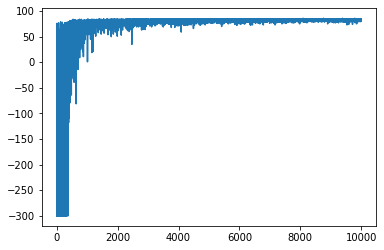

In [25]:
plt.plot(reward_records)

In [5]:
actions

[array([[21.61069773]]),
 array([[30.06070798]]),
 array([[6.35435098]]),
 array([[21.39733864]]),
 array([[13.32546554]]),
 array([[9.25933283]]),
 array([[23.71484851]]),
 array([[-4.77203838]]),
 array([[17.59522121]]),
 array([[25.34915821]]),
 array([[2.30933613]]),
 array([[7.9246282]]),
 array([[18.22252102]]),
 array([[18.98399747]]),
 array([[2.43496228]]),
 array([[9.76430582]])]

In [6]:
state.shape

(2,)

In [7]:
prev_state[np.newaxis,...]

array([[0.46216185, 0.07      ]])

In [8]:
env.state

array([0.53216185, 0.07      ])

In [9]:
state, reward, done, info = env.step(np.reshape(action,[1]))

In [10]:
state

array([[0.6 ],
       [0.07]])

In [11]:
np.reshape(action,[1])

array([9.76430582])

In [12]:
np.reshape(action,[-1])

array([9.76430582])

In [13]:
action[0][0]

9.764305817380695

In [14]:
state, reward, done, info = env.step(action[0][0])

In [15]:
state

array([[0.6 ],
       [0.07]])

In [16]:
env.reset()

array([-0.5,  0. ])

In [17]:
env.state

array([-0.5,  0. ])

In [18]:
state, reward, done, info = env.step(action[0][0])

In [19]:
state

array([-0.49041254,  0.00958746])

In [20]:
state, reward, done, info = env.step(action[0][0])

In [21]:
state

array([-0.47130925,  0.01910328])

In [22]:
state, reward, done, info = env.step(action[0])

In [23]:
state

array([[-0.44283223],
       [ 0.02847702]])

In [24]:
reward_records_=np.mean(reward_records, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
np.array(action_statmean_records).shape

In [ ]:
plt.plot(reward_records_)

In [ ]:
plt.plot(rewards)

In [28]:
import misc

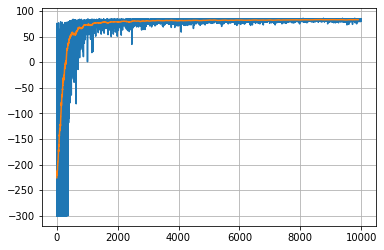

In [29]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()


(50.0, 100.0)

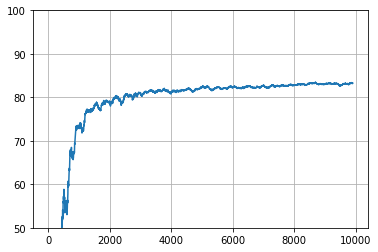

In [31]:
# plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()
plt.ylim([50,100])